# ===========================
# Benchmarking 2D / 3D PORTRAITS 
# ===========================

##### Blog regarding choosing plot type depending on data to communicate
+ https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

In [1]:
# import
from multidimvis_main import *

In [2]:
# add functions to multidimvis_main 

def embed_umap_2D(Matrix, n_neigh, spre, m_dist, metric='cosine', learn_rate = 1, n_ep = None):
    '''
    Dimensionality reduction from Matrix using UMAP.
    Return dict (keys: node IDs, values: x,y).
    ''' 
    n_comp = 2 

    U = umap.UMAP(
        n_neighbors = n_neigh,
        spread = spre,
        min_dist = m_dist,
        n_components = n_comp,
        metric = metric, 
        random_state=42,
        learning_rate = learn_rate, 
        n_epochs = n_ep)
    
    embed = U.fit_transform(Matrix)
    
    return embed


def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 3)), int(round(m, 0)), int(round(h, 0))
    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
   
    return m,s

## CHOOSE A TOY NETWORK

In [3]:
# TREE GRAPH

organism = 'tree'
n = 1093
r = 3
G = nx.full_rary_tree(r,n)

# get number of nodes with predefined generations and branching factor : 
generations = 6
branching = 4

lst = []
for i in range(generations+1):
    #print(i)
    j=branching**i
    lst.append(j)
    i+=1

#print('number of nodes required for branching factor r =',branching,': ',(sum(lst)))


#from networkx.drawing.nx_agraph import graphviz_layout

#pos = graphviz_layout(G, prog="twopi", args="")
#plt.figure(figsize=(16,16))
#nx.draw(G, pos, node_size=10, alpha=0.5, node_color="blue", with_labels=False)
#plt.axis("equal")
#plt.show()

## NETWORK

In [4]:
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.11f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Network: tree
Number of nodes: 1093
Number of edges: 1092
Network density: 0.18281535649%


____________
## PRE-SETTINGS
____________

+ PREDEFINED FEATURE MATRIX

In [5]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESSCENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)
    
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 


# CENTRALITY 

metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))
DM_cent.index = list(G.nodes())
DM_cent.columns = list(G.nodes())

#round(DM_cent,2)

In [6]:
# General Parameters:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = 'black'

# Node sizes 

#scalef= 0.2
#size = list(draw_node_degree(G, scalef).values())

#scalef= 0.05
#size3d = list(draw_node_degree_3D(G, scalef).values())

color_method = 'deg'
d_colours = color_nodes_from_dict(G, d_deghubs, palette = 'YlOrRd')
colours = list(d_colours.values())

labelsize = 18
legendfontsize = 12

___________
## NETWORK DISTANCE 
___________

In [14]:
%%time 

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = round(nx.shortest_path_length(G,geneA,geneB),1)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)

DM_spl = pd.DataFrame(Mspl, columns = list(G.nodes()), index=list(G.nodes()))

#DM_spl.astype(int)

df_spl = DM_spl 
x = df_spl.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
DM_spl_norm = pd.DataFrame(x_scaled)

CPU times: user 41.2 s, sys: 1.64 s, total: 42.8 s
Wall time: 42.9 s


______________
# 2D BENCHMARK - visual + statistical 
______________

### SPRING

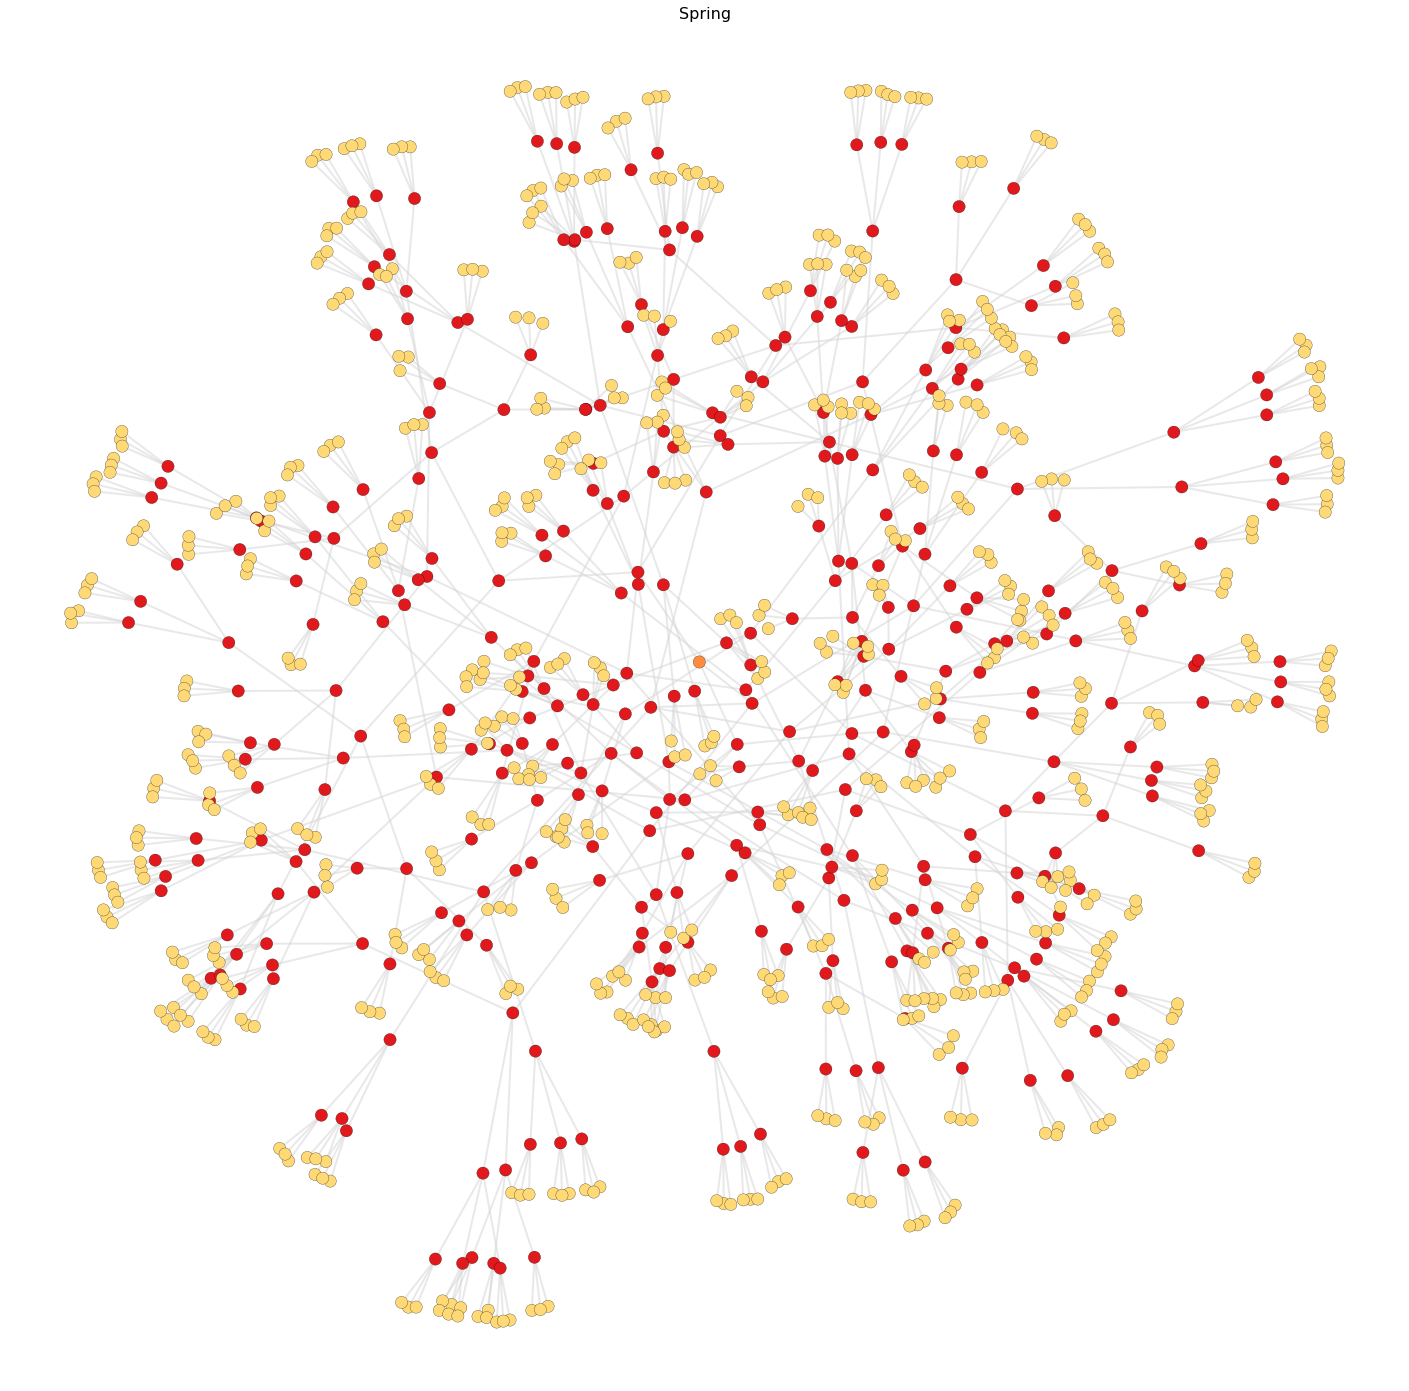

CPU times: user 5.48 s, sys: 59 ms, total: 5.54 s
Wall time: 5.28 s


In [15]:
%%time

posG_spring2D = nx.spring_layout(G, iterations = 50, dim = 2)

df_posG = pd.DataFrame(posG_spring2D).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))


plt.figure(figsize=(25,25))
plt.title('Spring', size= 16)

nx.draw_networkx_nodes(G, posG_spring2D_norm, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, 
                       node_size= 150, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_spring2D_norm, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dspring_'+organism+'.png')

plt.show()

## 2D PORTRAITS 

+ ADJACENCIES

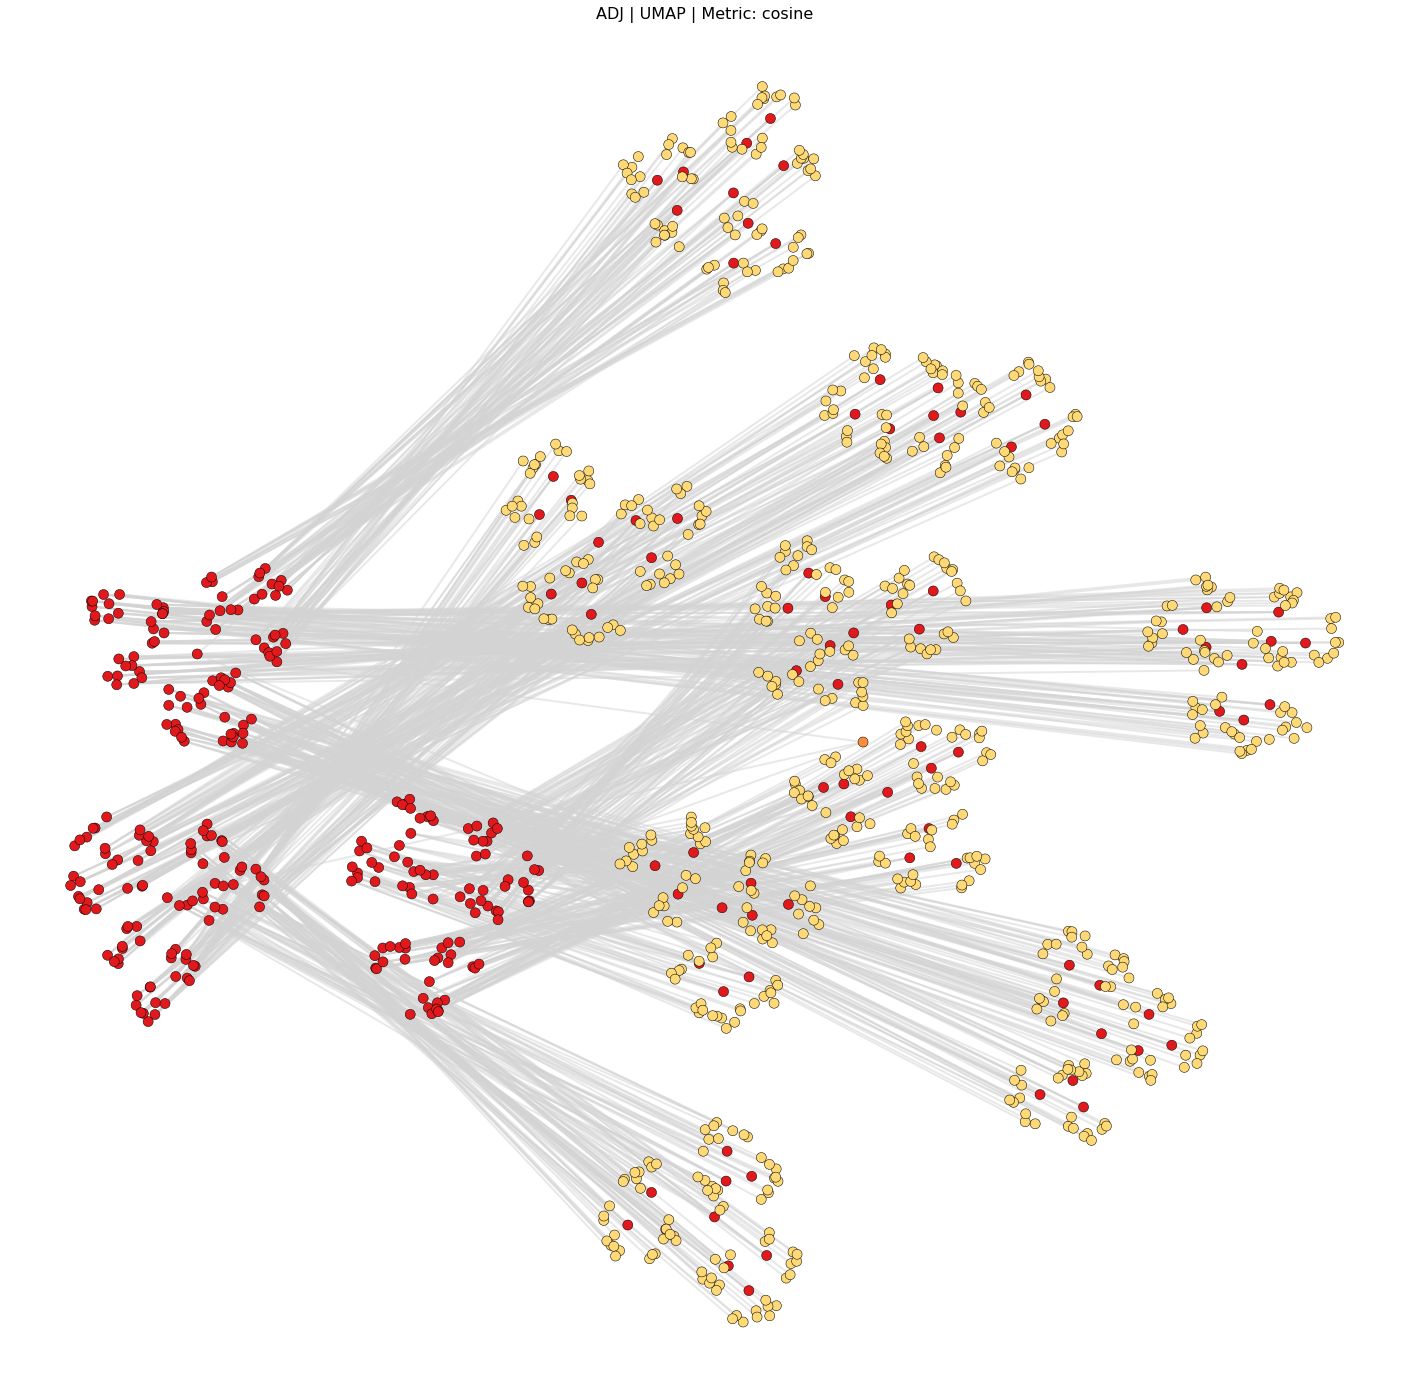

CPU times: user 5.21 s, sys: 76.6 ms, total: 5.29 s
Wall time: 4.86 s


In [16]:
%%time

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.9 #defines how dense points are stacked together 
metric ='cosine'
lnr = 1
nep = None

feature = 'ADJ'

A = nx.adjacency_matrix(G)
adj = A.toarray()
df_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))
DM = df_adj

umap_adj = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

posG_umap_adj = get_posG_2D(list(G.nodes()), umap_adj)
posG_complete_umap_adj = {key:posG_umap_adj[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_adj).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_adj_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_adj_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_adj_norm, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

+ RANDOM WALK - visiting probability 

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



Network: tree
Number of nodes: 1093
Number of edges: 1092


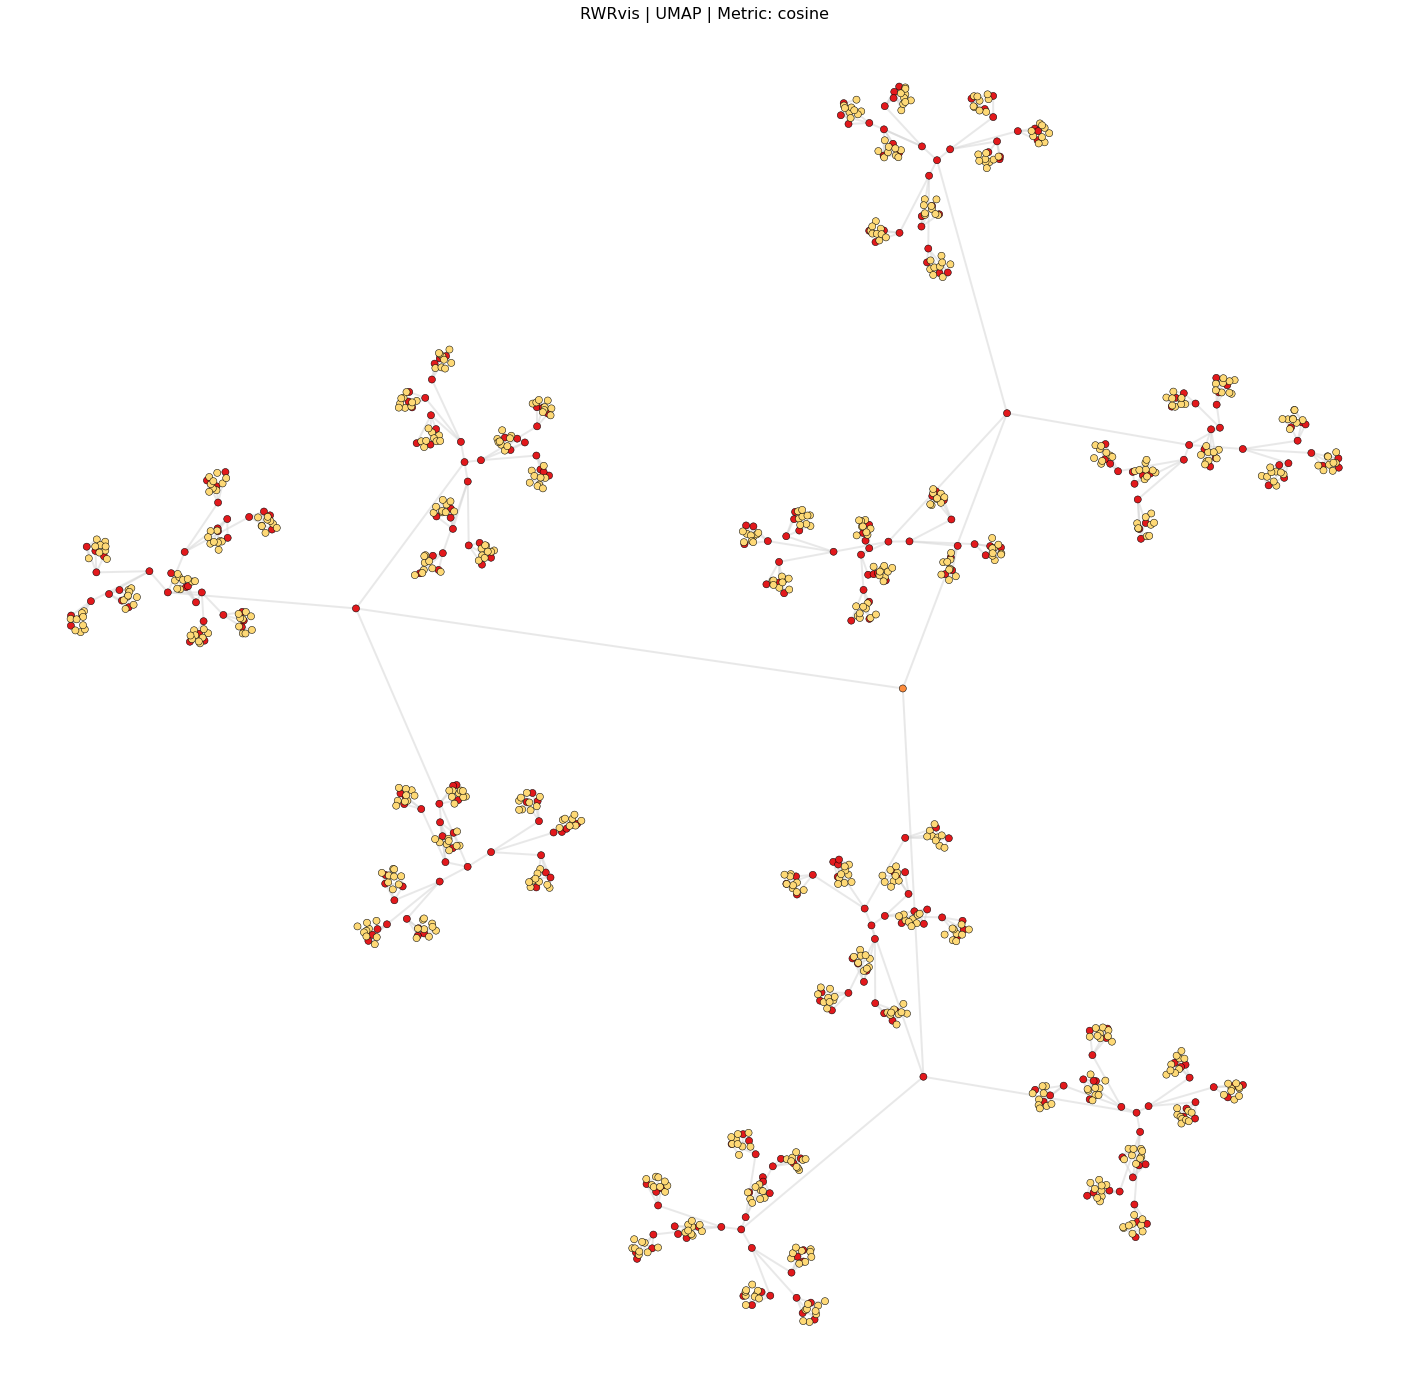

CPU times: user 5.82 s, sys: 170 ms, total: 5.99 s
Wall time: 5.09 s


In [17]:
%%time 

n_neighbors = 20 # 8
spread = 10.0 # 2.0
min_dist = 0.1 # 0.5
metric ='cosine'
lnr = 1
nep = None

feature = 'RWRvis'

r = .9 # restart probability; originally 0.8
alpha = 1.0
# alpha = 0.5 # --> better results for torus 

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
FM_m_transposed = FM_m#.T
DM=FM_m_transposed

umap_rwr = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_rwr).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_rwr_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 50, #100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_rwr_norm, width = edge_width, 
                       edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
plt.show()

+ FEATURE MATRIX = CENTRALITIES

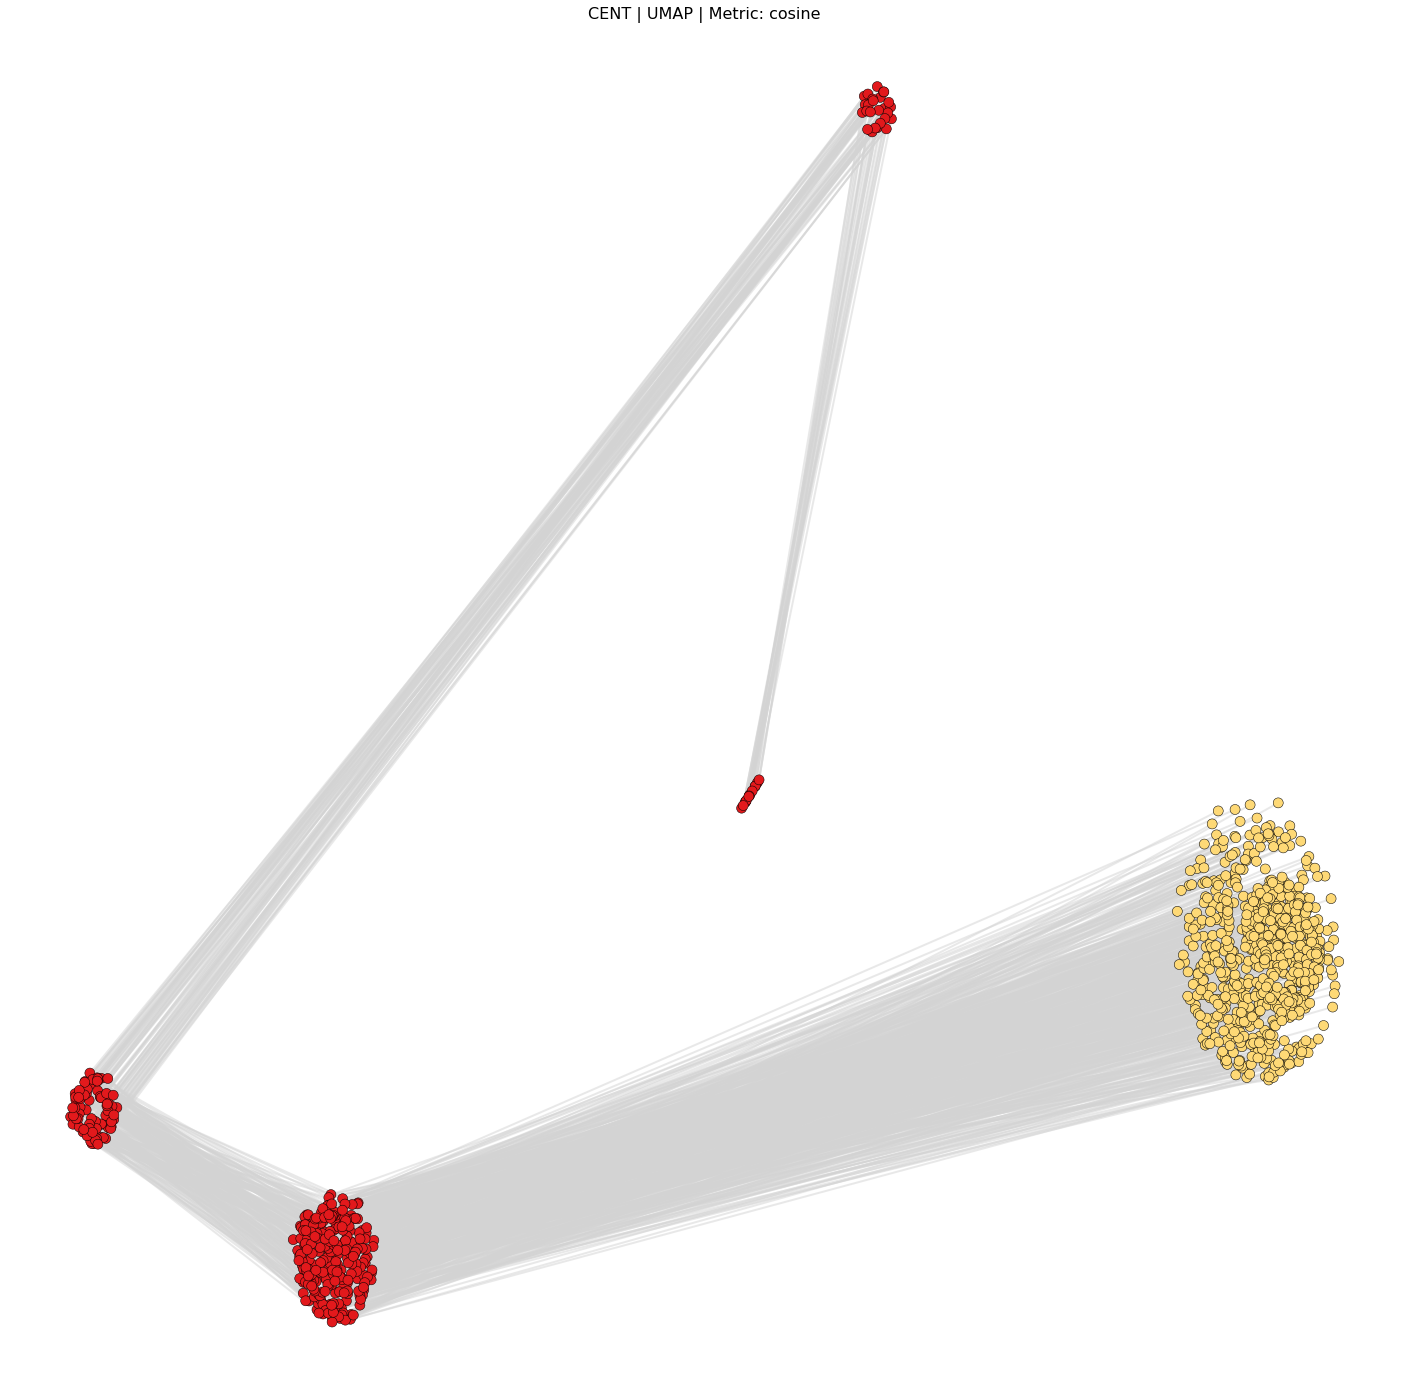

CPU times: user 12.2 s, sys: 102 ms, total: 12.3 s
Wall time: 11.9 s


In [18]:
%%time 

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.9 #defines how dense points are stacked together 
metric ='cosine'

feature = 'CENT'
DM = DM_cent

umap_cent = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

posG_umap_cent = get_posG_2D(list(G.nodes()), umap_cent)
posG_complete_umap_cent = {key:posG_umap_cent[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_cent).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_cent_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_cent_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_cent_norm, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

_________

# EVALUATION - 2D
### Network Distance vs. Layout Distance 
+ Plots to compare Network Distances (i.e. SPL) with embedded Layout Distances 
+ X-axis = Reference axis i.e. Network Distance 
+ Y-axis = Layout Distance 

## 2D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

+ SPRING

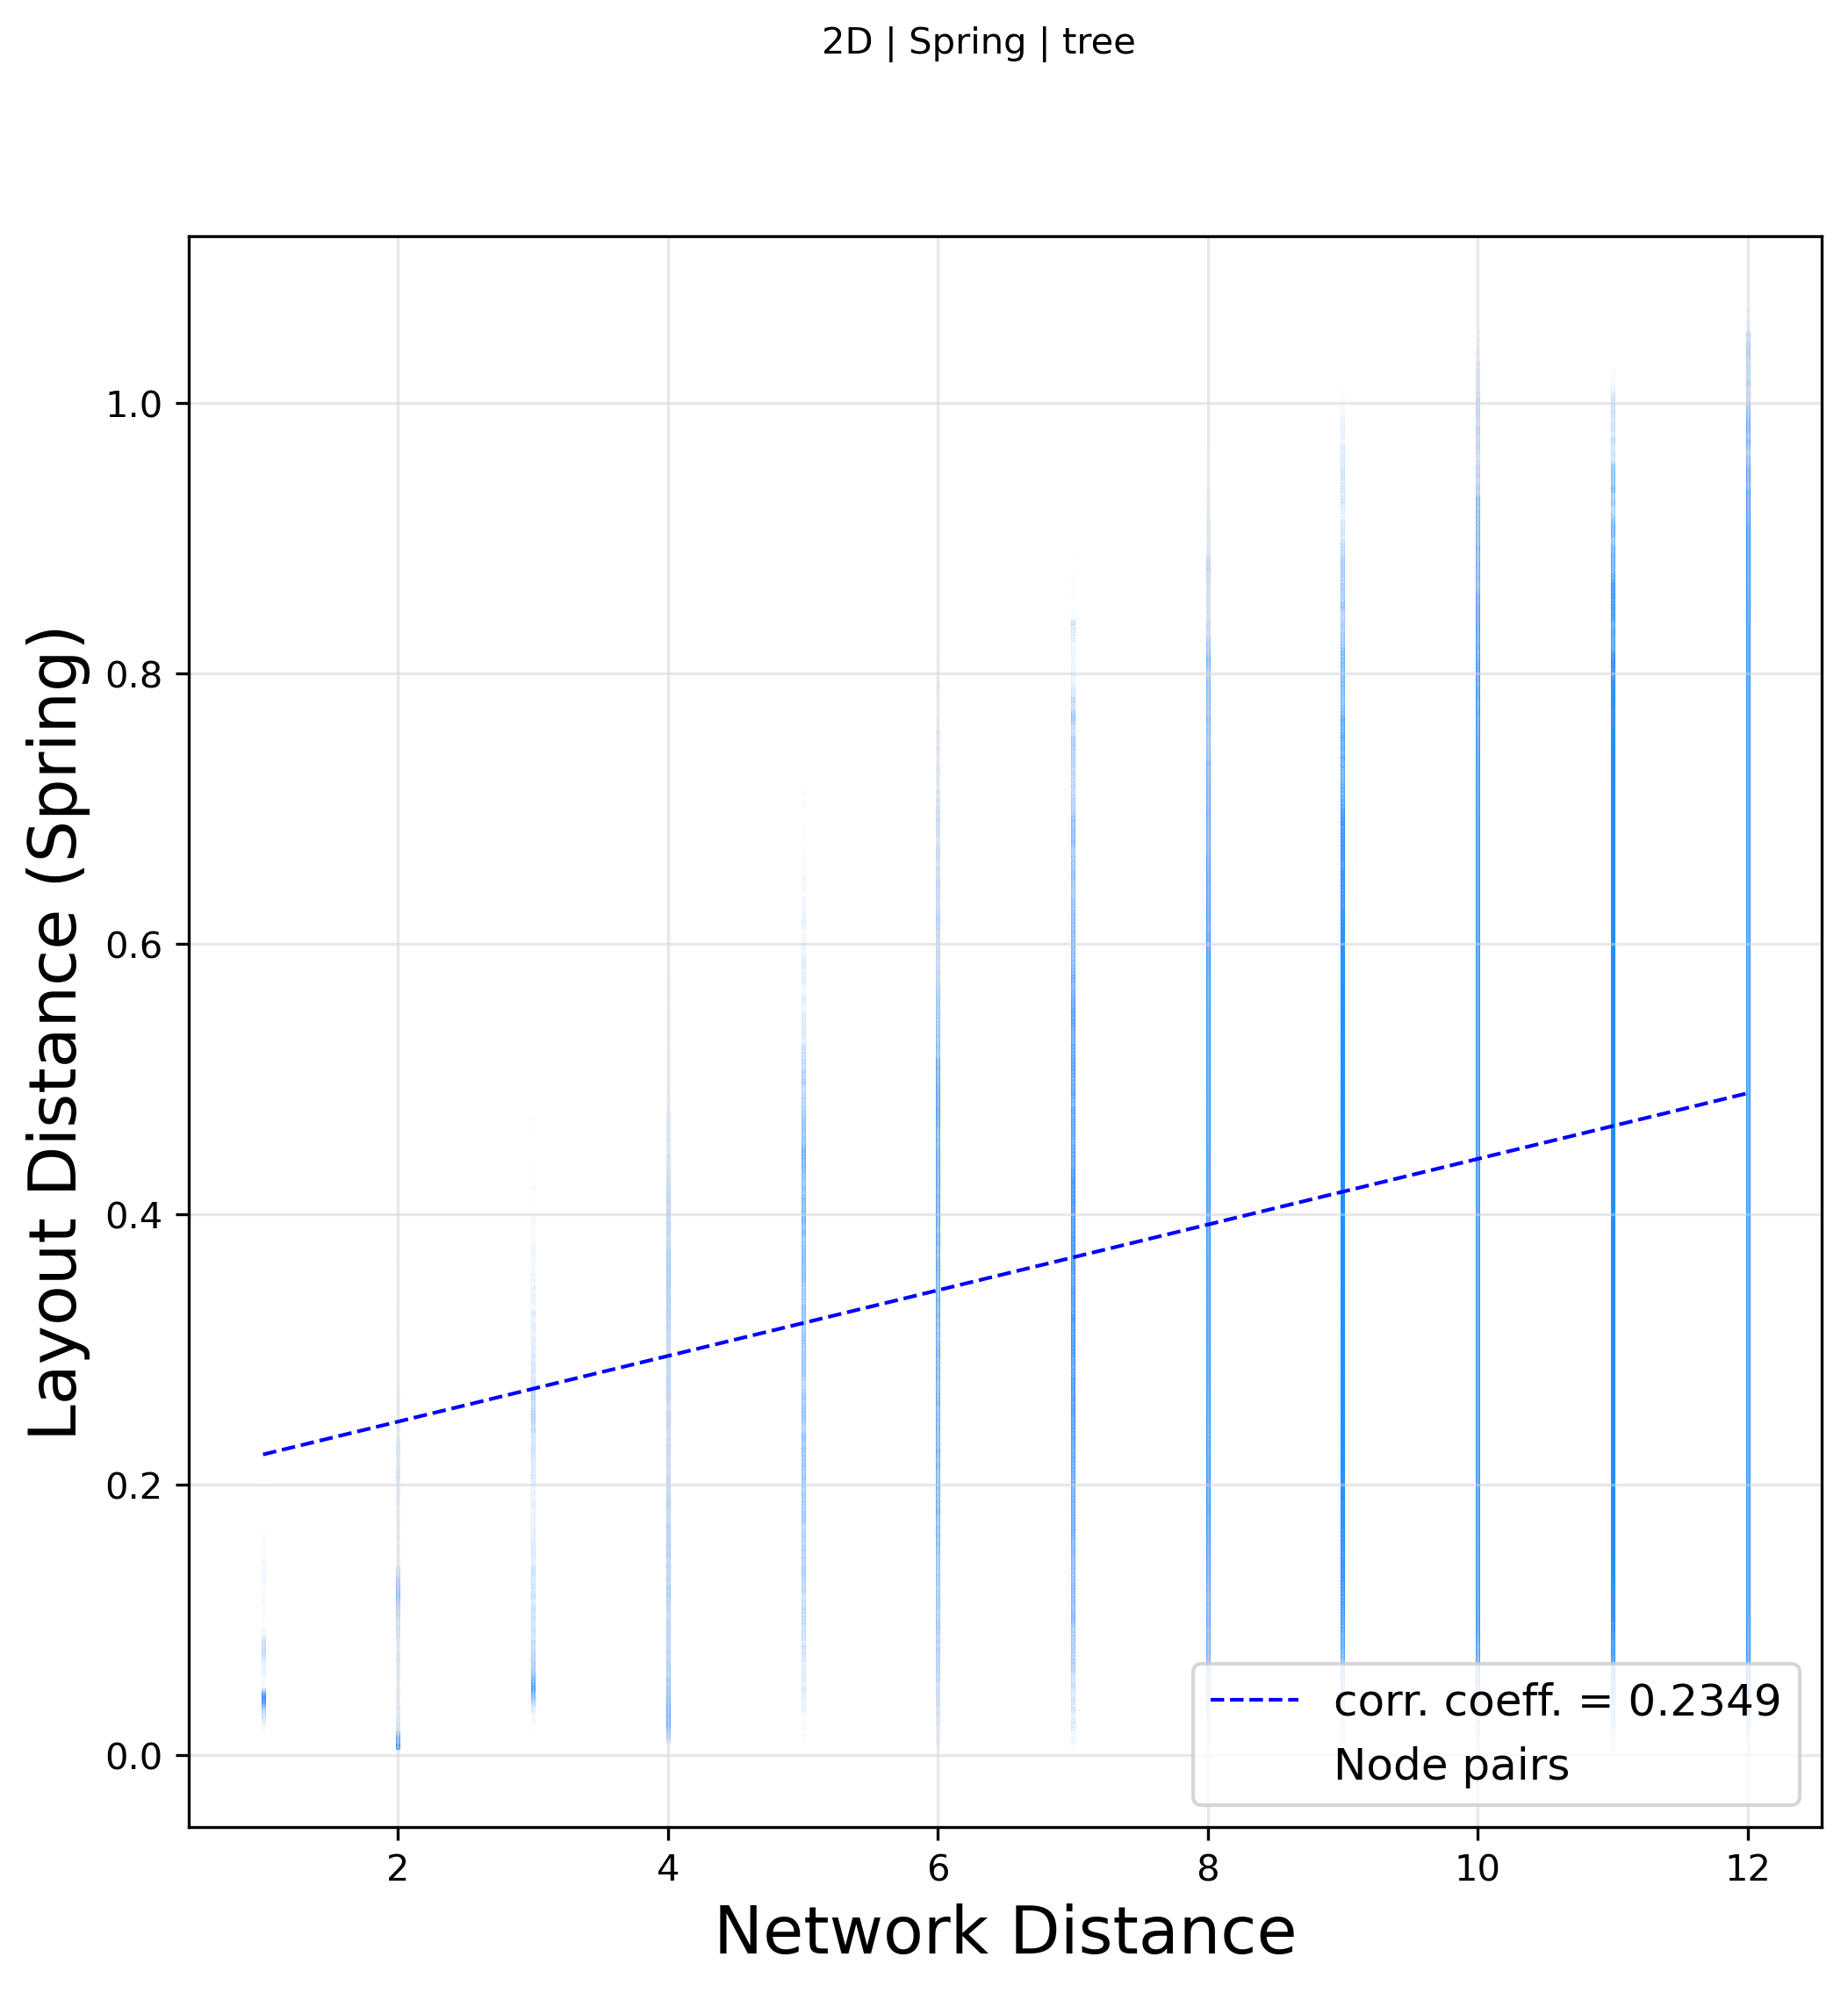

In [19]:
posG_spring2D = posG_spring2D_norm
DM_spl = df_spl
#DM_spl = DM_spl_norm 

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]

# SPRING
dist_spring2D = {} 
for (id1,p1),(id2,p2) in it.combinations(posG_spring2D.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

fig = plt.figure(figsize=(8,8), dpi=300)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

y_spring = list(dist_spring2D.values())
x_spring = list(dist_network.values())
plt.scatter(x_spring,y_spring, c = 'dodgerblue', s = 0.00005, alpha=0.5)

# REGRESSION LINE 
gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
mn_spring= min(x_spring)
mx_spring= max(x_spring)
x1_spring=np.linspace(mn_spring,mx_spring,500)
line_spring =gradient_spring*x1_spring+intercept_spring
plt.plot(x1_spring,line_spring,'--b',linewidth=1.0)

plt.grid(True, c='lightgrey', alpha=0.5)

plt.legend(('corr. coeff. = {}'.format(round(r_value_spring,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | Spring | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring,intercept_spring), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_SPRING_'+organism+'.png')

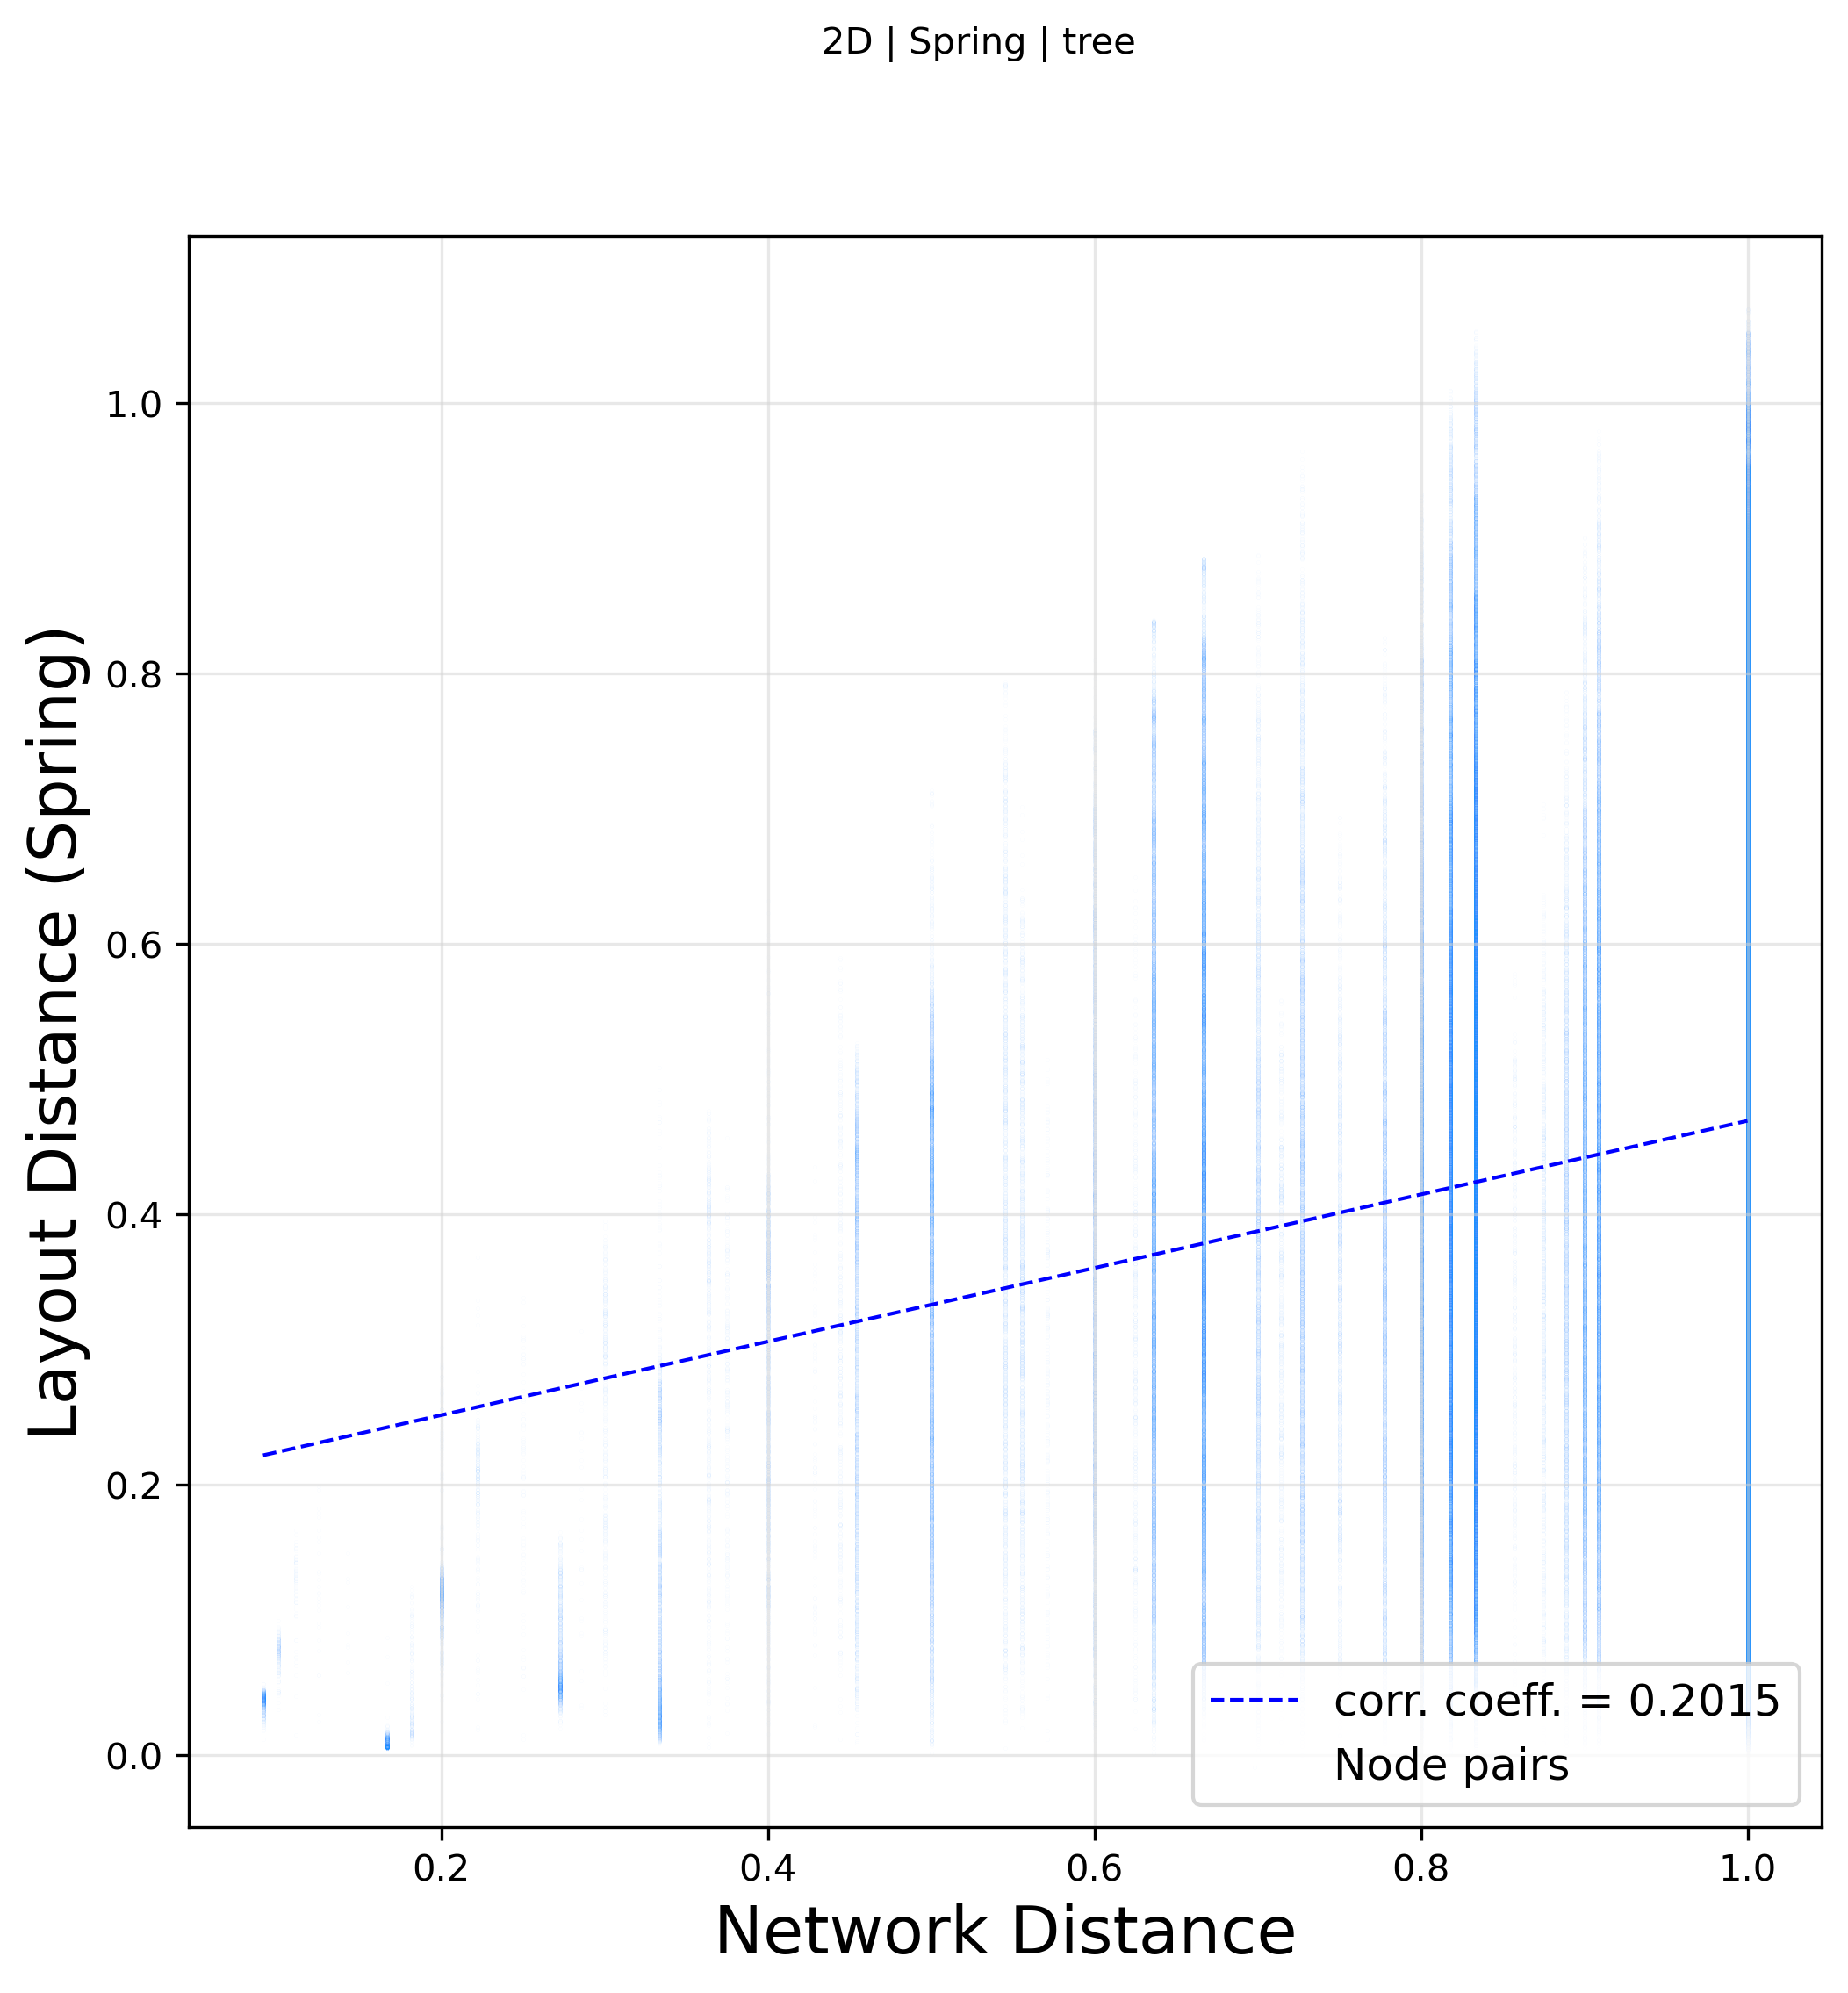

In [77]:
posG_spring2D = posG_spring2D_norm

#DM_spl = df_spl
DM_spl = DM_spl_norm 

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]

# SPRING
dist_spring2D = {} 
for (id1,p1),(id2,p2) in it.combinations(posG_spring2D.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

fig = plt.figure(figsize=(8,8), dpi=300)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

y_spring = list(dist_spring2D.values())
x_spring = list(dist_network.values())
plt.scatter(x_spring,y_spring, c = 'dodgerblue', s = 0.00005, alpha=0.5)

# REGRESSION LINE 
gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
mn_spring= min(x_spring)
mx_spring= max(x_spring)
x1_spring=np.linspace(mn_spring,mx_spring,500)
line_spring =gradient_spring*x1_spring+intercept_spring
plt.plot(x1_spring,line_spring,'--b',linewidth=1.0)

plt.grid(True, c='lightgrey', alpha=0.5)

plt.legend(('corr. coeff. = {}'.format(round(r_value_spring,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | Spring | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring,intercept_spring), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_SPRING_'+organism+'_norm.png')

+ RANDOM WALK 

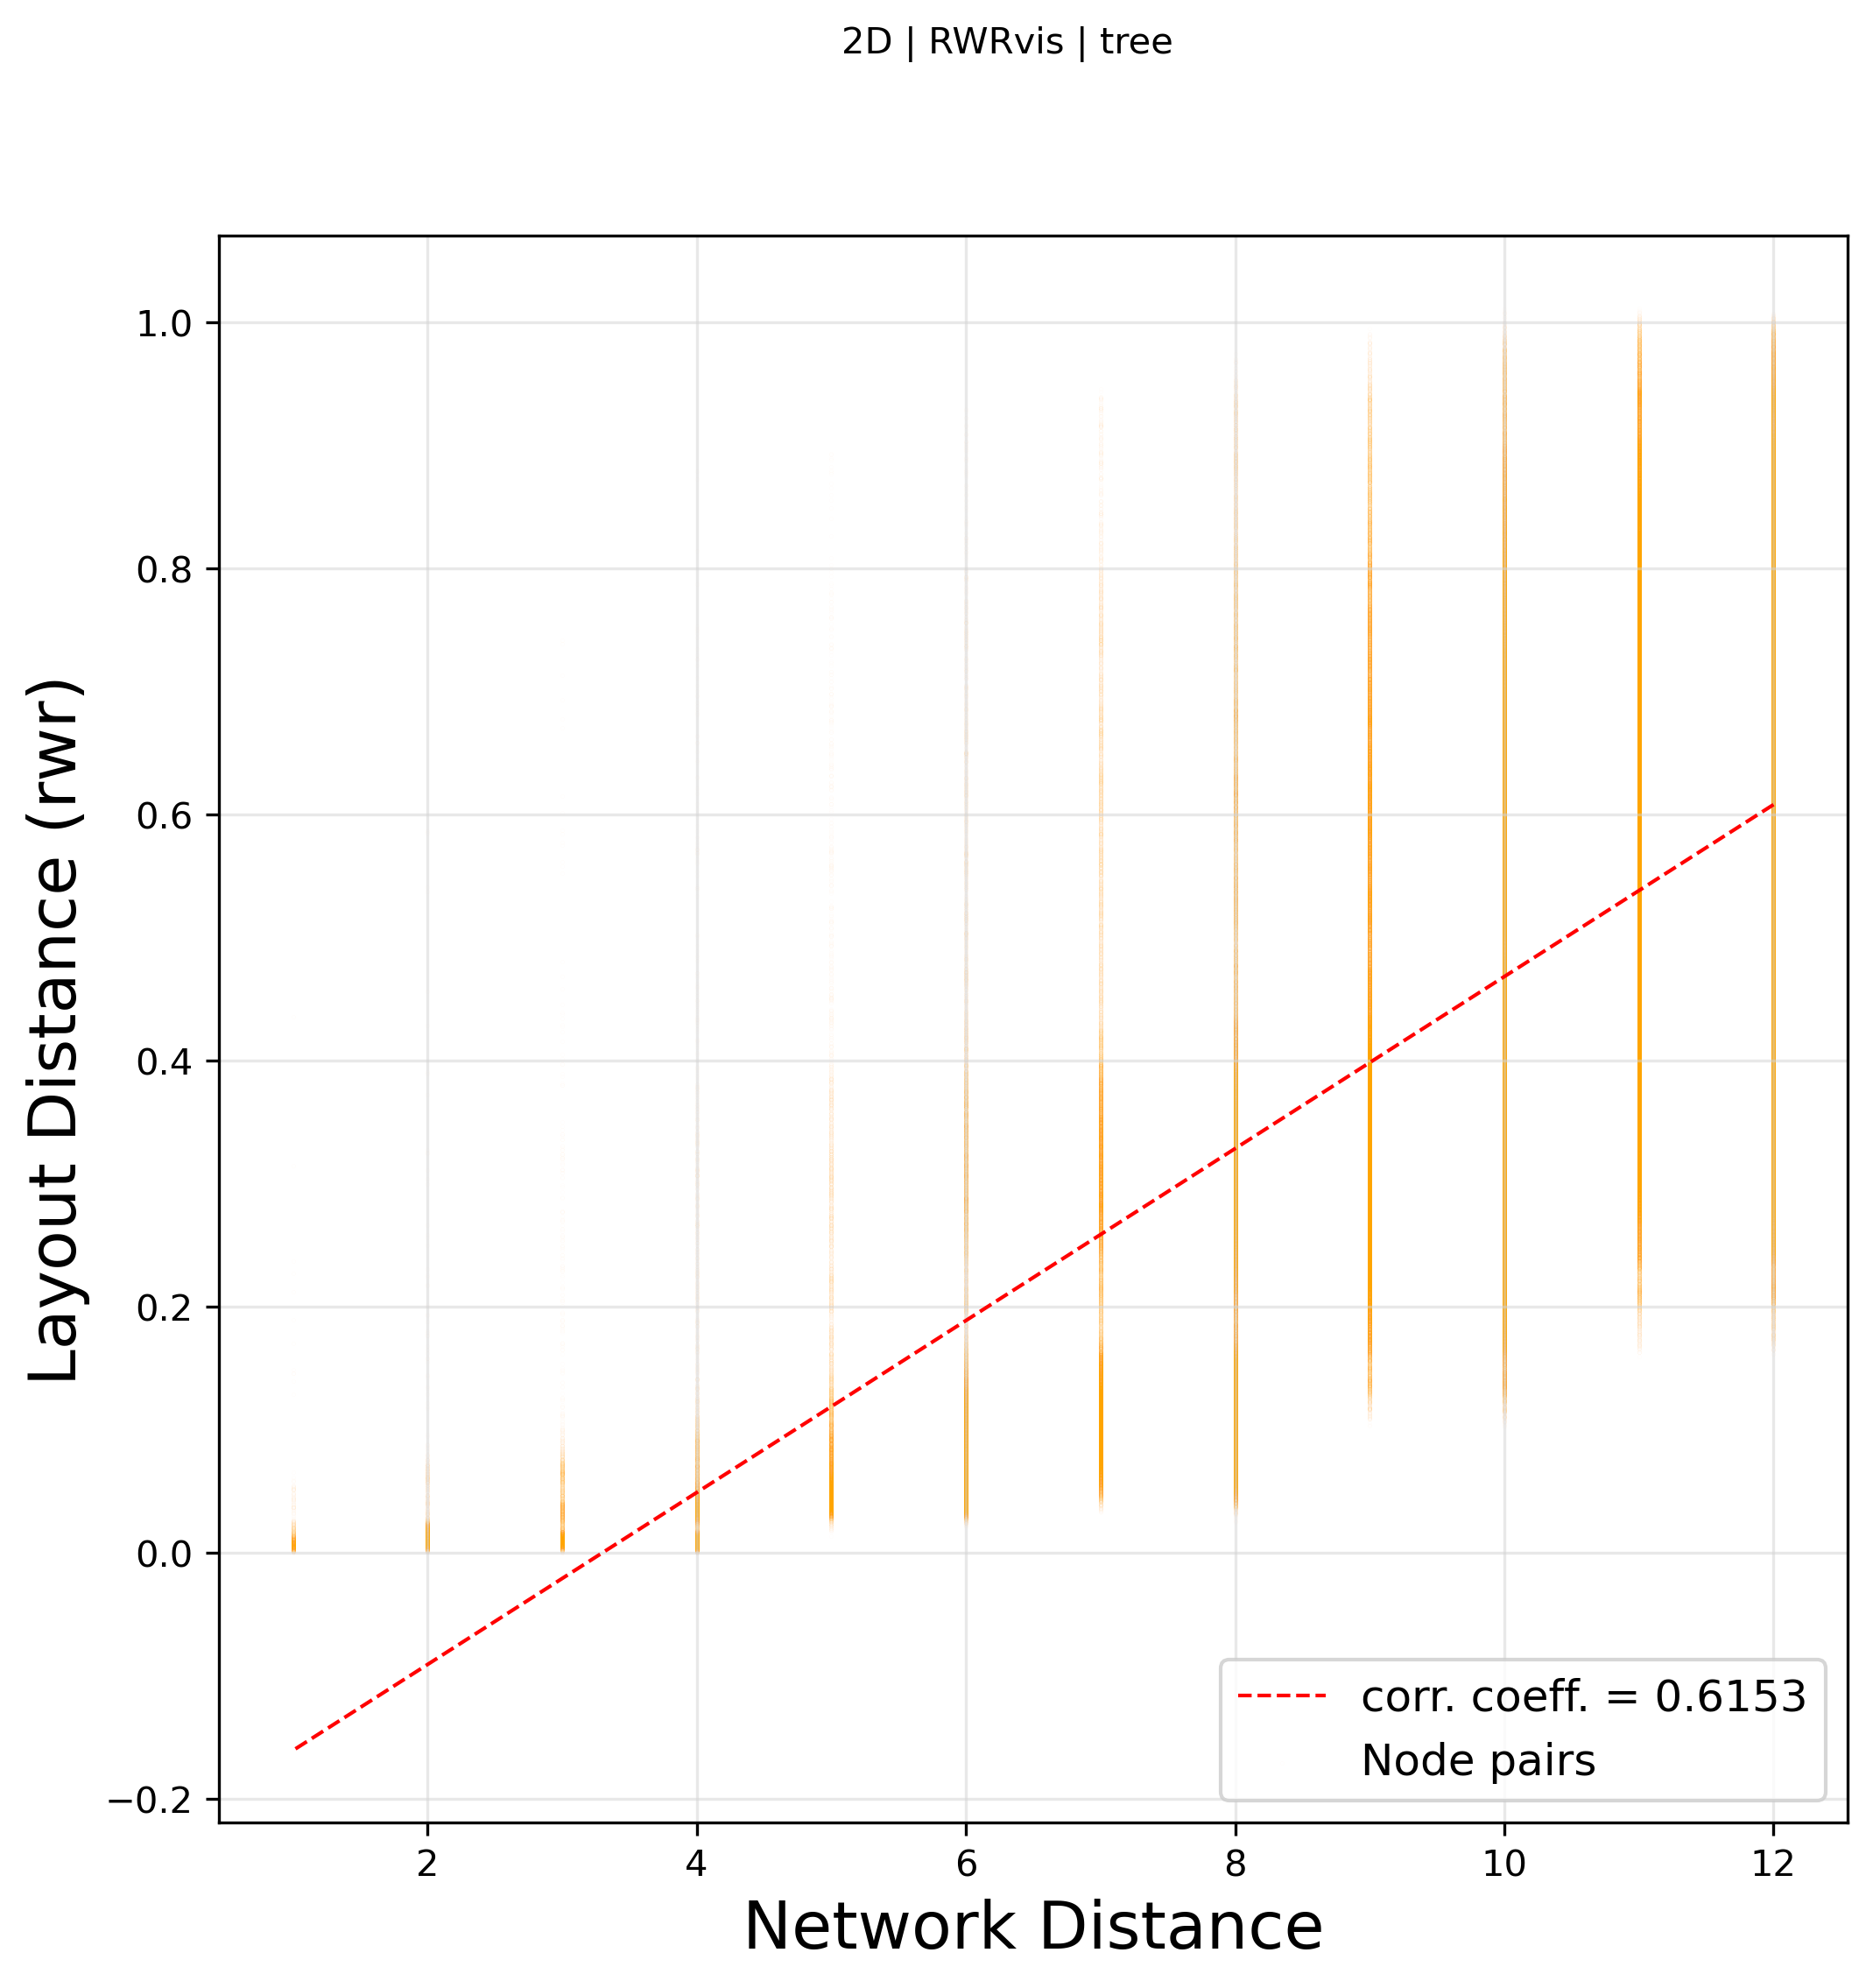

In [20]:
feature = 'RWRvis'
#DM = DM_m
DM = FM_m_transposed
DM_spl = df_spl
# DM_spl = DM_spl_norm


# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]
    
# LAYOUT 
posG_complete_umap = posG_complete_umap_rwr_norm 

dist_layout2D = {}
for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

fig = plt.figure(figsize=(8,8), dpi=300)

y_layout = list(dist_layout2D.values())
x_layout = list(dist_network.values())
plt.scatter(x_layout,y_layout, c = 'orange', s = 0.00005, alpha = 0.5)

# REGRESSION LINE 
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
mn_layout = min(x_layout)
mx_layout = max(x_layout)
x1_layout=np.linspace(mx_layout,mn_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)
plt.legend(('corr. coeff. = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')

# PARAMETER TESTING for high Correlation Coefficients 

### SPRING 

In [21]:
# SPRING ITERATIONS cs. Correlation Coefficient (Network Dist / Layout Dist) 

feature = 'spring'
DM_spl = df_spl 

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]
    
iterationslist = [10,50,100,500,1000,2000,3000,4000,5000]

d_walltimes = {}
d_r_values = {}

for i in iterationslist:
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = i, dim = 2)
    end = time.time()
    print('Spring iter:', i)
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    print('----------------')
    
    walltime = s+m*60
    d_walltimes[i] = walltime
    
    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network.values())
    
    gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_r_values[i] = r_value_spring

Spring iter: 10
Execution Time: 00:00:01
min: 0 sec: 1
----------------
Spring iter: 50
Execution Time: 00:00:04
min: 0 sec: 4
----------------
Spring iter: 100
Execution Time: 00:00:08
min: 0 sec: 8
----------------
Spring iter: 500
Execution Time: 00:00:44
min: 0 sec: 44
----------------
Spring iter: 1000
Execution Time: 00:01:31
min: 1 sec: 31
----------------
Spring iter: 2000
Execution Time: 00:02:58
min: 2 sec: 58
----------------
Spring iter: 3000
Execution Time: 00:04:36
min: 4 sec: 36
----------------
Spring iter: 4000
Execution Time: 00:06:18
min: 6 sec: 18
----------------
Spring iter: 5000
Execution Time: 00:08:00
min: 8 sec: 0
----------------


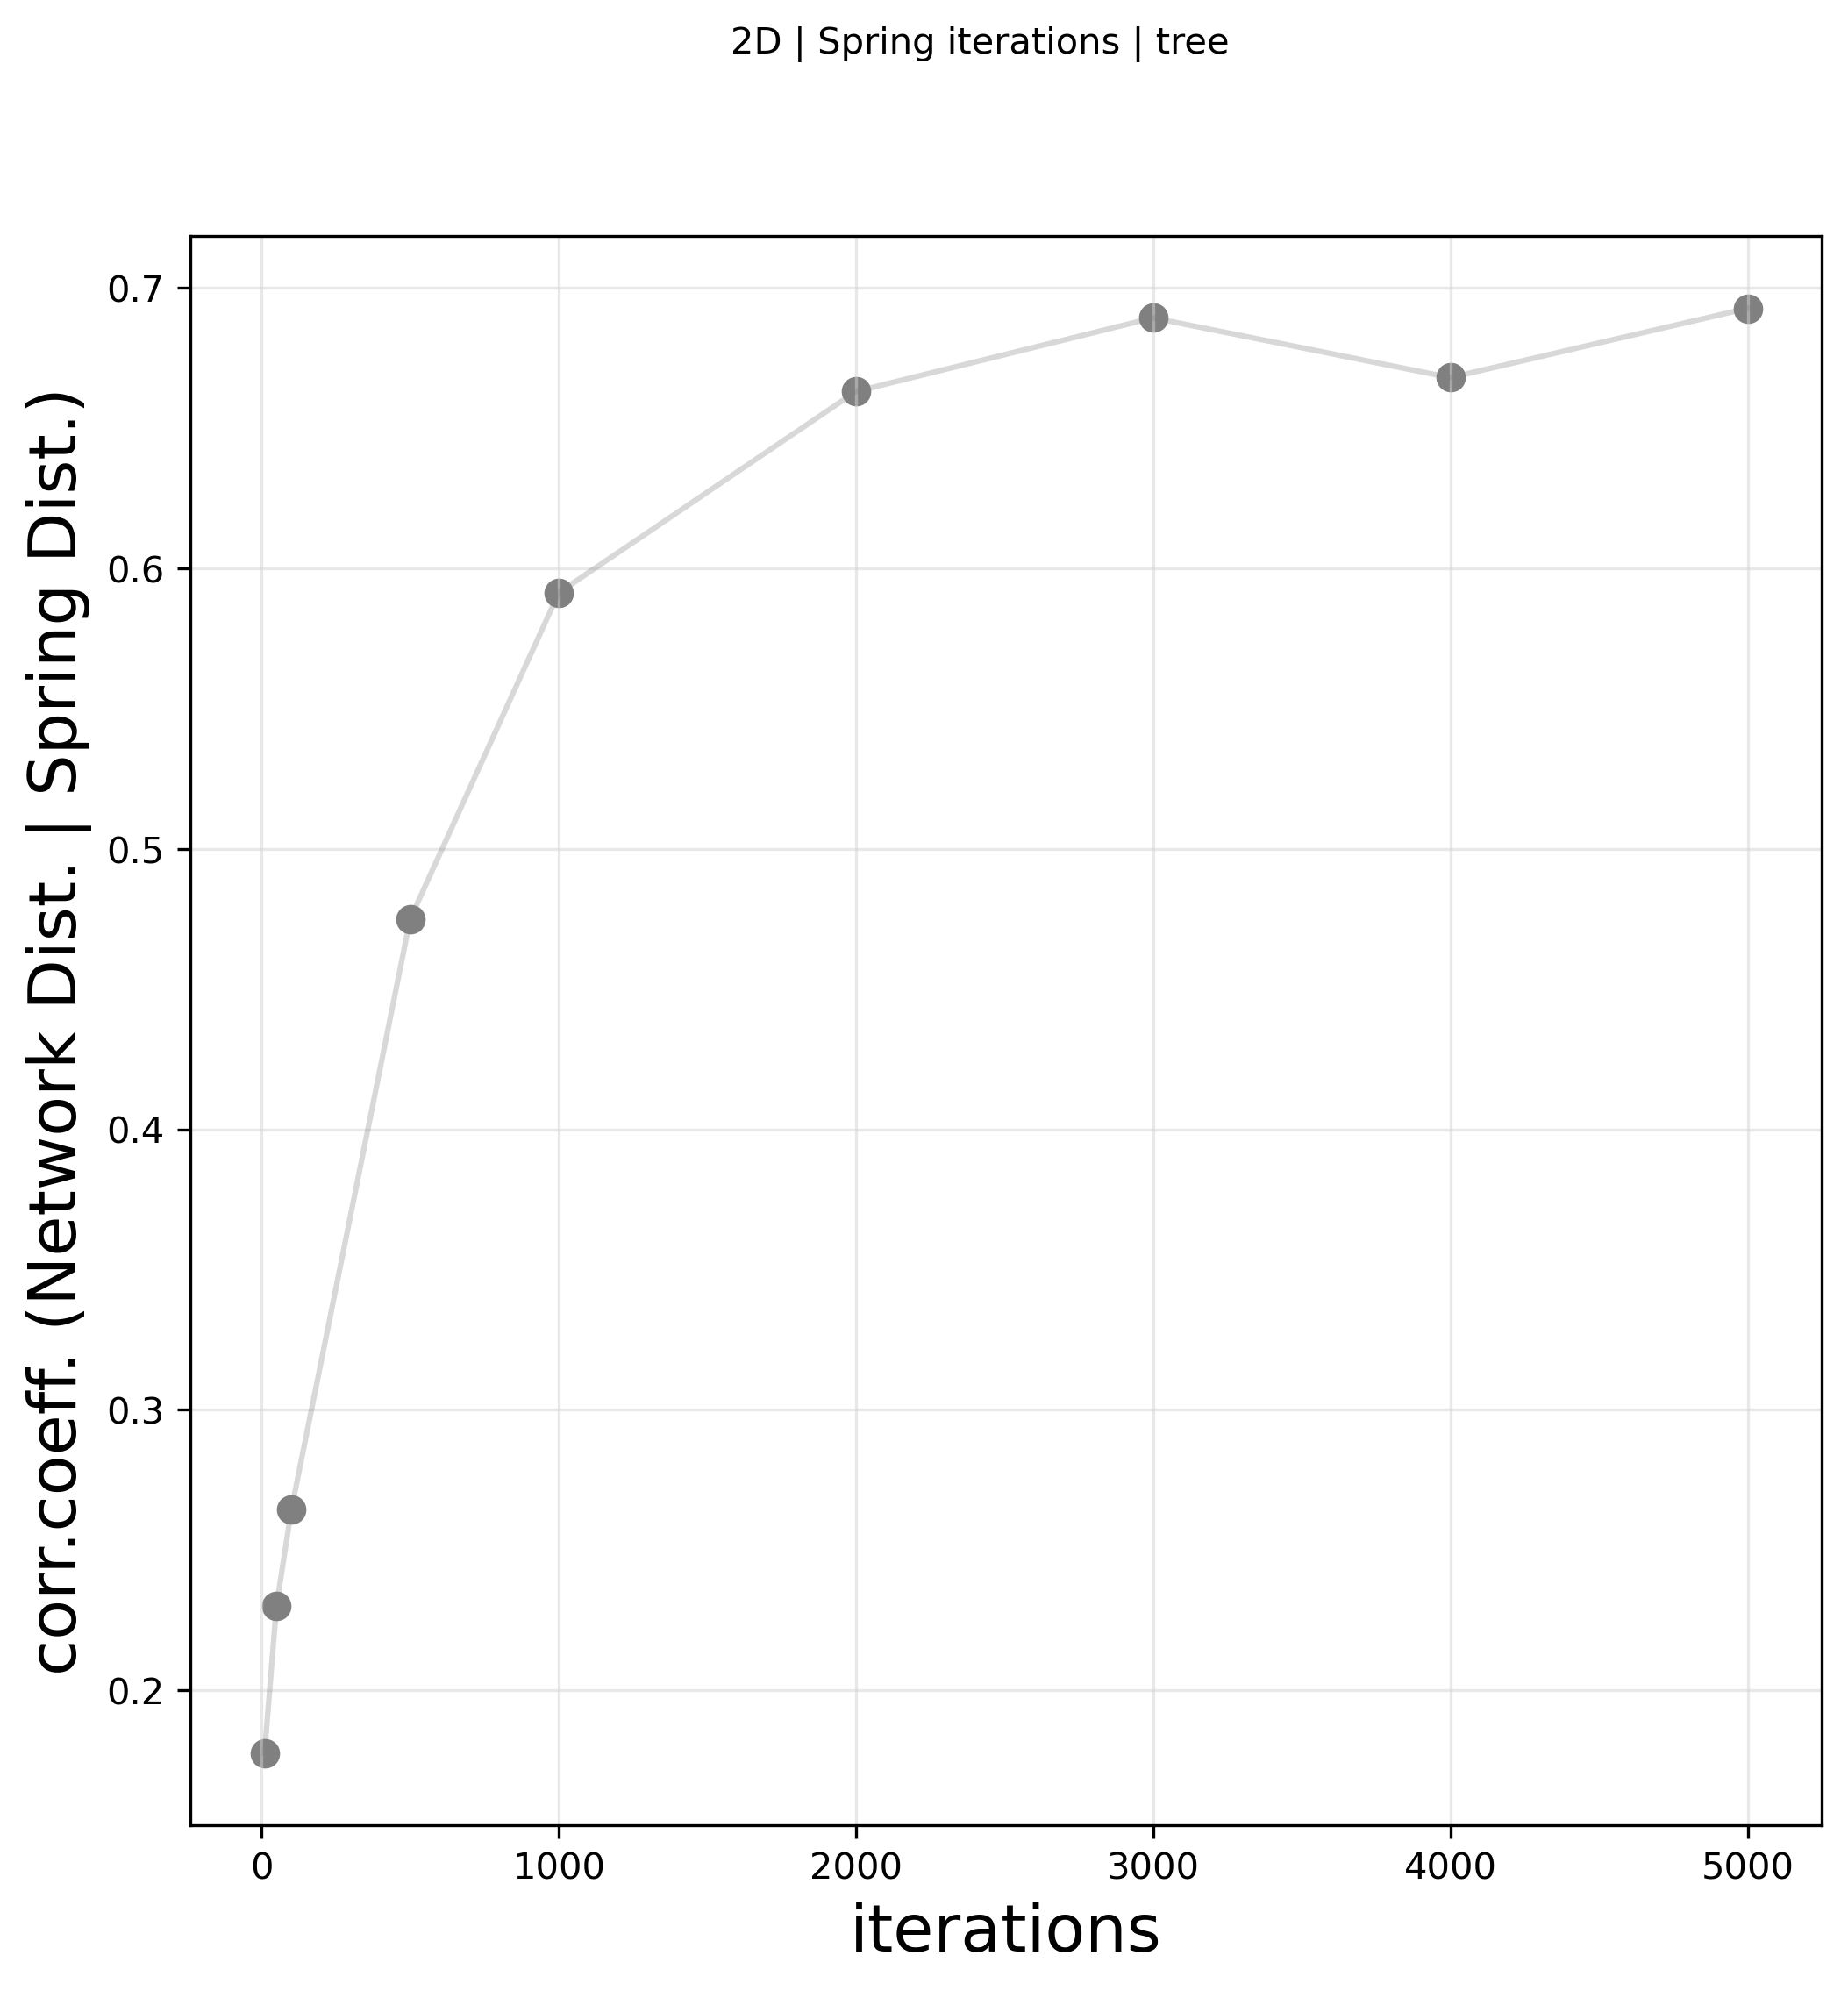

In [22]:
x_corr_spring = list(d_walltimes.keys())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("iterations", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | Spring iterations | '+organism, fontsize=10)

fig.savefig('output_plots/Correlation_'+feature+'_'+organism+'.png')

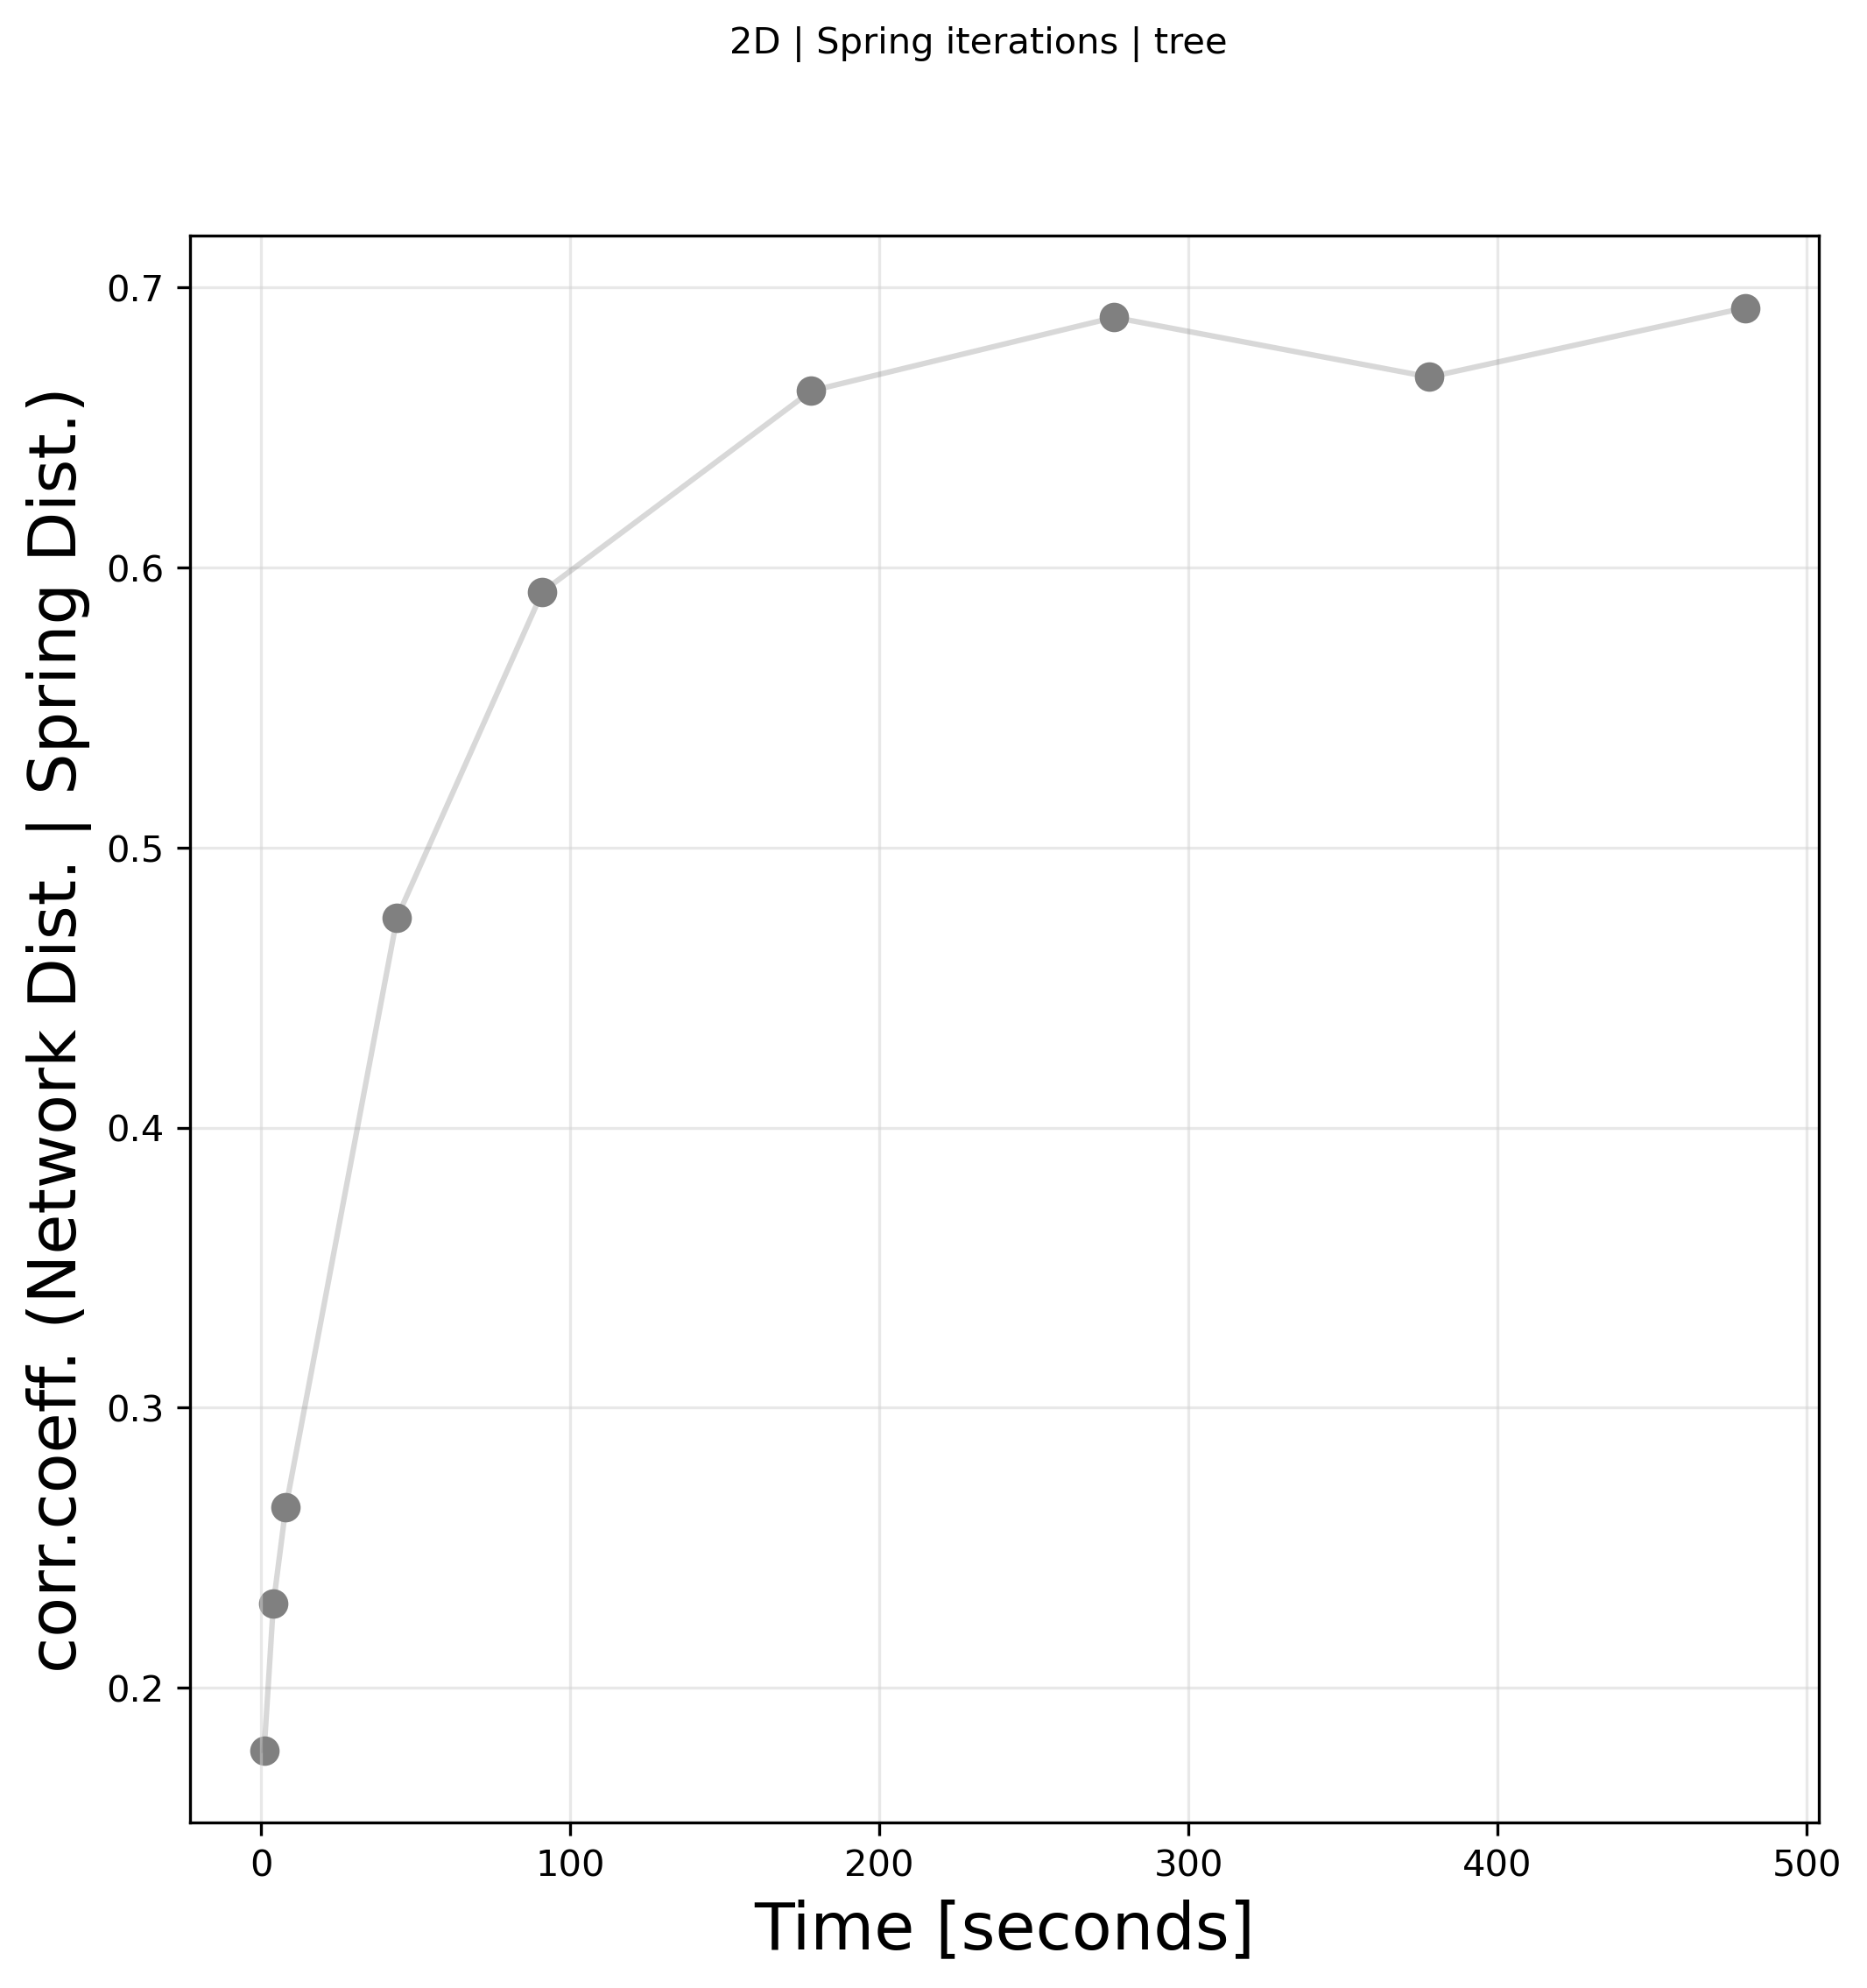

In [29]:
x_corr_spring = list(d_walltimes.values())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("Time [seconds]", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | Spring iterations | '+organism, fontsize=10)

fig.savefig('output_plots/Correlation_Time_'+feature+'_'+organism+'.png')

### UMAP - RWR

##### Impact of UMAP PARAMETERS to CORRELATION COEFFICIENT (of Network Dist / Layout Dist) 
+ number of neighbors 
+ n_epochs
+ learning rate 
+ spread 
+ min_dist

In [30]:
feature = 'RWRvis'
DM_spl = df_spl 

r = .9 # restart probability 
alpha = 1.0

# INITIAL STATE PARAMETERS: 
n_neighbors = 20 #8 # balance between local and global structure in the data
spread = 1.0 # 2.0
min_dist = 0.9 # 0.5
metric ='cosine'

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]

In [31]:
# NUMBER OF NEIGHBORS 

n_neighbor_list = [4,10,20,50,100,200,1000]

d_rwr_neigh = {}
d_r_values_rwr_neigh = {}

for i in n_neighbor_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM = FM_m #.T

    umap_rwr = embed_umap_2D(DM, i, spread, min_dist, metric, learn_rate = lnr, n_ep = 1000)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP n_neighs:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_neigh[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_neigh[i] = r_value_rwr

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/spectral.py:255: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/spectral.py:255: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/spectral.py:255: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/spectral.py:255: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/u

UMAP n_neighs: 4
Execution Time: 00:00:04
min: 0 sec: 4
UMAP n_neighs: 10
Execution Time: 00:00:05
min: 0 sec: 5
UMAP n_neighs: 20
Execution Time: 00:00:05
min: 0 sec: 5
UMAP n_neighs: 50
Execution Time: 00:00:06
min: 0 sec: 6
UMAP n_neighs: 100
Execution Time: 00:00:07
min: 0 sec: 7
UMAP n_neighs: 200
Execution Time: 00:00:08
min: 0 sec: 8
UMAP n_neighs: 1000
Execution Time: 00:03:17
min: 3 sec: 17


In [32]:
d_rwr_neigh

{4: 4, 10: 5, 20: 5, 50: 6, 100: 7, 200: 8, 1000: 197}

In [33]:
d_r_values_rwr_neigh

{4: 0.2538492097577349,
 10: 0.5459390152237349,
 20: 0.6656072060064759,
 50: 0.6483048583605442,
 100: 0.601104439063485,
 200: 0.6283065319791995,
 1000: 0.5527555338507718}

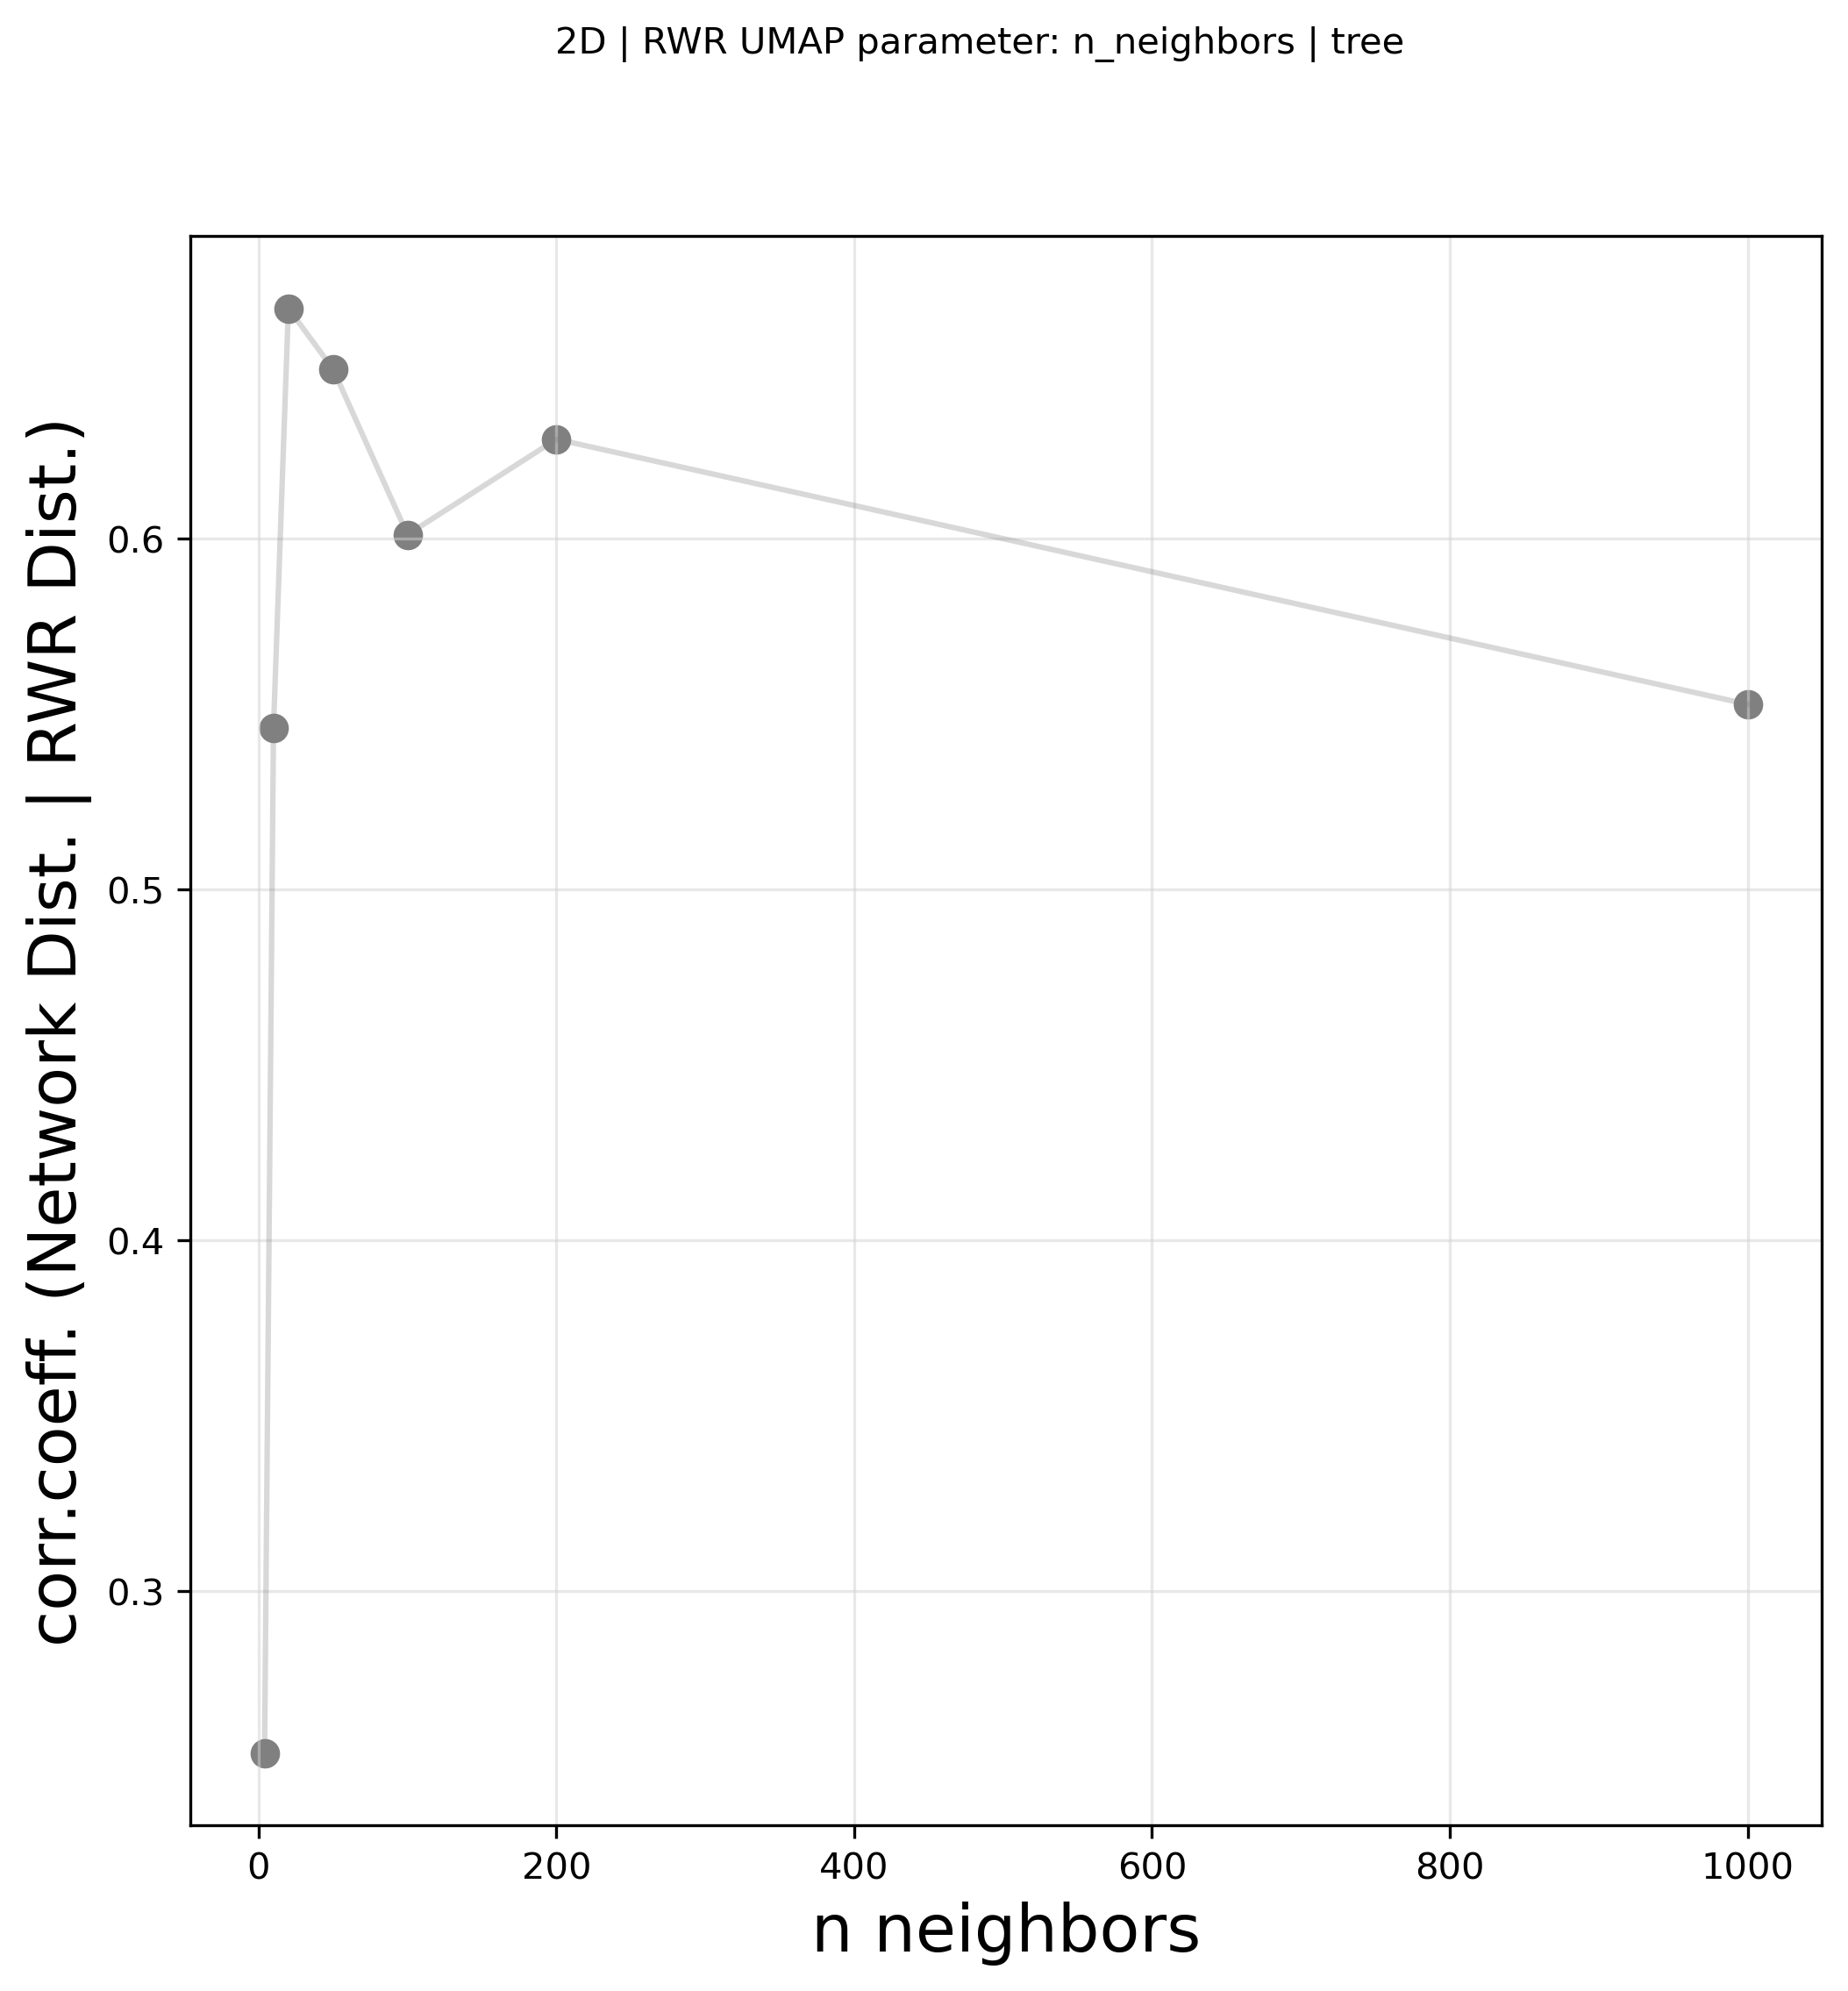

In [34]:
x = list(d_rwr_neigh.keys())
y = list(d_r_values_rwr_neigh.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("n neighbors", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: n_neighbors | '+organism, fontsize=10)

fig.savefig('output_plots/Correlation_neighs_'+feature+'_'+organism+'.png')

In [35]:
# NUMBER OF EPOCHS 

nep_list = [None, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]

d_rwr_epochs = {}
d_r_values_rwr_nep = {}

for i in nep_list: 
    
    start = time.time()
    
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM = FM_m #.T

    umap_rwr = embed_umap_2D(DM, 20, spread, min_dist, metric, learn_rate = lnr, n_ep = i)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP n_epoch:' ,i) 
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_epochs[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_nep[i] = r_value_rwr

UMAP n_epoch: None
Execution Time: 00:00:04
min: 0 sec: 4
UMAP n_epoch: 100
Execution Time: 00:00:03
min: 0 sec: 3
UMAP n_epoch: 200
Execution Time: 00:00:03
min: 0 sec: 3
UMAP n_epoch: 300
Execution Time: 00:00:03
min: 0 sec: 3
UMAP n_epoch: 400
Execution Time: 00:00:04
min: 0 sec: 4
UMAP n_epoch: 500
Execution Time: 00:00:04
min: 0 sec: 4
UMAP n_epoch: 600
Execution Time: 00:00:04
min: 0 sec: 4
UMAP n_epoch: 700
Execution Time: 00:00:05
min: 0 sec: 5
UMAP n_epoch: 800
Execution Time: 00:00:05
min: 0 sec: 5
UMAP n_epoch: 900
Execution Time: 00:00:05
min: 0 sec: 5
UMAP n_epoch: 1000
Execution Time: 00:00:05
min: 0 sec: 5
UMAP n_epoch: 2000
Execution Time: 00:00:08
min: 0 sec: 8
UMAP n_epoch: 3000
Execution Time: 00:00:11
min: 0 sec: 11
UMAP n_epoch: 4000
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_epoch: 5000
Execution Time: 00:00:17
min: 0 sec: 17


In [36]:
d_rwr_epochs

{None: 4,
 100: 3,
 200: 3,
 300: 3,
 400: 4,
 500: 4,
 600: 4,
 700: 5,
 800: 5,
 900: 5,
 1000: 5,
 2000: 8,
 3000: 11,
 4000: 13,
 5000: 17}

In [37]:
d_r_values_rwr_nep

{None: 0.6578096099525355,
 100: 0.6347571645781356,
 200: 0.6482859205834762,
 300: 0.6285466437255658,
 400: 0.6538409892400676,
 500: 0.6578096099525355,
 600: 0.6675101650711541,
 700: 0.6665887359515629,
 800: 0.6629401805680847,
 900: 0.6552221813358425,
 1000: 0.6656072060064759,
 2000: 0.6648689218560405,
 3000: 0.6597826142032502,
 4000: 0.5950987758571092,
 5000: 0.6463261448896551}

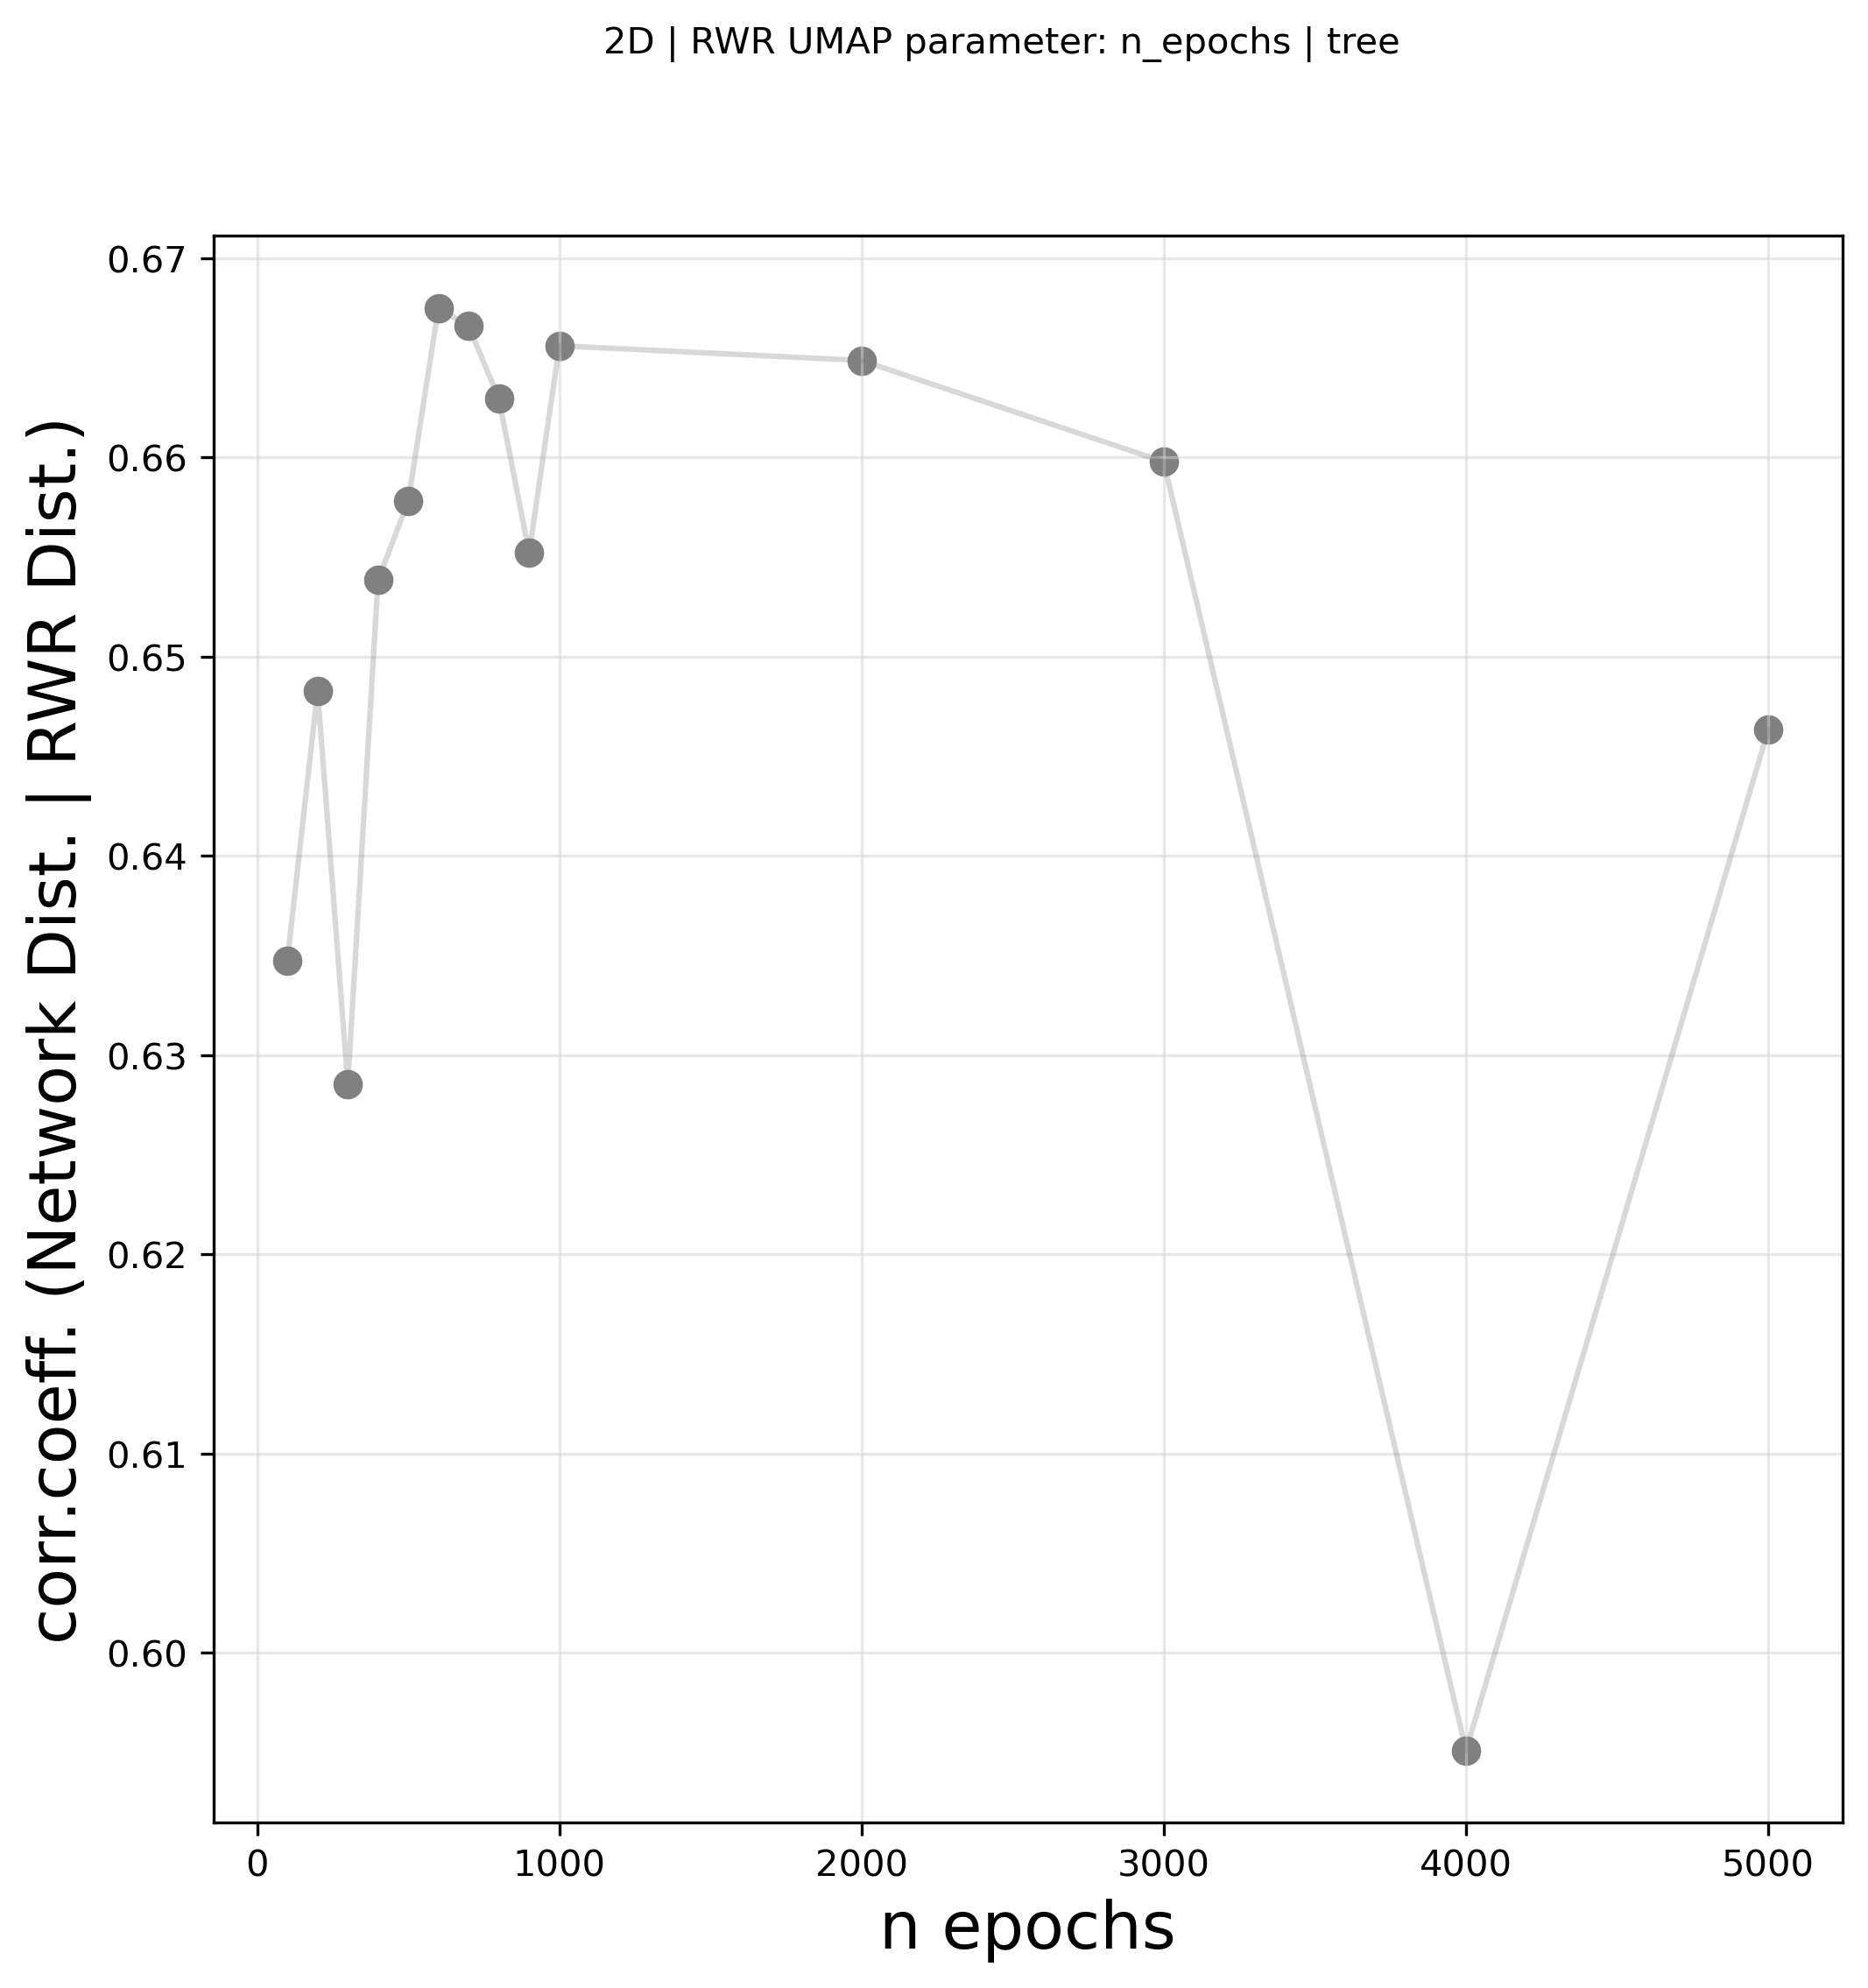

In [38]:
x = list(d_rwr_epochs.keys())
y = list(d_r_values_rwr_nep.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("n epochs", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: n_epochs | '+organism, fontsize=10)

fig.savefig('output_plots/Correlation_nepochs_'+feature+'_'+organism+'.png')

In [39]:
# LEARNING RATE 

lnr_list = [0.001,0.01,0.1,1,10,100,200,300,400,500,600,700,800,900,1000]

d_rwr_lnr = {}
d_r_values_rwr_lnr = {}

for i in lnr_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM = FM_m #.T

    umap_rwr = embed_umap_2D(DM, 20, spread, min_dist, metric, learn_rate = i, n_ep = 1000)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP learning rate:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_lnr[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_lnr[i] = r_value_rwr

UMAP learning rate: 0.001
Execution Time: 00:00:05
min: 0 sec: 5
UMAP learning rate: 0.01
Execution Time: 00:00:05
min: 0 sec: 5
UMAP learning rate: 0.1
Execution Time: 00:00:05
min: 0 sec: 5
UMAP learning rate: 1
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 10
Execution Time: 00:00:05
min: 0 sec: 5
UMAP learning rate: 100
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 200
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 300
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 400
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 500
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 600
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 700
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 800
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 900
Execution Time: 00:00:06
min: 0 sec: 6
UMAP learning rate: 1000
Execution Time: 00:00:06
min: 0 sec: 6


In [40]:
d_rwr_lnr

{0.001: 5,
 0.01: 5,
 0.1: 5,
 1: 6,
 10: 5,
 100: 6,
 200: 6,
 300: 6,
 400: 6,
 500: 6,
 600: 6,
 700: 6,
 800: 6,
 900: 6,
 1000: 6}

In [41]:
d_r_values_rwr_lnr

{0.001: 0.5125644163175892,
 0.01: 0.5543823831142188,
 0.1: 0.6259514227175101,
 1: 0.6656072060064759,
 10: 0.6761478661587252,
 100: 0.6933604418156945,
 200: 0.5452616877282257,
 300: 0.6504851960720377,
 400: 0.5830899693222681,
 500: 0.6922551357123096,
 600: 0.5029709041166632,
 700: 0.5123273667400612,
 800: 0.6330180759569995,
 900: 0.5076596701698184,
 1000: 0.5052190853379616}

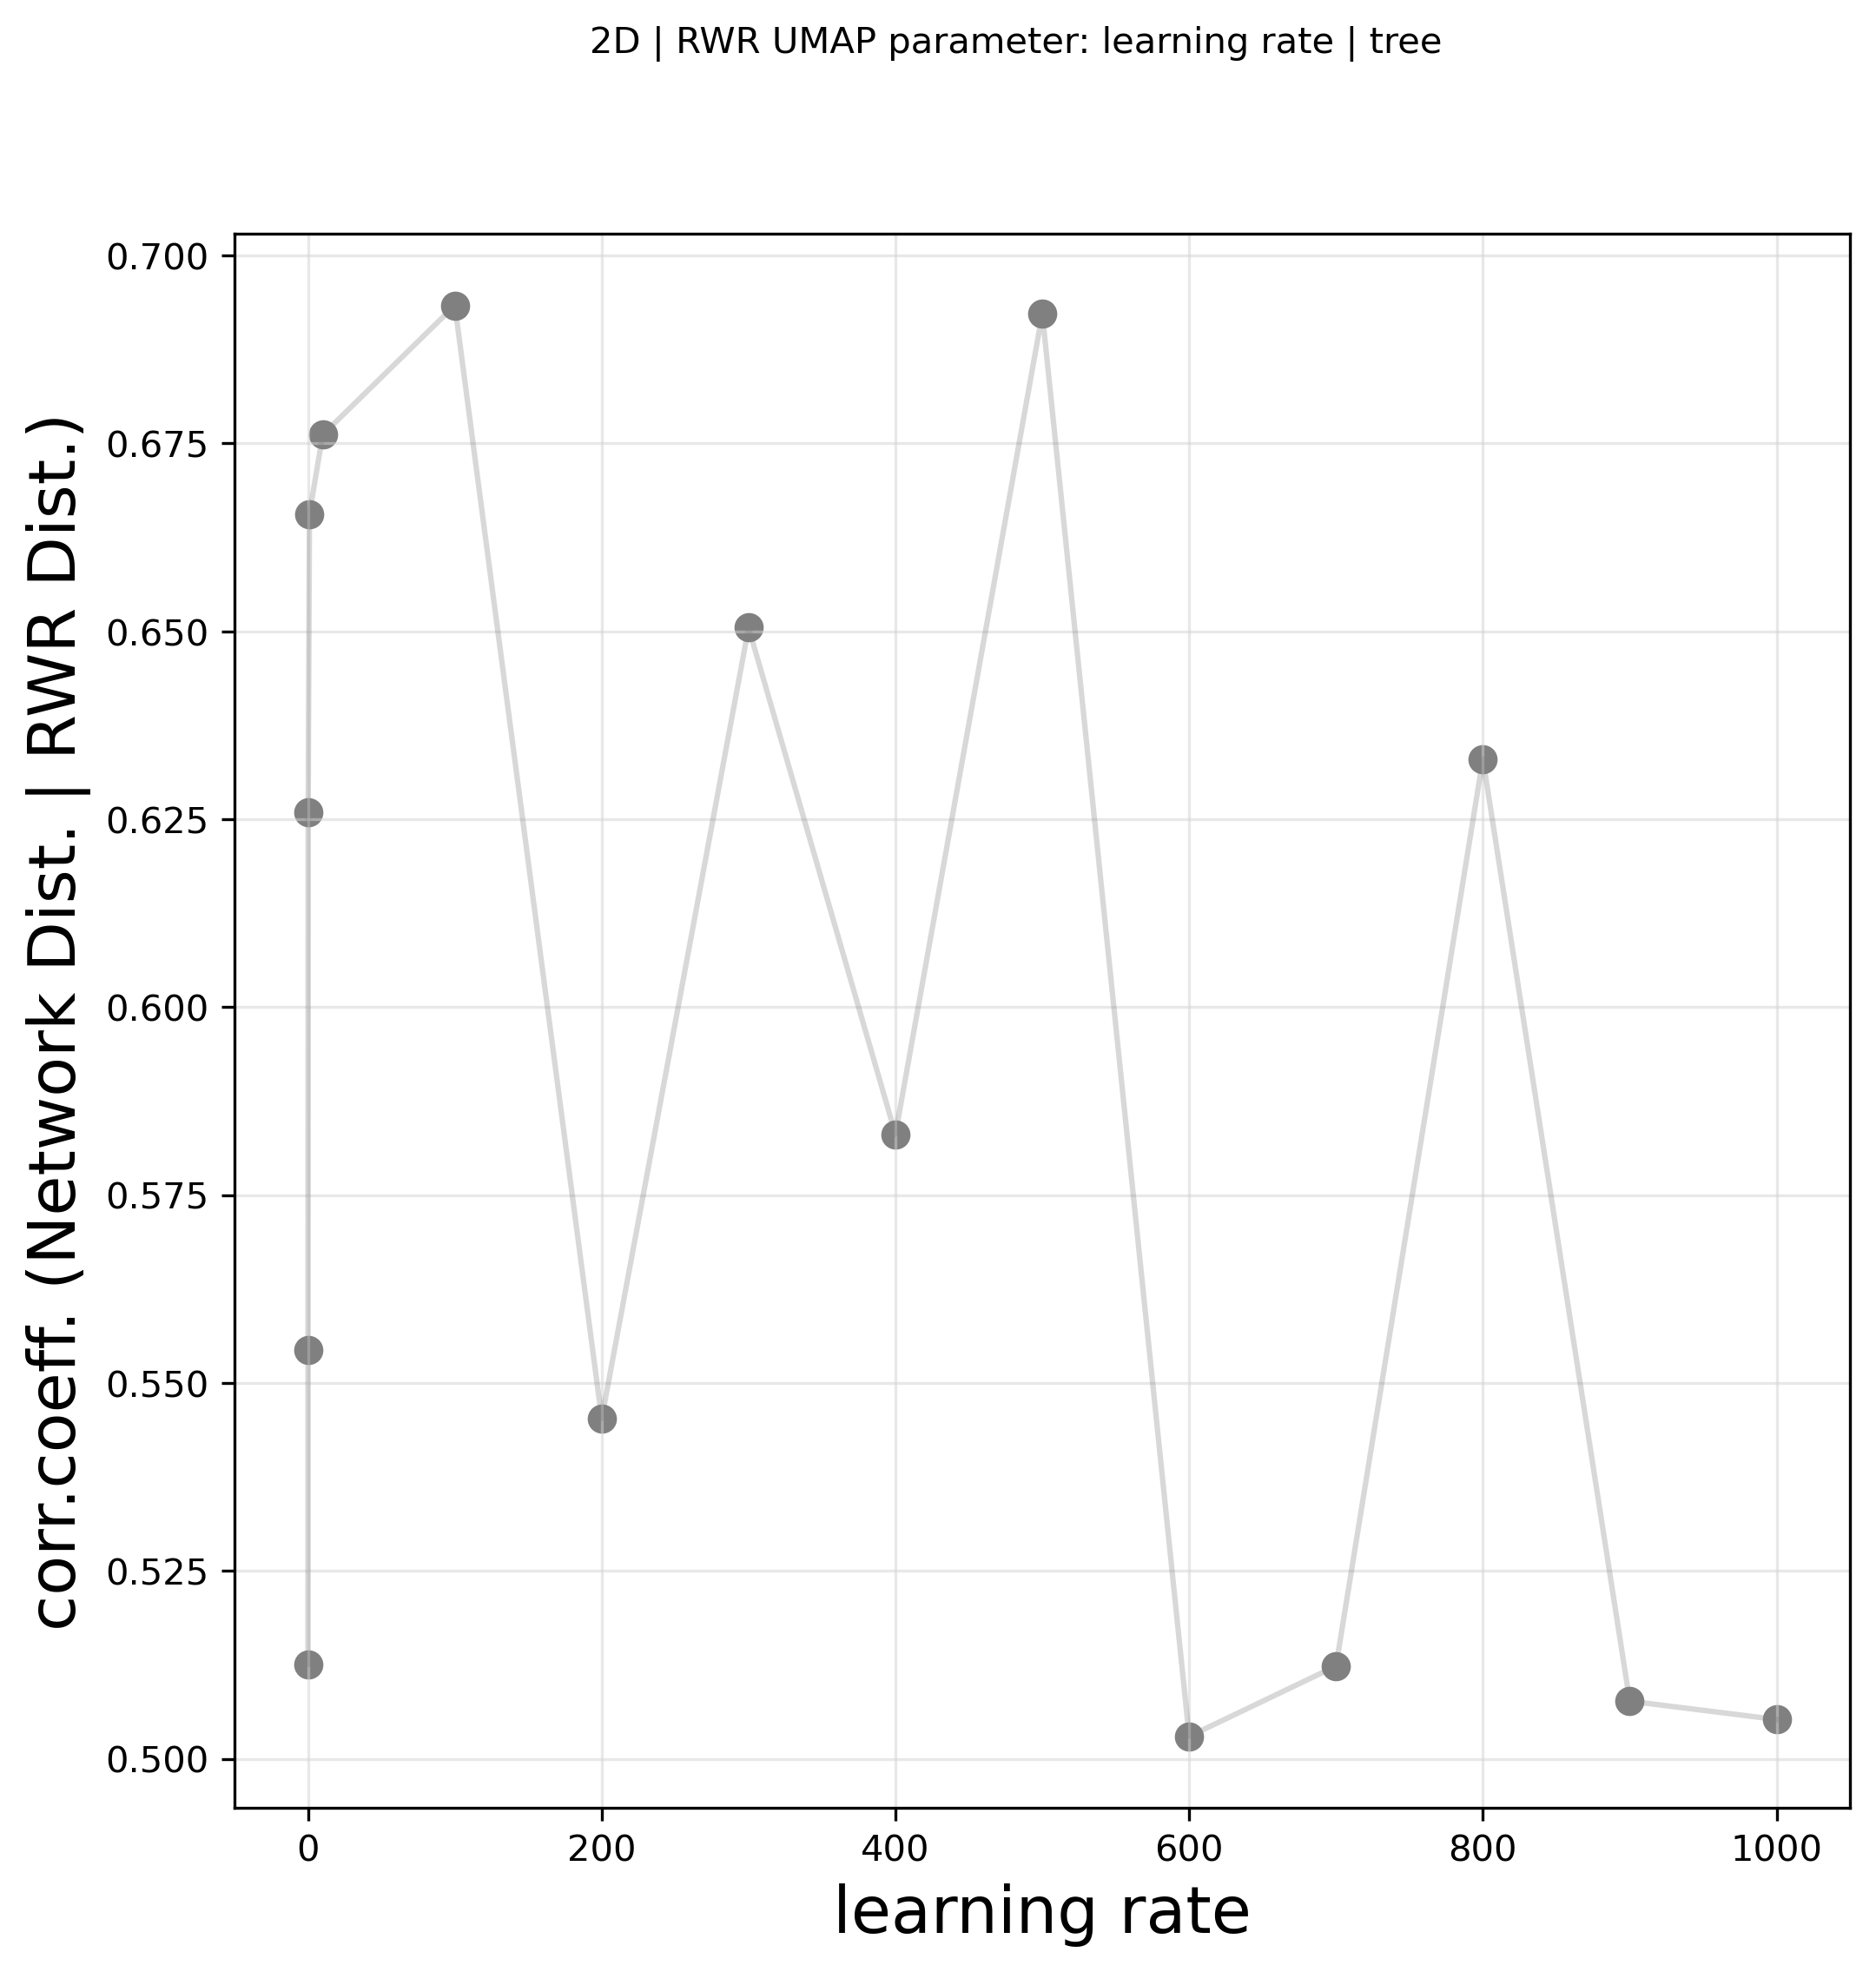

In [42]:
x = list(d_rwr_lnr.keys())
y = list(d_r_values_rwr_lnr.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("learning rate", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: learning rate | '+organism, fontsize=10)

fig.savefig('output_plots/Correlation_learnrate_'+feature+'_'+organism+'.png')

In [43]:
# MIN DIST 

mindist_list = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

d_rwr_mdist = {}
d_r_values_rwr_mdist = {}

for i in mindist_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM = FM_m #.T

    umap_rwr = embed_umap_2D(DM, 20, spread, i, metric, learn_rate = 100, n_ep = 1000)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP min dist:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_mdist[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_mdist[i] = r_value_rwr

UMAP min dist: 0.001
Execution Time: 00:00:07
min: 0 sec: 7
UMAP min dist: 0.01
Execution Time: 00:00:06
min: 0 sec: 6
UMAP min dist: 0.1
Execution Time: 00:00:06
min: 0 sec: 6
UMAP min dist: 0.2
Execution Time: 00:00:07
min: 0 sec: 7
UMAP min dist: 0.3
Execution Time: 00:00:07
min: 0 sec: 7
UMAP min dist: 0.4
Execution Time: 00:00:06
min: 0 sec: 6
UMAP min dist: 0.5
Execution Time: 00:00:07
min: 0 sec: 7
UMAP min dist: 0.6
Execution Time: 00:00:06
min: 0 sec: 6
UMAP min dist: 0.7
Execution Time: 00:00:06
min: 0 sec: 6
UMAP min dist: 0.8
Execution Time: 00:00:06
min: 0 sec: 6
UMAP min dist: 0.9
Execution Time: 00:00:06
min: 0 sec: 6
UMAP min dist: 1
Execution Time: 00:00:06
min: 0 sec: 6


In [44]:
d_rwr_mdist

{0.001: 7,
 0.01: 6,
 0.1: 6,
 0.2: 7,
 0.3: 7,
 0.4: 6,
 0.5: 7,
 0.6: 6,
 0.7: 6,
 0.8: 6,
 0.9: 6,
 1: 6}

In [45]:
d_r_values_rwr_mdist

{0.001: 0.6939614818171072,
 0.01: 0.6914551001262437,
 0.1: 0.6781462514652953,
 0.2: 0.5962584666495186,
 0.3: 0.5882046913900469,
 0.4: 0.6878958025322549,
 0.5: 0.6344984943747126,
 0.6: 0.6886781449123306,
 0.7: 0.5797924912159385,
 0.8: 0.5824550991701557,
 0.9: 0.6933604418156945,
 1: 0.6801185107707025}

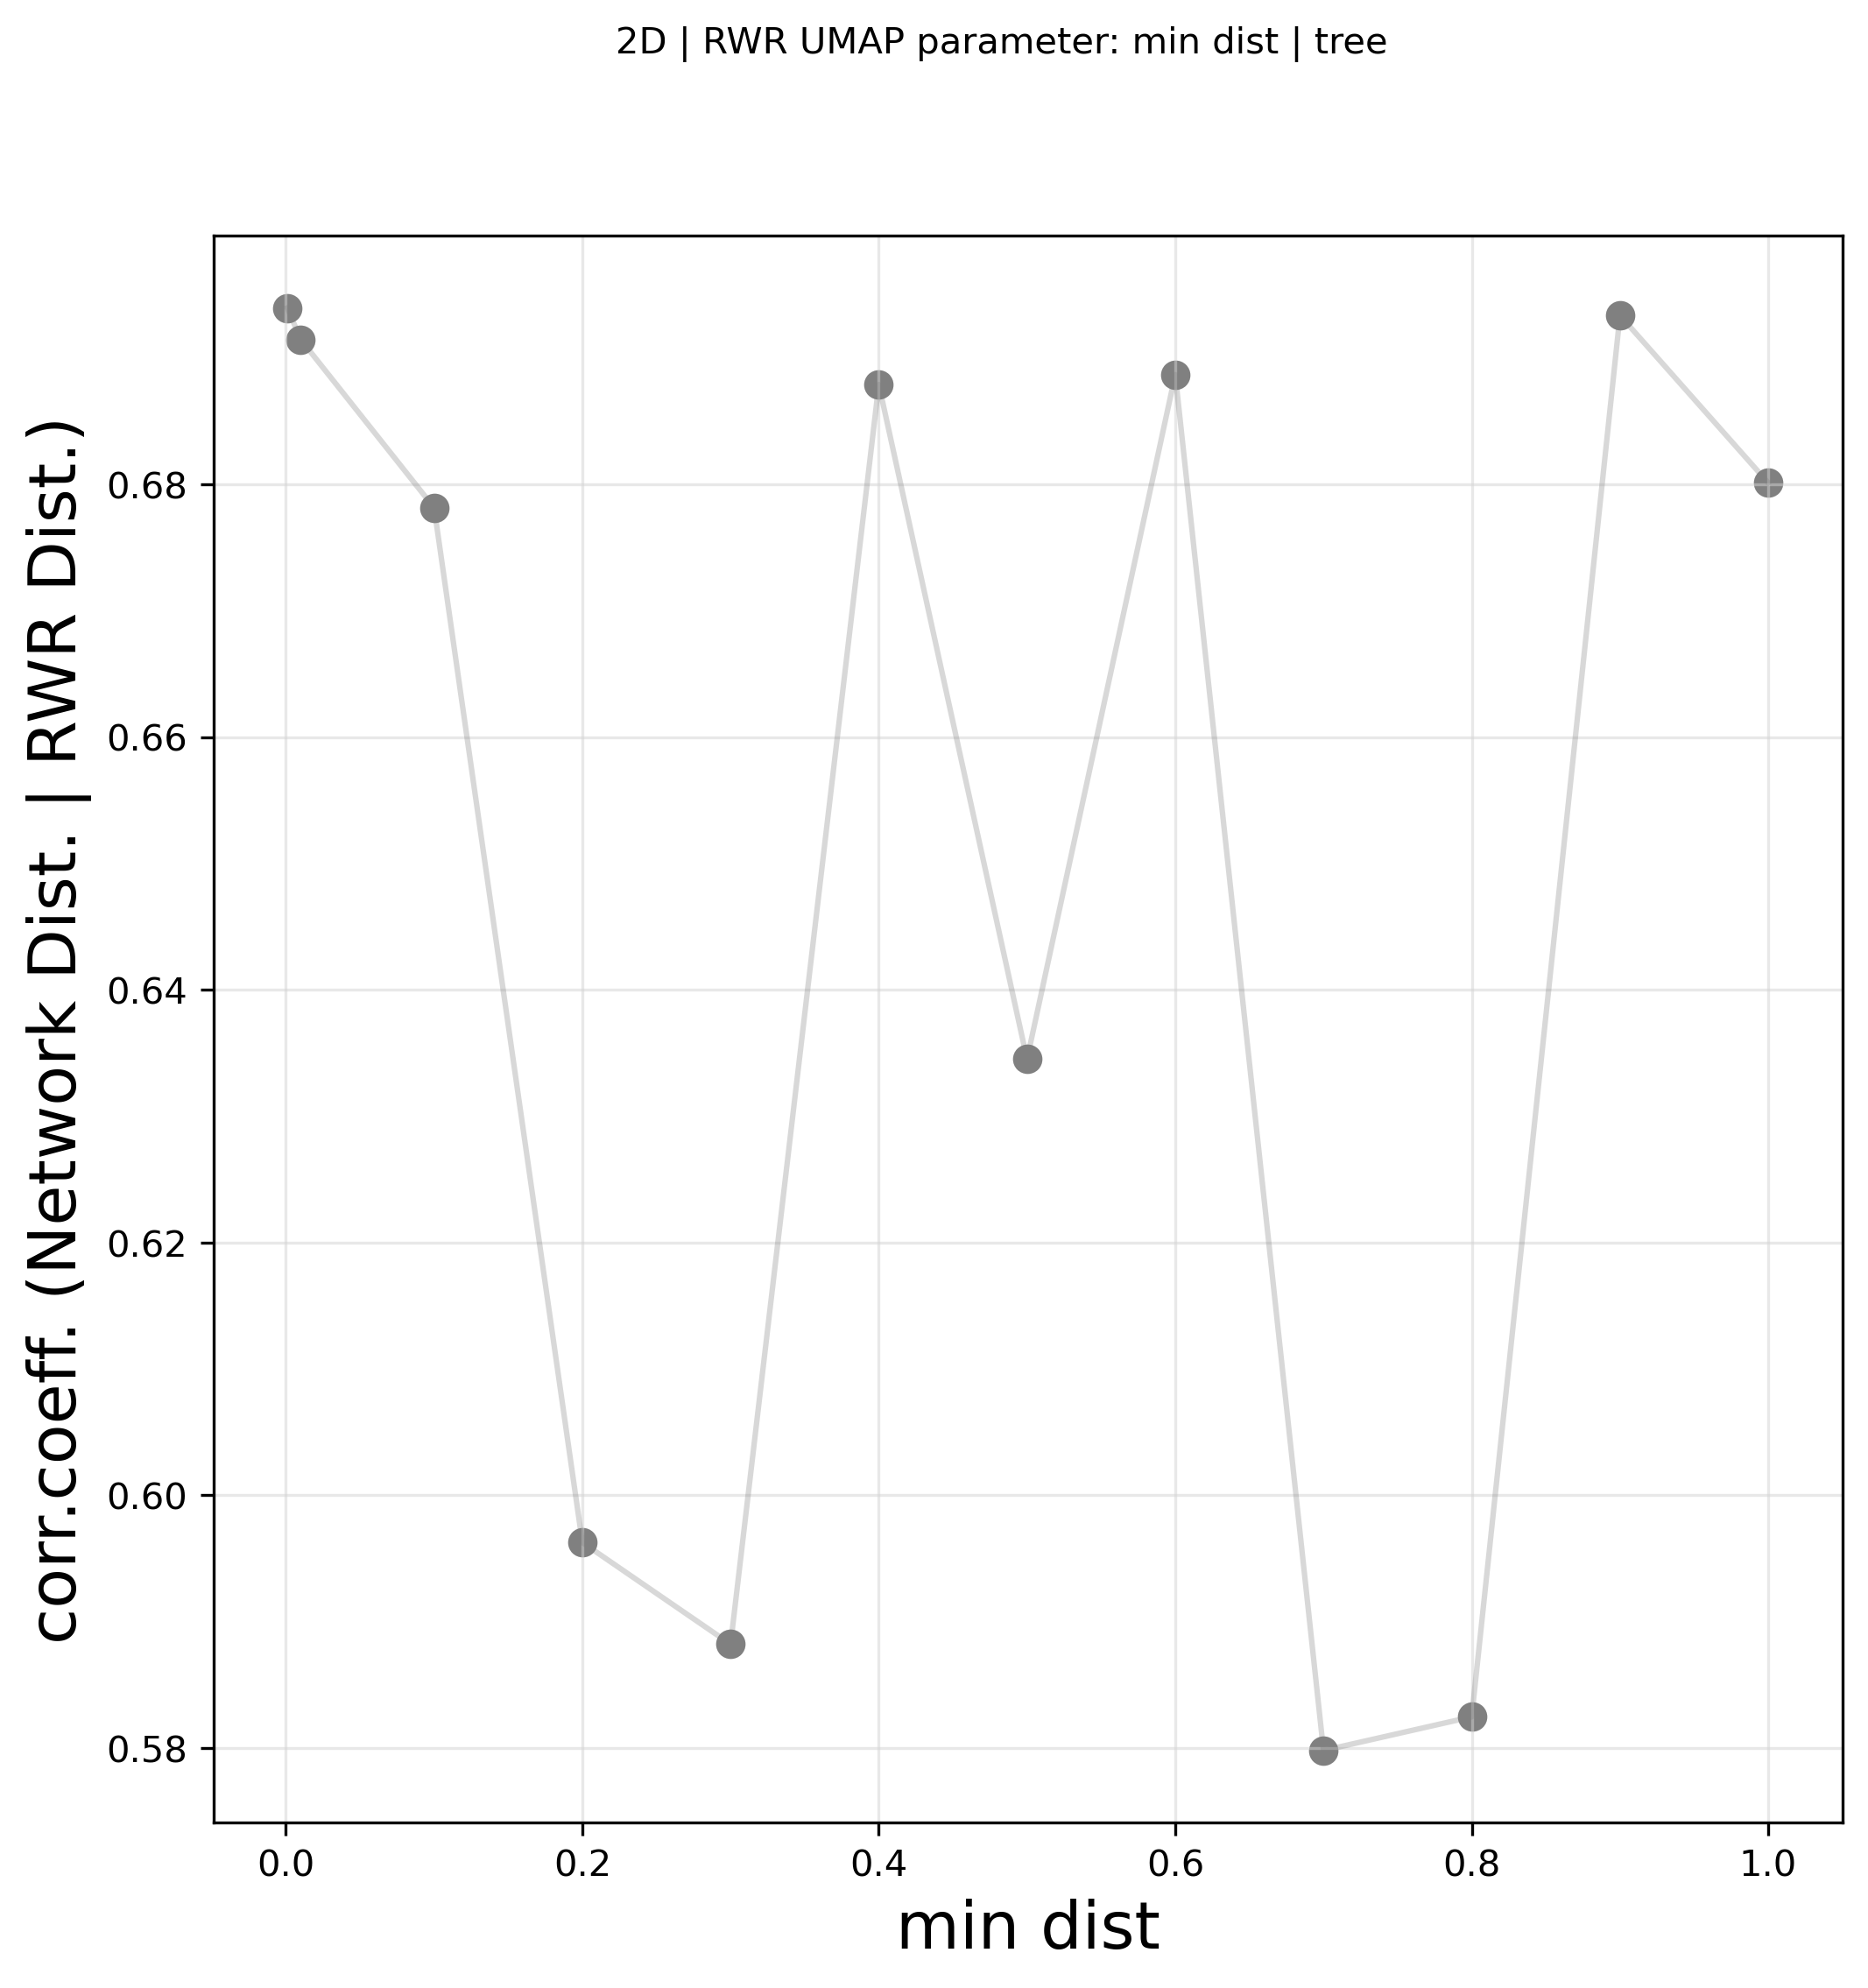

In [46]:
x = list(d_rwr_mdist.keys())
y = list(d_r_values_rwr_mdist.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("min dist", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: min dist | '+organism, fontsize=10)

fig.savefig('output_plots/Correlation_mindist_'+feature+'_'+organism+'.png')

In [47]:
# SPREAD

spread_list = [0.9,1,2,3,4,5,6,7,8,9,10]

d_rwr_spread = {}
d_r_values_rwr_spread  = {}

for i in spread_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM = FM_m #.T

    umap_rwr = embed_umap_2D(DM, 20, i, 0.9, metric, learn_rate = 100, n_ep = 1000)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP spread:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_spread[i] = walltime_rwr
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_rwr = list(dist_layout2D.values())
    x_rwr = list(dist_network.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_spread[i] = r_value_rwr

UMAP spread: 0.9
Execution Time: 00:00:07
min: 0 sec: 7
UMAP spread: 1
Execution Time: 00:00:06
min: 0 sec: 6
UMAP spread: 2
Execution Time: 00:00:06
min: 0 sec: 6
UMAP spread: 3
Execution Time: 00:00:06
min: 0 sec: 6


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 4
Execution Time: 00:00:07
min: 0 sec: 7


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 5
Execution Time: 00:00:06
min: 0 sec: 6


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 6
Execution Time: 00:00:06
min: 0 sec: 6


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 7
Execution Time: 00:00:06
min: 0 sec: 6


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 8
Execution Time: 00:00:06
min: 0 sec: 6


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 9
Execution Time: 00:00:06
min: 0 sec: 6


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 10
Execution Time: 00:00:06
min: 0 sec: 6


In [48]:
d_rwr_spread

{0.9: 7, 1: 6, 2: 6, 3: 6, 4: 7, 5: 6, 6: 6, 7: 6, 8: 6, 9: 6, 10: 6}

In [49]:
d_r_values_rwr_spread

{0.9: 0.6904083582882584,
 1: 0.6933604418156945,
 2: 0.6084676833437187,
 3: 0.6930530945111097,
 4: 0.6747113366460344,
 5: 0.696630529486086,
 6: 0.6954719837406371,
 7: 0.660852956791201,
 8: 0.651089354148062,
 9: 0.5370178018861662,
 10: 0.6919198281954992}

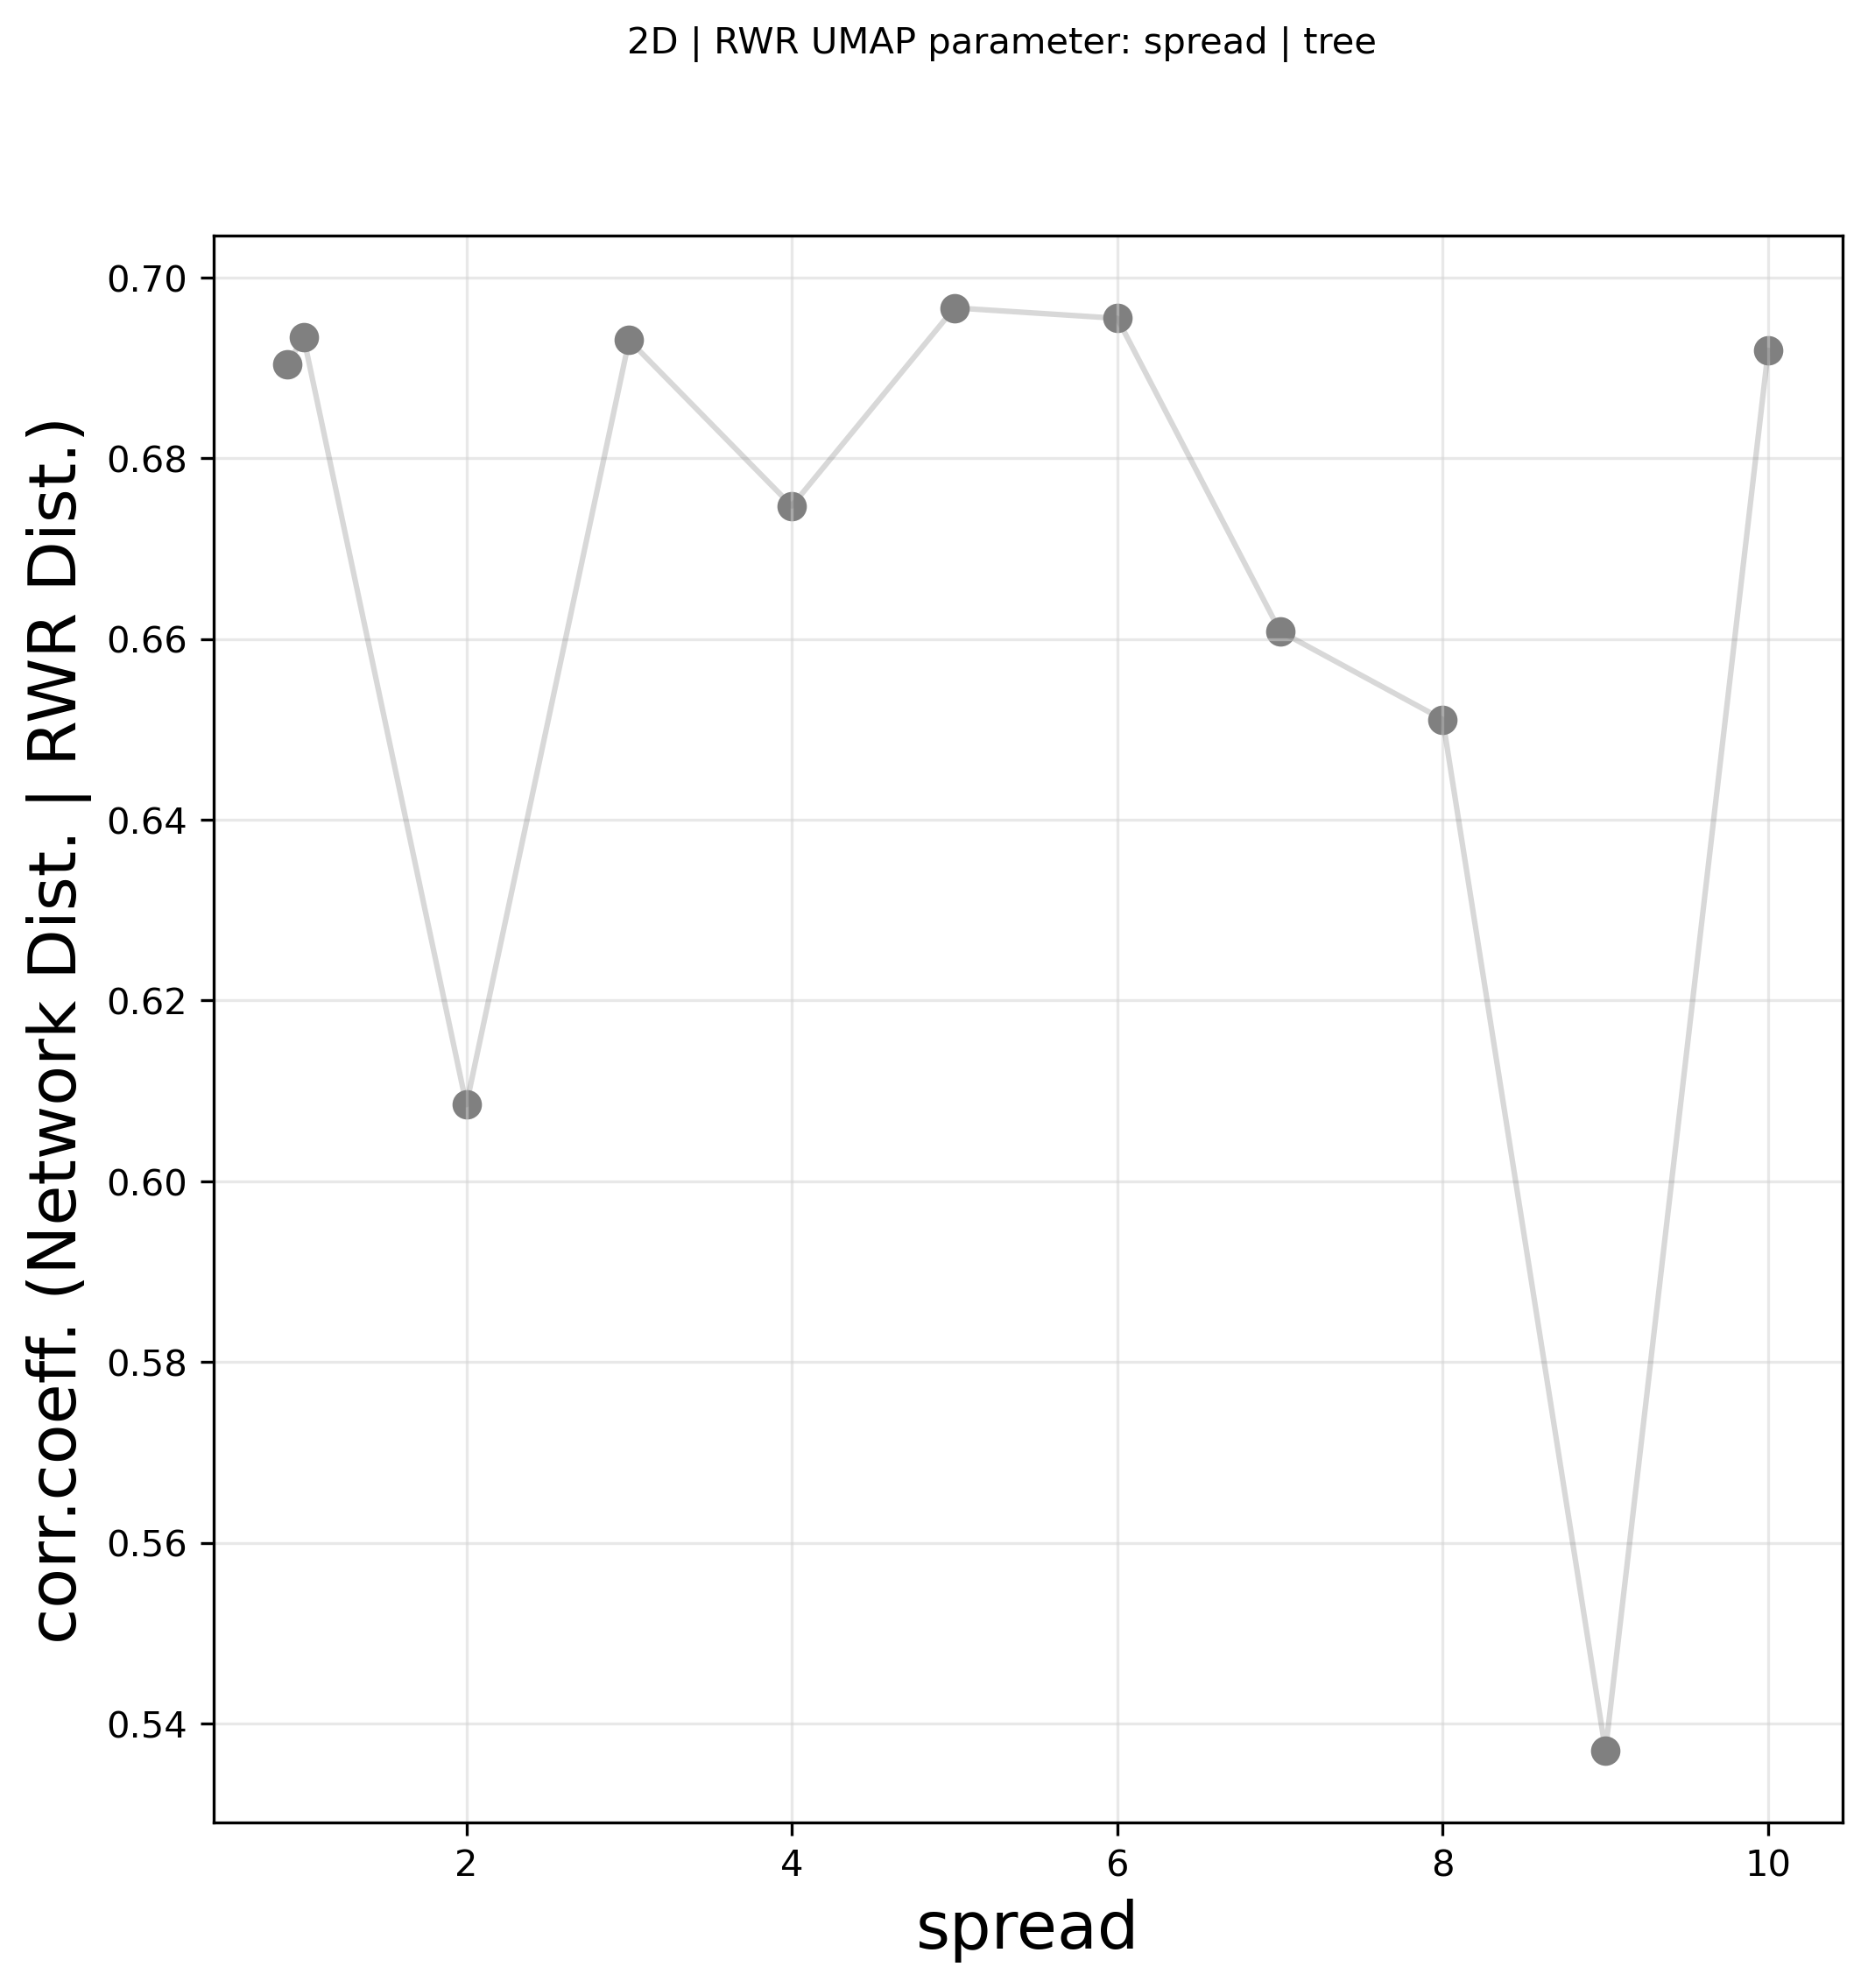

In [50]:
x = list(d_rwr_spread.keys())
y = list(d_r_values_rwr_spread.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("spread", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: spread | '+organism, fontsize=10)

fig.savefig('output_plots/Correlation_spread_'+feature+'_'+organism+'.png')

In [51]:
# VALUES that achieve a Corr. Coefficient > 0.65 

# NETWORK TREE with ~1000 nodes 
# learning rate = 100 
# spread = 5-6
# min_dist = 0.0, 0.4, 0.9 
# n_epochs = 500-1000 
# number of neighbors = 10-50 

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



Network: tree
Number of nodes: 1093
Number of edges: 1092


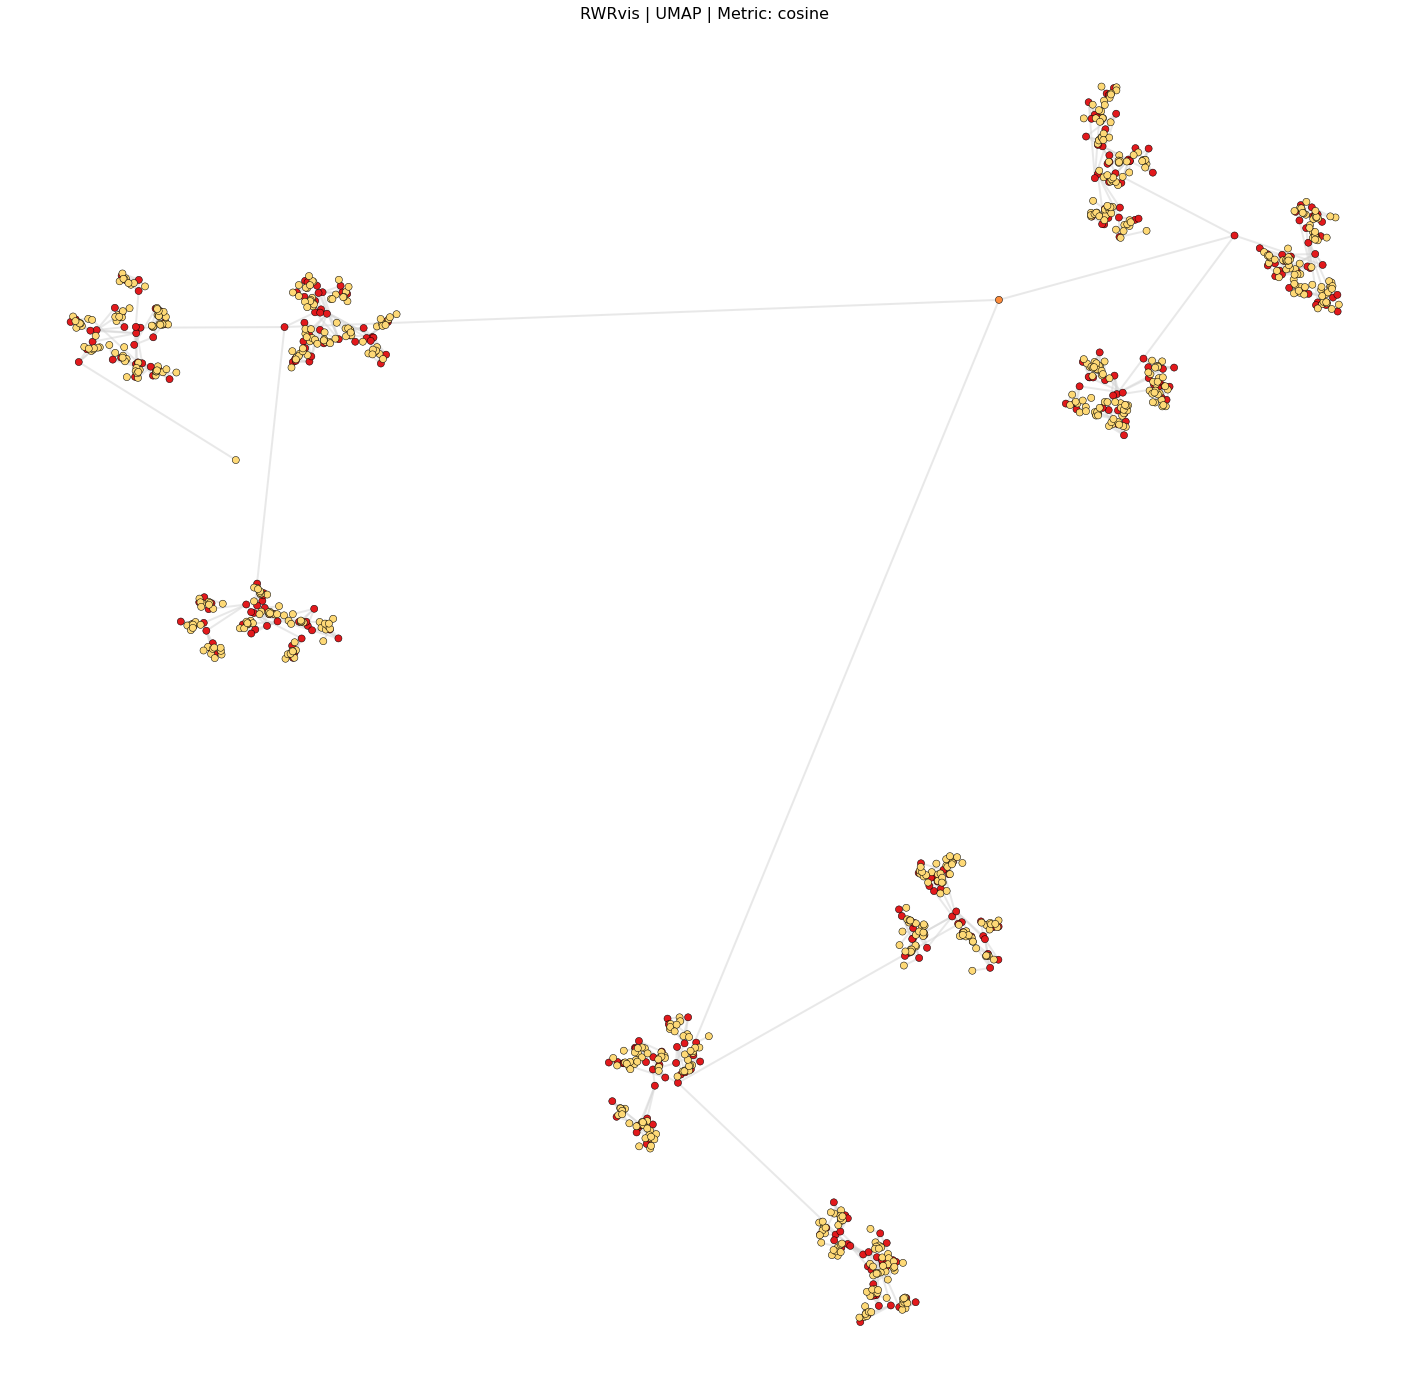

CPU times: user 6.64 s, sys: 201 ms, total: 6.84 s
Wall time: 5.94 s


In [71]:
%%time 

lnr = 100
spread = 5
min_dist = 0.9
nep = 600
n_neighbors = 20

metric ='cosine'


feature = 'RWRvis'

r = .9 # restart probability; originally 0.8
alpha = 1.0
# alpha = 0.5 # --> better results for torus 

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
FM_m_transposed = FM_m#.T
DM=FM_m_transposed

umap_rwr = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_rwr).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_rwr_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 50, #100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_rwr_norm, width = edge_width, 
                       edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
plt.show()

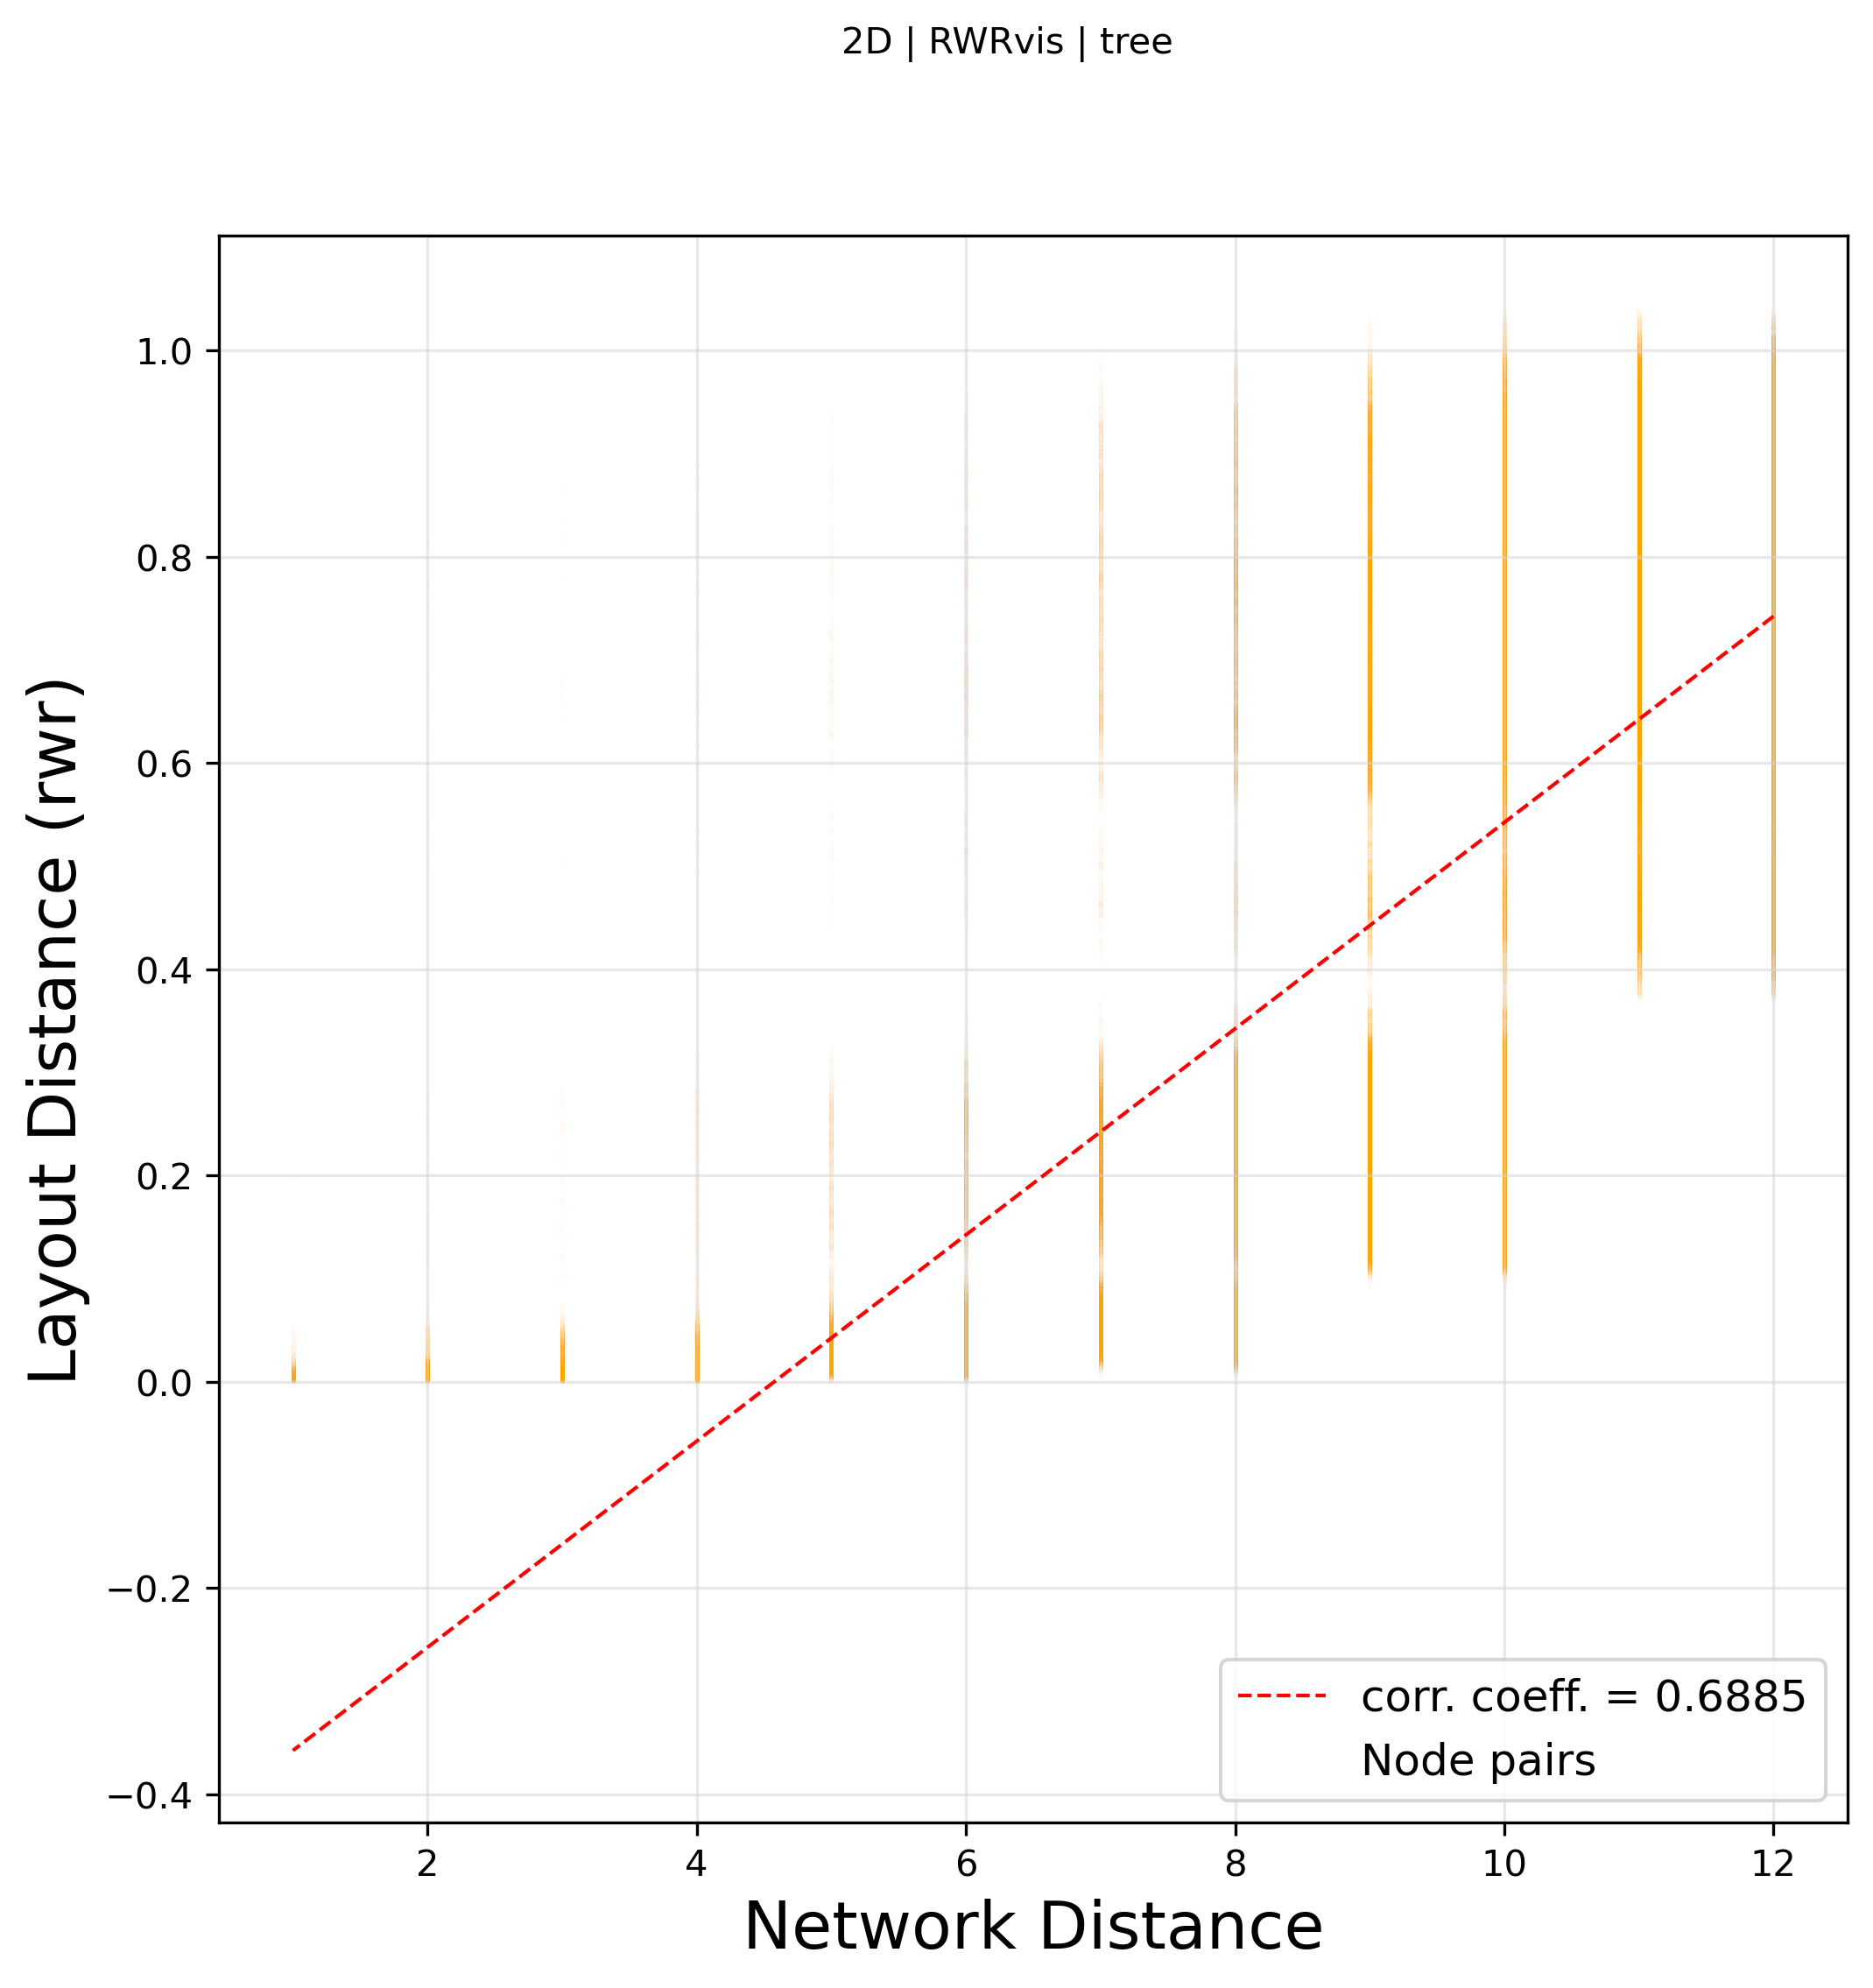

In [76]:
feature = 'RWRvis'
#DM = DM_m

DM = FM_m
DM_spl = df_spl
#DM_spl = DM_spl_norm


# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]
    
# LAYOUT 
posG_complete_umap = posG_complete_umap_rwr_norm 

dist_layout2D = {}
for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

fig = plt.figure(figsize=(8,8), dpi=300)

y_layout = list(dist_layout2D.values())
x_layout = list(dist_network.values())
plt.scatter(x_layout,y_layout, c = 'orange', s = 0.00005, alpha = 0.5)

# REGRESSION LINE 
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
mn_layout = min(x_layout)
mx_layout = max(x_layout)
x1_layout=np.linspace(mx_layout,mn_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)
plt.legend(('corr. coeff. = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

plt.show()
fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+metric+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

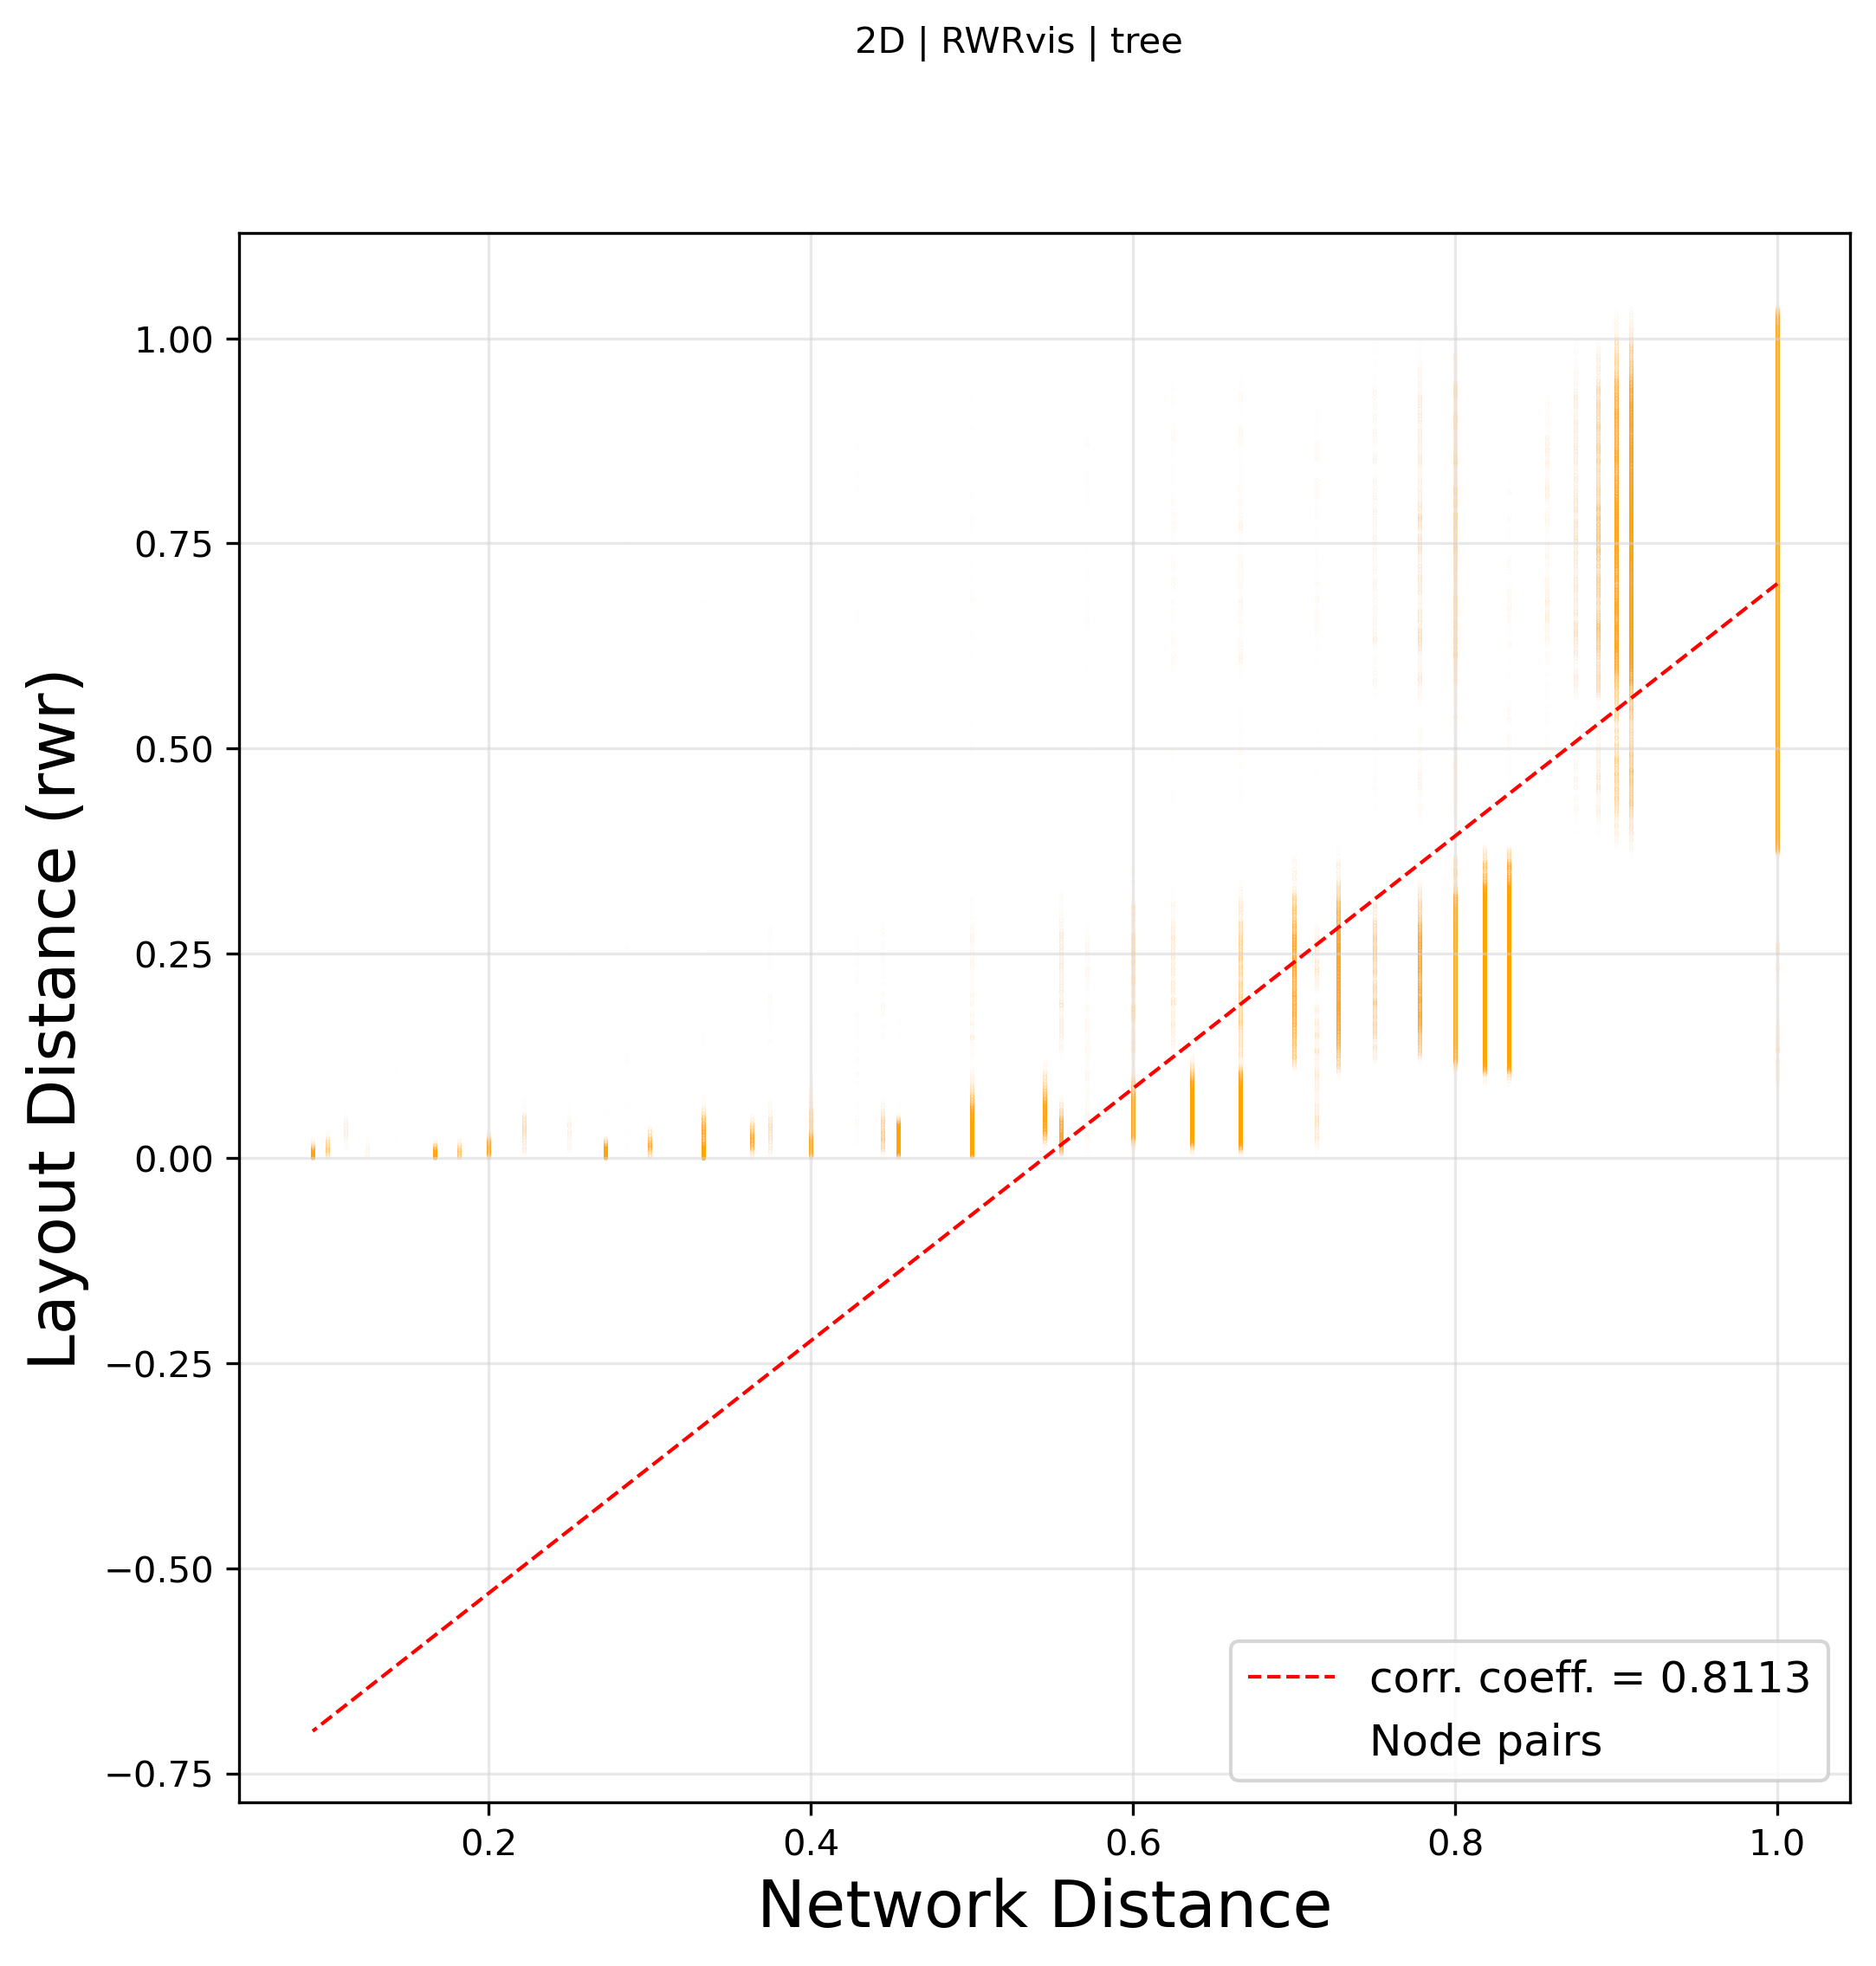

In [75]:
feature = 'RWRvis'
#DM = DM_m

DM = FM_m
#DM_spl = df_spl
DM_spl = DM_spl_norm


# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]
    
# LAYOUT 
posG_complete_umap = posG_complete_umap_rwr_norm 

dist_layout2D = {}
for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

fig = plt.figure(figsize=(8,8), dpi=300)

y_layout = list(dist_layout2D.values())
x_layout = list(dist_network.values())
plt.scatter(x_layout,y_layout, c = 'orange', s = 0.00005, alpha = 0.5)

# REGRESSION LINE 
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
mn_layout = min(x_layout)
mx_layout = max(x_layout)
x1_layout=np.linspace(mx_layout,mn_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)
plt.legend(('corr. coeff. = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

plt.show()
fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+metric+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'_norm.png')

______________
# 3D BENCHMARK - visual + statistical 
______________

# CHOOSE NETWORK

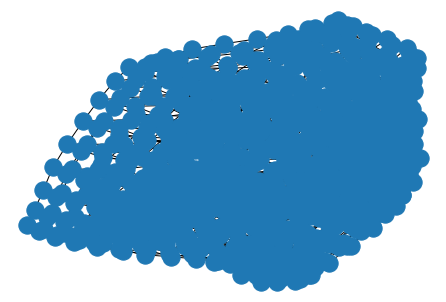

In [331]:
# 3D CUBE 

organism = 'grid'

G_grid = nx.grid_graph([10,10,10],periodic=False)
G = G_grid 
nx.draw(G)

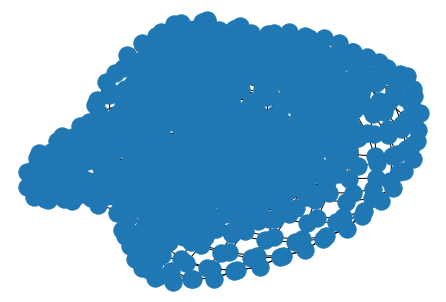

In [454]:
# TORUS 

organism = 'torus'

G_tor = nx.grid_2d_graph(44,23,periodic=True) #24,12
G = G_tor
nx.draw(G)

+ PREDEFINED FEATURE MATRIX

In [332]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESSCENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)
    
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 


# CENTRALITY 

metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))
DM_cent.index = list(G.nodes())
DM_cent.columns = list(G.nodes())

#round(DM_cent,2)

In [333]:
# General Parameters:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = 'black'

# Node sizes 

#scalef= 0.2
#size = list(draw_node_degree(G, scalef).values())

#scalef= 0.05
#size3d = list(draw_node_degree_3D(G, scalef).values())

color_method = 'deg'
d_colours = color_nodes_from_dict(G, d_deghubs, palette = 'YlOrRd')
colours = list(d_colours.values())

labelsize = 18
legendfontsize = 12

___________
## NETWORK DISTANCE 
___________

In [334]:
%%time 

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = round(nx.shortest_path_length(G,geneA,geneB),1)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)

DM_spl = pd.DataFrame(Mspl, columns = list(G.nodes()), index=list(G.nodes()))

#DM_spl.astype(int)

df_spl = DM_spl 
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
DM_spl_norm = pd.DataFrame(x_scaled)

CPU times: user 3min 51s, sys: 2.96 s, total: 3min 54s
Wall time: 3min 57s


## SPRING

In [335]:
%%time 

posG_spring3D  = nx.spring_layout(G, iterations = 100, dim = 3)

df_posG = pd.DataFrame(posG_spring3D).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

spring_nodes = get_trace_nodes_3D(posG_spring3D_norm, None, colours, 4) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D_norm, edge_colordark, opac=1)

spring_data = [spring_nodes, spring_edges]

print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=True)

Spring Layout: grid
CPU times: user 10.6 s, sys: 290 ms, total: 10.9 s
Wall time: 11.9 s


'output_plots/3Dtoynetwork_spring_grid.html'

## 3D PORTRAITS 

+ ADJACENCIES

In [336]:
%%time 
n_neighbors = deg_mean # balance between local and global structure in the data
spread = 1.0
min_dist = 0.01 #defines how dense points are stacked together 
metric ='cosine'

feature = 'ADJ'

A = nx.adjacency_matrix(G)
adj = A.toarray()
df_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))
DM = df_adj

umap_3D_adj = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_adj = get_posG_3D(list(G.nodes()), umap_3D_adj)
posG_3D_complete_umap_adj = {key:posG_3Dumap_adj[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_adj).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_adj_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_adj_nodes = get_trace_nodes_3D(posG_3D_complete_umap_adj_norm, None, colours, 4, opac = 0.8) # size3d)
umap_adj_edges = get_trace_edges_3D(G, posG_3D_complete_umap_adj_norm, edge_colordark, 1.0) 

umap_adj_data = [umap_adj_edges, umap_adj_nodes]

fig = pgo.Figure()
for i in umap_adj_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

CPU times: user 12.3 s, sys: 397 ms, total: 12.7 s
Wall time: 6.55 s


'output_plots/3Dtoynetwork_umap_ADJ_grid.html'

+ RANDOM WALK - visiting probability

In [361]:
%%time 
n_neighbors = 6 #20 # balance between local and global structure in the data
spread = 1.
min_dist = 0.5 #defines how dense points are stacked together 
metric ='cosine'

feature = 'RWRvis'

r = .9 # restart probability; originally 0.8
alpha = 1.0
# alpha = 0.5 # --> better results for torus 

FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
FM_m_transposed = FM_m.T

DM=FM_m_transposed

umap_rwr_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_rwr_nodes = get_trace_nodes_3D(posG_3D_complete_umap_rwr_norm, None, colours, 4, opac = 0.8) # size3d)
umap_rwr_edges = get_trace_edges_3D(G, posG_3D_complete_umap_rwr_norm, edge_colordark, 1.0) 

umap_rwr_data = [umap_rwr_edges, umap_rwr_nodes]

fig = pgo.Figure()
for i in umap_rwr_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

CPU times: user 15.9 s, sys: 311 ms, total: 16.2 s
Wall time: 13.4 s


'output_plots/3Dtoynetwork_umap_RWRvis_grid.html'

+ CENTRALITIES

In [338]:
%%time 

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

feature = 'CENT'

DM = DM_cent
umap_cent_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_cent = get_posG_3D(list(G.nodes()), umap_cent_3D)
posG_3D_complete_umap_cent = {key:posG_3Dumap_cent[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_cent).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_cent_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_cent_nodes = get_trace_nodes_3D(posG_3D_complete_umap_cent_norm, None, colours, 4, opac = 0.8) # size3d)
umap_cent_edges = get_trace_edges_3D(G, posG_3D_complete_umap_cent_norm, edge_colordark, 1.0) 

umap_cent_data = [umap_cent_edges, umap_cent_nodes]

fig = pgo.Figure()
for i in umap_cent_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

CPU times: user 19.3 s, sys: 335 ms, total: 19.7 s
Wall time: 7.62 s


'output_plots/3Dtoynetwork_umap_CENT_grid.html'

_________

# EVALUATION - 3D
### Network Distance vs. Layout Distance 
+ Plots to compare Network Distances (i.e. SPL) with embedded Layout Distances 
+ X-axis = Reference axis i.e. Network Distance 
+ Y-axis = Layout Distance 

## 3D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

+ SPRING

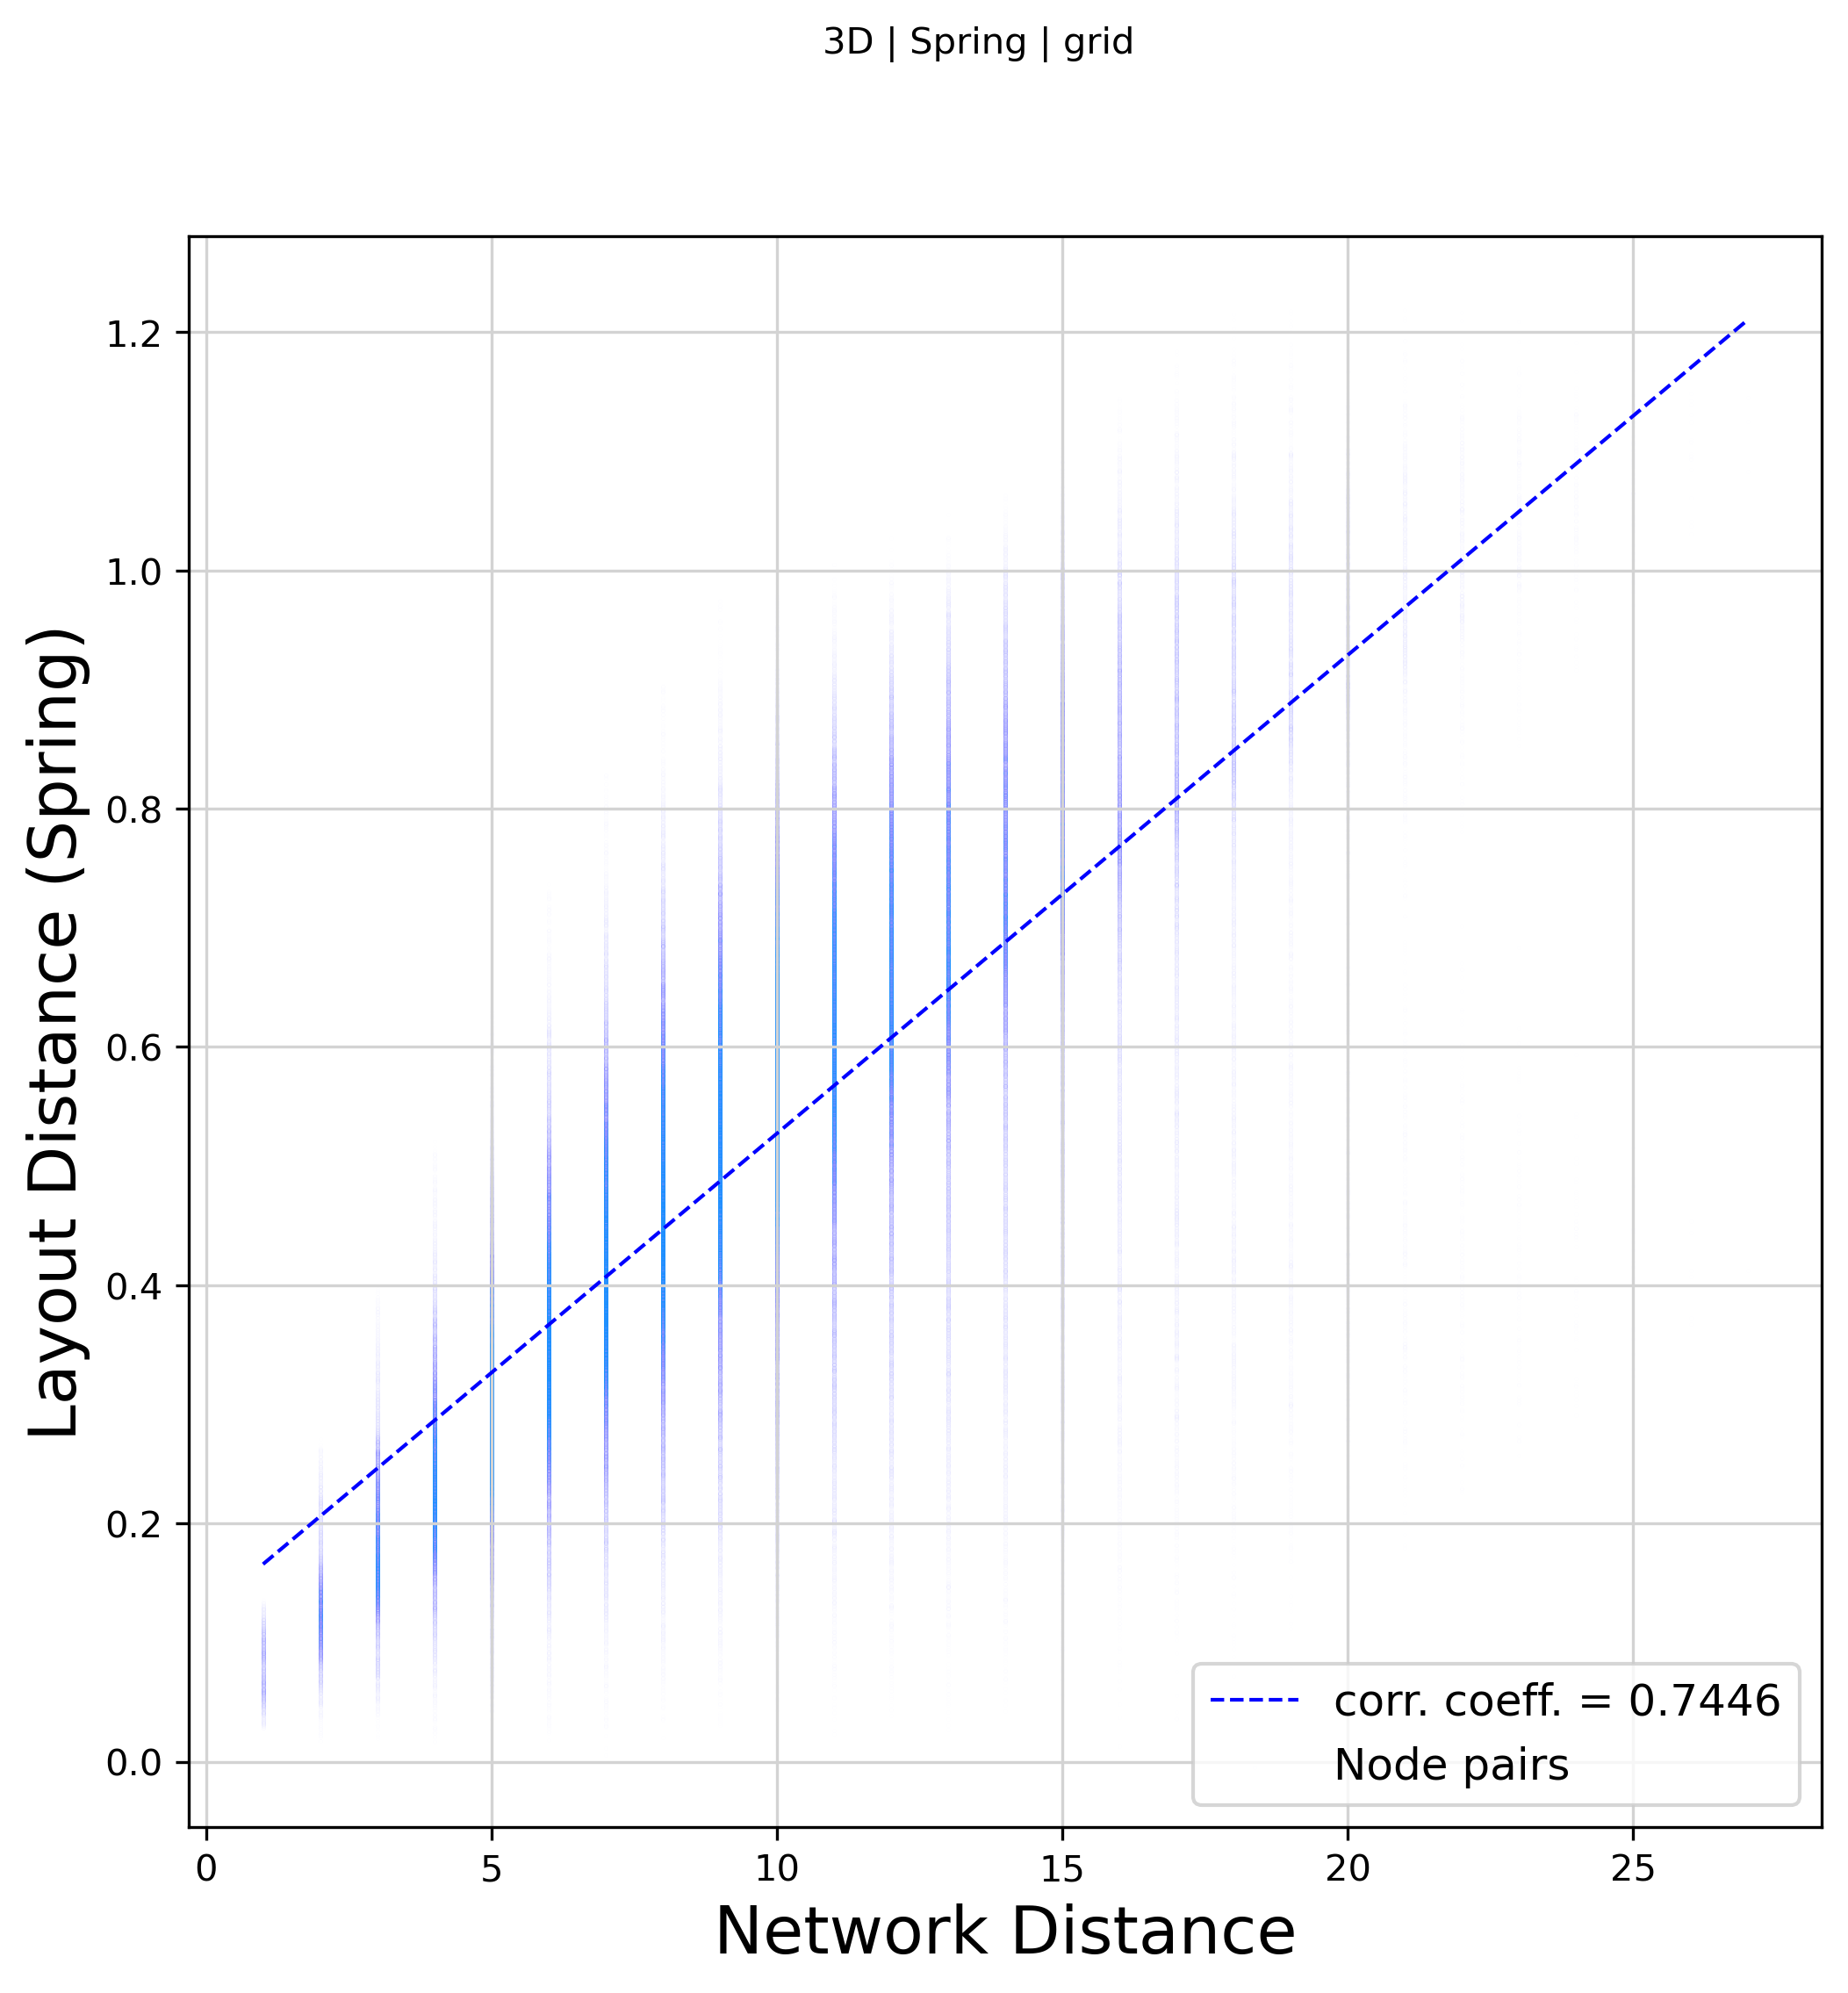

In [343]:
posG_spring3D = posG_spring3D_norm
DM_spl = df_spl
# DM_spl = DM_spl_norm

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]

dist_spring3D = dict()
for (id1,p1),(id2,p2) in it.combinations(posG_spring3D.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

fig = plt.figure(figsize=(8,8), dpi=300)

x_spring3D = list(dist_network.values())
y_spring3D = list(dist_spring3D.values())
plt.scatter(x_spring3D,y_spring3D, c = 'dodgerblue', s = 0.000005, alpha = 0.5)

# REGRESSION LINE 
gradient_spring3D, intercept_spring3D, r_value_spring3D, p_value_spring3D, std_err_spring3D = stats.linregress(x_spring3D,y_spring3D)
mn_spring3D=min(x_spring3D)
mx_spring3D=max(x_spring3D)
x1_spring3D=np.linspace(mn_spring3D,mx_spring3D,500)
line_spring3D =gradient_spring3D*x1_spring3D+intercept_spring3D
plt.plot(x1_spring3D,line_spring3D,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.grid(True, c='lightgrey')

plt.legend(('corr. coeff. = {}'.format(round(r_value_spring3D,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('3D | Spring | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring3D,intercept_spring3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_NetworkDistance_SPRING_'+organism+'.png')

+ RANDOM WALK

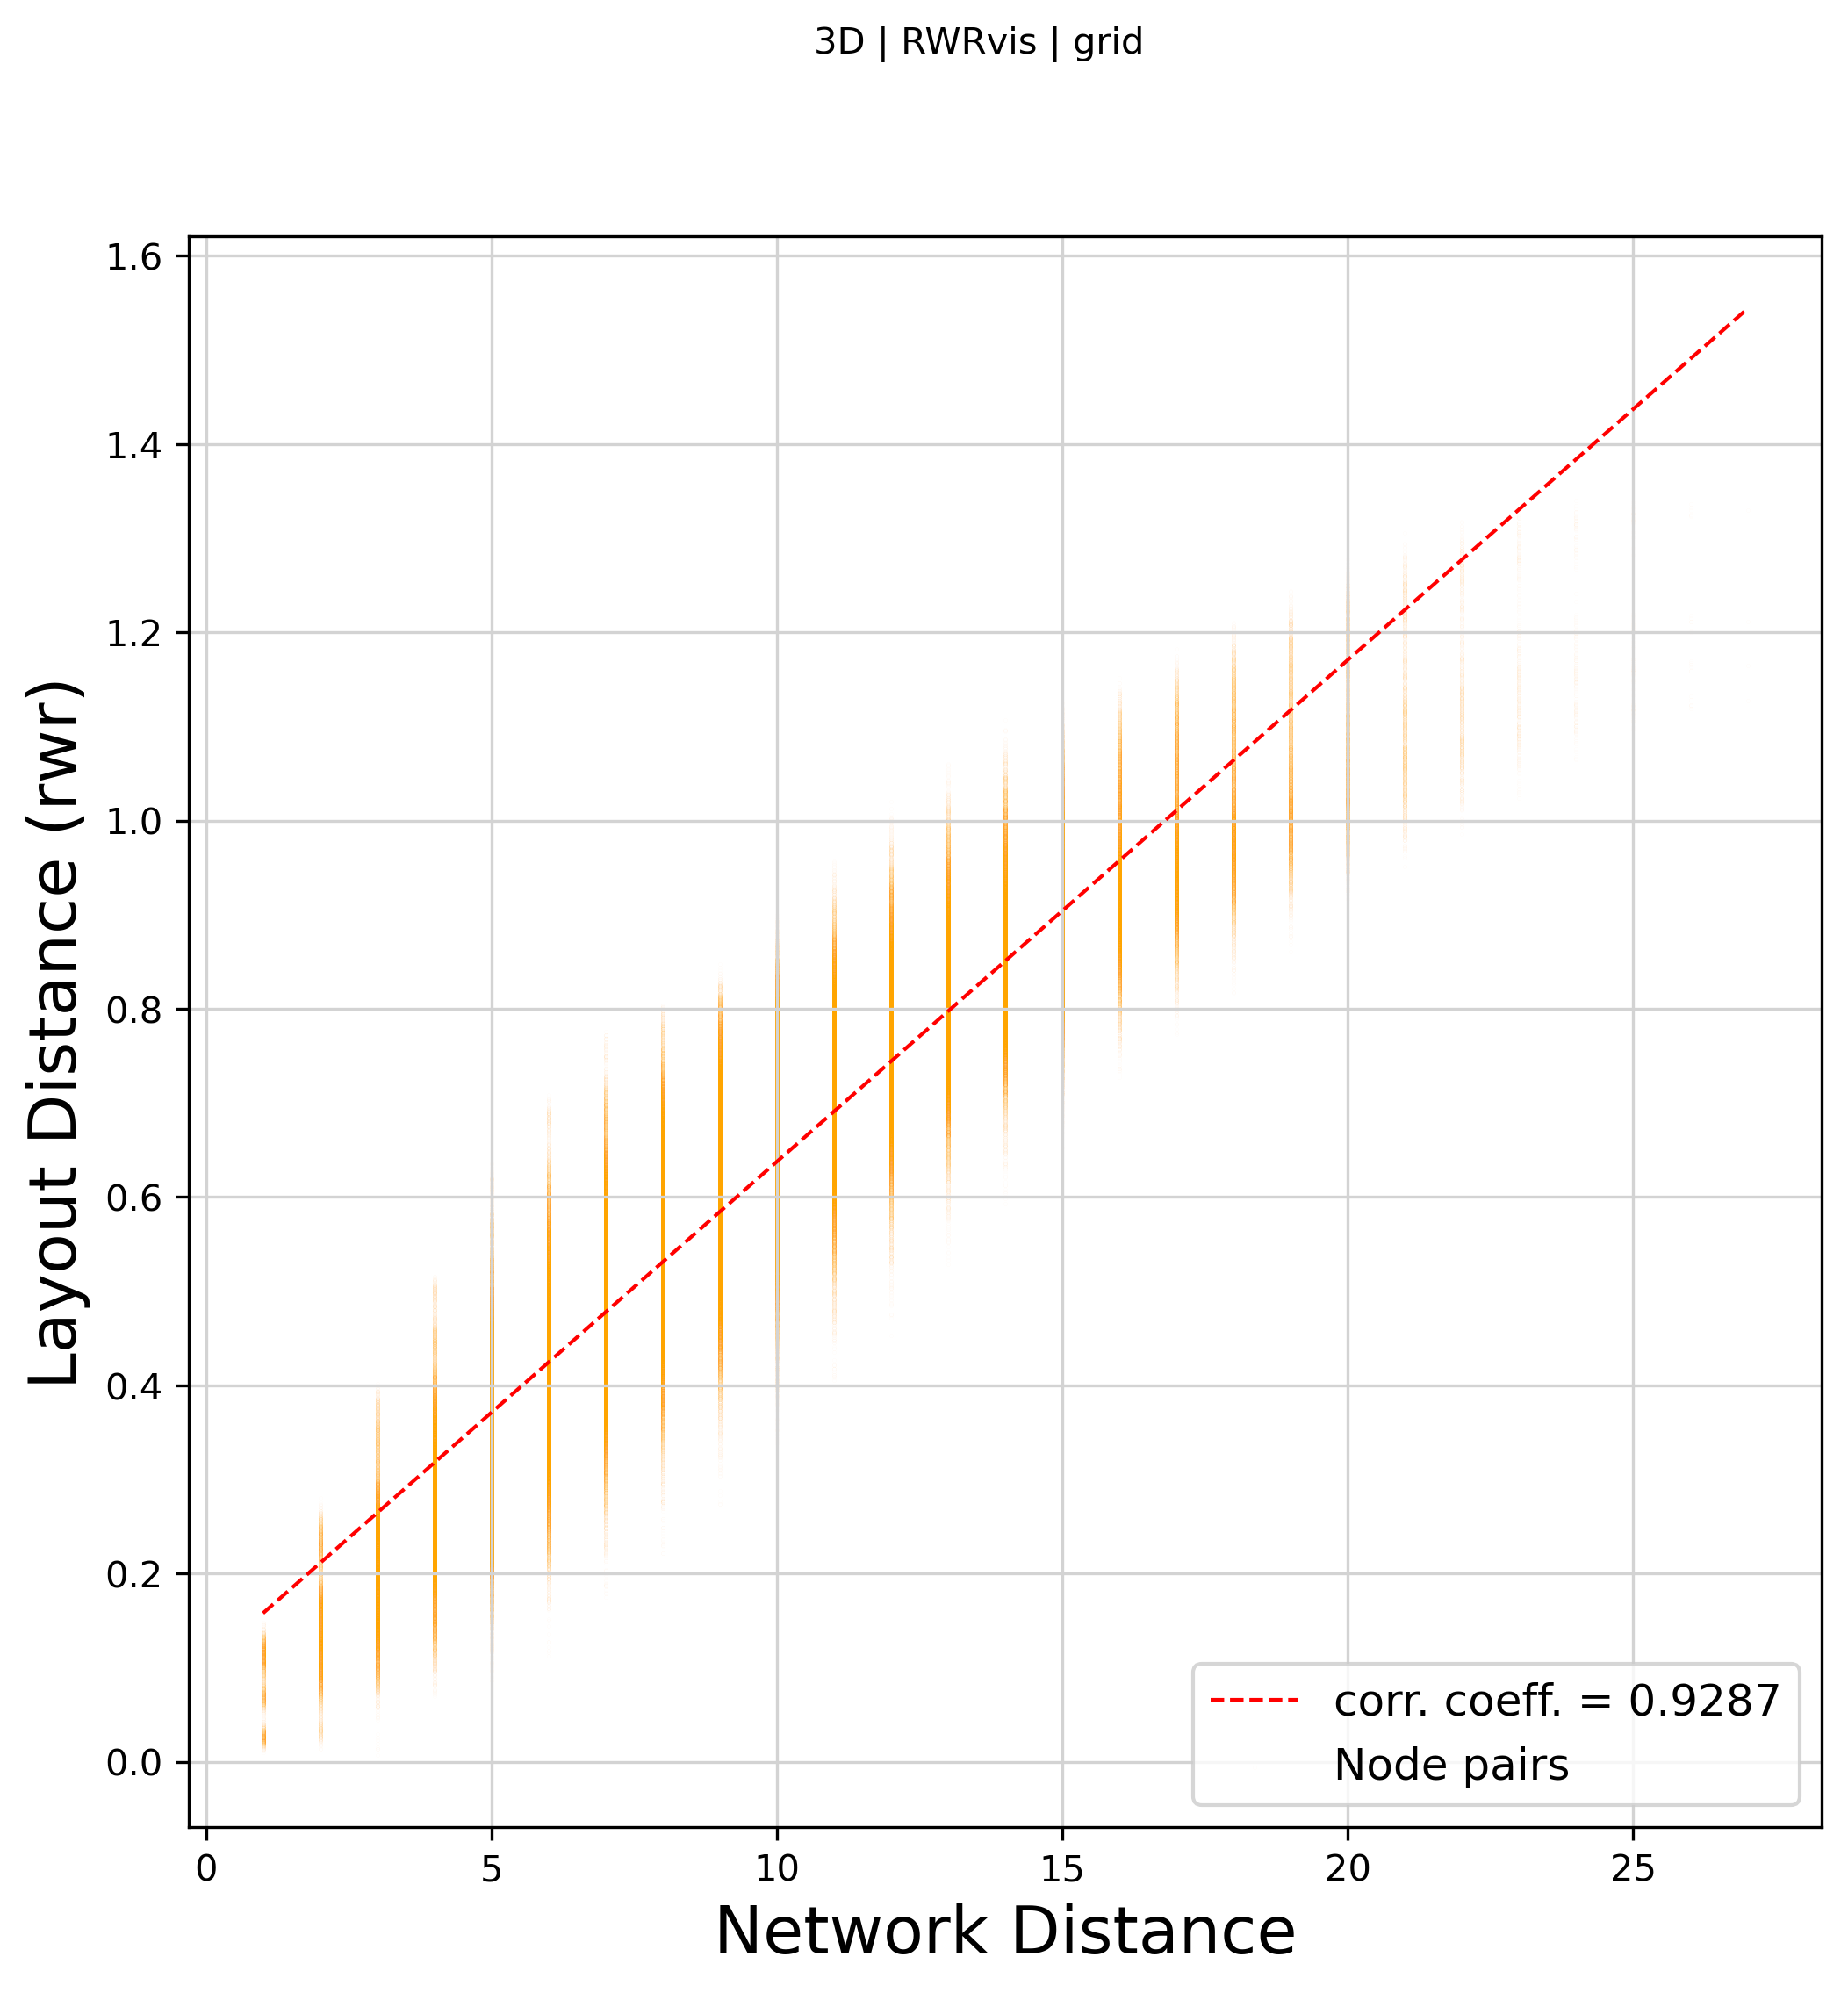

In [342]:
feature = 'RWRvis'
posG_3D_complete_umap = posG_3D_complete_umap_rwr_norm 
DM_spl = df_spl
# DM_spl = DM_spl_norm

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]

dist_layout3D = dict()
for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

fig = plt.figure(figsize=(8,8), dpi=300)
plt.grid(True, c='lightgrey')

y_layout3D = list(dist_layout3D.values())
x_layout3D = list(dist_network.values())
plt.scatter(x_layout3D,y_layout3D, c = 'orange', s = 0.00005, alpha = 0.5)

# REGRESSION LINE 
gradient_layout3D, intercept_layout3D, r_value_layout3D, p_value_layout3D, std_err_layout3D = stats.linregress(x_layout3D,y_layout3D)
mn_layout3D=min(x_layout3D)
mx_layout3D=max(x_layout3D)
x1_layout3D=np.linspace(mn_layout3D,mx_layout3D,500)
line_layout3D = gradient_layout3D*x1_layout3D+intercept_layout3D
plt.plot(x1_layout3D,line_layout3D,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.legend(('corr. coeff. = {}'.format(round(r_value_layout3D,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('3D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout3D,intercept_layout3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')